In [136]:
# Libraries
import os

import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.figsize'] = (12,8)

# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED) 


cwd = os.getcwd()
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/hmw3

!pip install import_ipynb
import import_ipynb
import Parser

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/hmw3'
/content/drive/MyDrive/hmw3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
# Parsing
dir = 'COVID-19/dati-regioni'

region_names = ('Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
                'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d\'Aosta', 'Veneto')

column_names = ['data', 'lat', 'long', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'totale_positivi', 'variazione_totale_positivi', 'nuovi_positivi',
                'dimessi_guariti', 'deceduti', 'tamponi']

output = ['ricoverati_con_sintomi', 'nuovi_positivi','deceduti','dimessi_guariti']

parser = Parser.COVID19_parser(directory=dir, region_names=region_names, column_names=column_names, min_date='20210101', vax=True)

parser.parse()

100%|██████████| 515/515 [00:47<00:00, 10.90it/s]


# Functions

In [138]:
MAX_EPOCHS = 1000
patience = 50

def compile(model):

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [139]:
#### DECOMPOSITION

def plotseasonal(decomposition, axes, title=""):
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_title(title)
    axes[0].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

    return


def plot_decomposition(df, column_name='nuovi_positivi', decomposition_type='additive'):

    decomposition_additive = seasonal_decompose(df[column_name], model=decomposition_type, extrapolate_trend='freq')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,12))
    plotseasonal(decomposition_additive, axes[:], "Additive Decomposition")
    plt.tight_layout()
    plt.show();

    return

def seasonal_decomposition(df, decomposition_window=5, decomposition_type='additive'):
  '''
  Function applying seasonal decomposition
  
  :param df: dataframe
  :param decomposition_window  (int): smoothing window for decomposed trend
  :param decomposition_type (string): type of decomposition, either additive 
                                      or multiplicative

  :return df: dataframe -> decomposed columns are substitued with the trend
  :return seasonal: seasonal component of the decomposed columns
  '''

  seasonal = pd.DataFrame()
  to_decompose = ['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 
                  'nuovi_ospedalizzati','nuovi_ricoverati',
                  'nuovi_terapia_intensiva','nuovi_positivi']

  for name in to_decompose:
    seasonal[[name]] = seasonal_decompose(df[[name]], model=decomposition_type, extrapolate_trend='freq').seasonal
    df[[name]] = seasonal_decompose(df[[name]], model=decomposition_type, extrapolate_trend='freq').trend.rolling(window=decomposition_window).mean()

  return df, seasonal


In [140]:
#### DATASET CREATION

def input_differentiation(df, input, diff_window=7):
  '''
  Function for adding smoothed derivatives of the input to the dataset

  :param df: dataframe
  :param input: list of columns to differentiate
  :param diff_window: width of smoothing window the derivative

  :return df: dataframe with added columns
  :return input: list of input + differentiated columns
  '''

  vel = []
  for name in input:

    new, new2, new3 = name+'_diff', name+'_diff2', name+'_diff3'
    vel = vel + [new] + [new2] + [new3]

    df[[new]] = df[[name]].diff().rolling(window=7).mean()
    df[[new2]] = df[[new]].diff().rolling(window=7).mean()
    df[[new3]] = df[[new2]].diff().rolling(window=7).mean()
  
  input = input + vel

  return df, input


def get_dataset(name, parser=parser, input=input, starting_date='2021-01-02'):
  '''
  Function that returns dataset of chosen region, adding daily increments for 
  cumulative columns

  :param name: name of the region
  :param parser: object of class COVID19 parser
  :param starting_date: starting date for the data
  
  :return df: the dataset
  '''
  df = parser.region_dict[name].copy()
  df[['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 'nuovi_ospedalizzati','nuovi_ricoverati','nuovi_terapia_intensiva']] = df[['deceduti', 'dimessi_guariti', 'tamponi','totale_ospedalizzati','ricoverati_con_sintomi','terapia_intensiva']].diff()

  df.rename(columns = {'totale':'vaccini'}, inplace = True)
  df[['vaccini']] = df[['vaccini']].cumsum()

  # Trend extraction
  df = df['2021-01-02':]

  return df


In [141]:
#### DATASET WINDOWING

def time_windows(df, start, peak_start, peak_stop, val_pct):
  '''
  Divide the dataset in different windows related to the peak of Omicron variant

  :param df: dataframe
  :param start: starting date for the dataset
  :param peak_start: starting date for the peak
  :param peak_stop: ending date for the peak
  :param val_pct: percentage of post peak dataset to be used as validation

  :return pre_peak, peak, post_peak_t, post_peak_val: different windows of 
                                                      the dataset
  '''

  pre_peak = df[start:peak_start].copy()
  peak = df[peak_start:peak_stop].copy()
  post_peak = df[peak_stop:].copy()

  # Divide post peak in training and validation
  n_post_peak = len(post_peak)
  post_peak_t = post_peak[:int(n_post_peak * val_pct)]
  post_peak_val = post_peak[int(n_post_peak * val_pct):]

  print('Pre peak : ', len(pre_peak), 'Peak : ', len(peak), 'Post peak training: ',
        len(post_peak_t), 'Post peak validation: ', len(post_peak_val))
  
  print('Total training : ', len(pre_peak+post_peak_t))

  return pre_peak, peak, post_peak_t, post_peak_val


# Plot
def plot_dataset_peak(pre_peak, peak, post_peak_t, post_peak_val):
  '''
  Plot of the dataset highlighting different sections of the dataset
  '''
  fig, axs = plt.subplots(nrows=len(input), figsize=(14,12))
  fig.tight_layout(pad=3.0)
  
  for index, name in enumerate(input):
    axs[index].plot(pre_peak[[name]], 'blue', peak[[name]], 'k--',  
                    post_peak_t[[name]], 'green', post_peak_val[[name]], 'orange')
    axs[index].set_title(name)
    
  
  plt.show()

  return

def windows_creation(dataframe, window_length, output_length, input=input, output=output):
  '''
  Split the dataset into x,y for training the model
  :param dataframe: dataframe to split
  :param window_length: size of the window for training
  :param output_length: time to wait for prediction
  :param input, output: self describing

  :return x_train, y_train: dataset as numpy array
  :return date: array of date for each y_train
  '''
  
  num_windows = len(dataframe) - window_length - output_length + 1
  x_train, y_train = np.array([dataframe[input][i:i+window_length] for i in range(num_windows)]), np.array([dataframe[output].iloc[i+window_length+output_length-1] for i in range(num_windows)])
  date = np.array([dataframe.index[i+window_length+output_length-1] for i in range(num_windows)])

  return x_train, y_train, date


In [142]:
#### RESAMPLING AND DENORMALIZING
def resample(x_train, y_train, coefficient=3):
  '''
  Function for resampling from training set, in order to give more importance 
  to later days
  :param x_train, y_train: dataset to resample as numpy array
  :param coefficient: float for defining the weights -> high coef = more 
                      weight for last days

  :return x_train, y_train: resampled dataset
  '''

  rng = np.random.default_rng(12345)
  weights = np.array([((i+1)/100)**coefficient for i in range(x_train.shape[0])])
  norm_weights = weights / np.linalg.norm(weights, 1)
  resample_idx = rng.choice(a=x_train.shape[0], size = 1000, replace=True, p=norm_weights)

  x_train = x_train[resample_idx]
  y_train = y_train[resample_idx]

  return x_train, y_train


@np.vectorize
def denormalize(value, name):
  return value * train_std[name] + train_mean[name]


In [143]:
#### SUBMISSION
def create_submmission(x_test, name, model1, model2, seasonal, output=output):
  
  test_pred1 = model1.predict(x_test[np.newaxis,:])
  test_pred2 = model2.predict(x_test[np.newaxis,:])
  test_pred = (test_pred1 + test_pred2) / 2

  test_df = pd.DataFrame()
  print(test_pred)
  print(output)
  test_df[output] = test_pred
  test_df['region'] = name

  for out in output:
    test_df[[out]] = test_df[[out]].apply(denormalize, raw=True, **{'name':out})

  test_df[output] = test_df[output] + seasonal[output].values[-1]

  return test_df

In [144]:
#### RANDOM FOREST

def plot_random_forest_result(y_train, y_val_windows, forest_yt, forest_yp, output):
  '''
  Plot the random forest both on training and validation set
  :param y_train: true labels for training
  :param y_val_windows: true labels for validation
  :param forest_yt: predictions for training
  :param forest_yp: predictions for validation
  :param output: name of the output
  '''
  
  df_result_train = pd.DataFrame( denormalize(y_train, output[0]), columns=output)
  df_result_train['predicted'] = forest_yt
  df_result_train['predicted'] = df_result_train['predicted'].apply(denormalize, **{'name':output[0]})

  df_result_test = pd.DataFrame(denormalize(y_val_windows, output[0]), columns=output)
  df_result_test['predicted'] = forest_yp
  df_result_test['predicted'] = df_result_test['predicted'].apply(denormalize, **{'name':output[0]})

  fig,axes = plt.subplots(1,2,figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(df_result_train[output][-100:],label='Data')
  plt.plot(df_result_train['predicted'][-100:],label='Predicted')
  #plt.ylim([180,300])
  plt.xticks(rotation=45)
  plt.title("Forecasting on Training Set")
  plt.legend();

  plt.subplot(1,2,2)
  plt.plot(df_result_test[output],label='Data')
  plt.plot(df_result_test['predicted'],label='Predicted')
  #plt.ylim([200,330])
  plt.xticks(rotation=45)
  plt.title("Forecasting on Test Set MAE=%.3f"%mean_absolute_error(denormalize(y_val_windows, output[0]), denormalize(forest_yp, output[0])))

  plt.legend();
  return 

# Lombardia

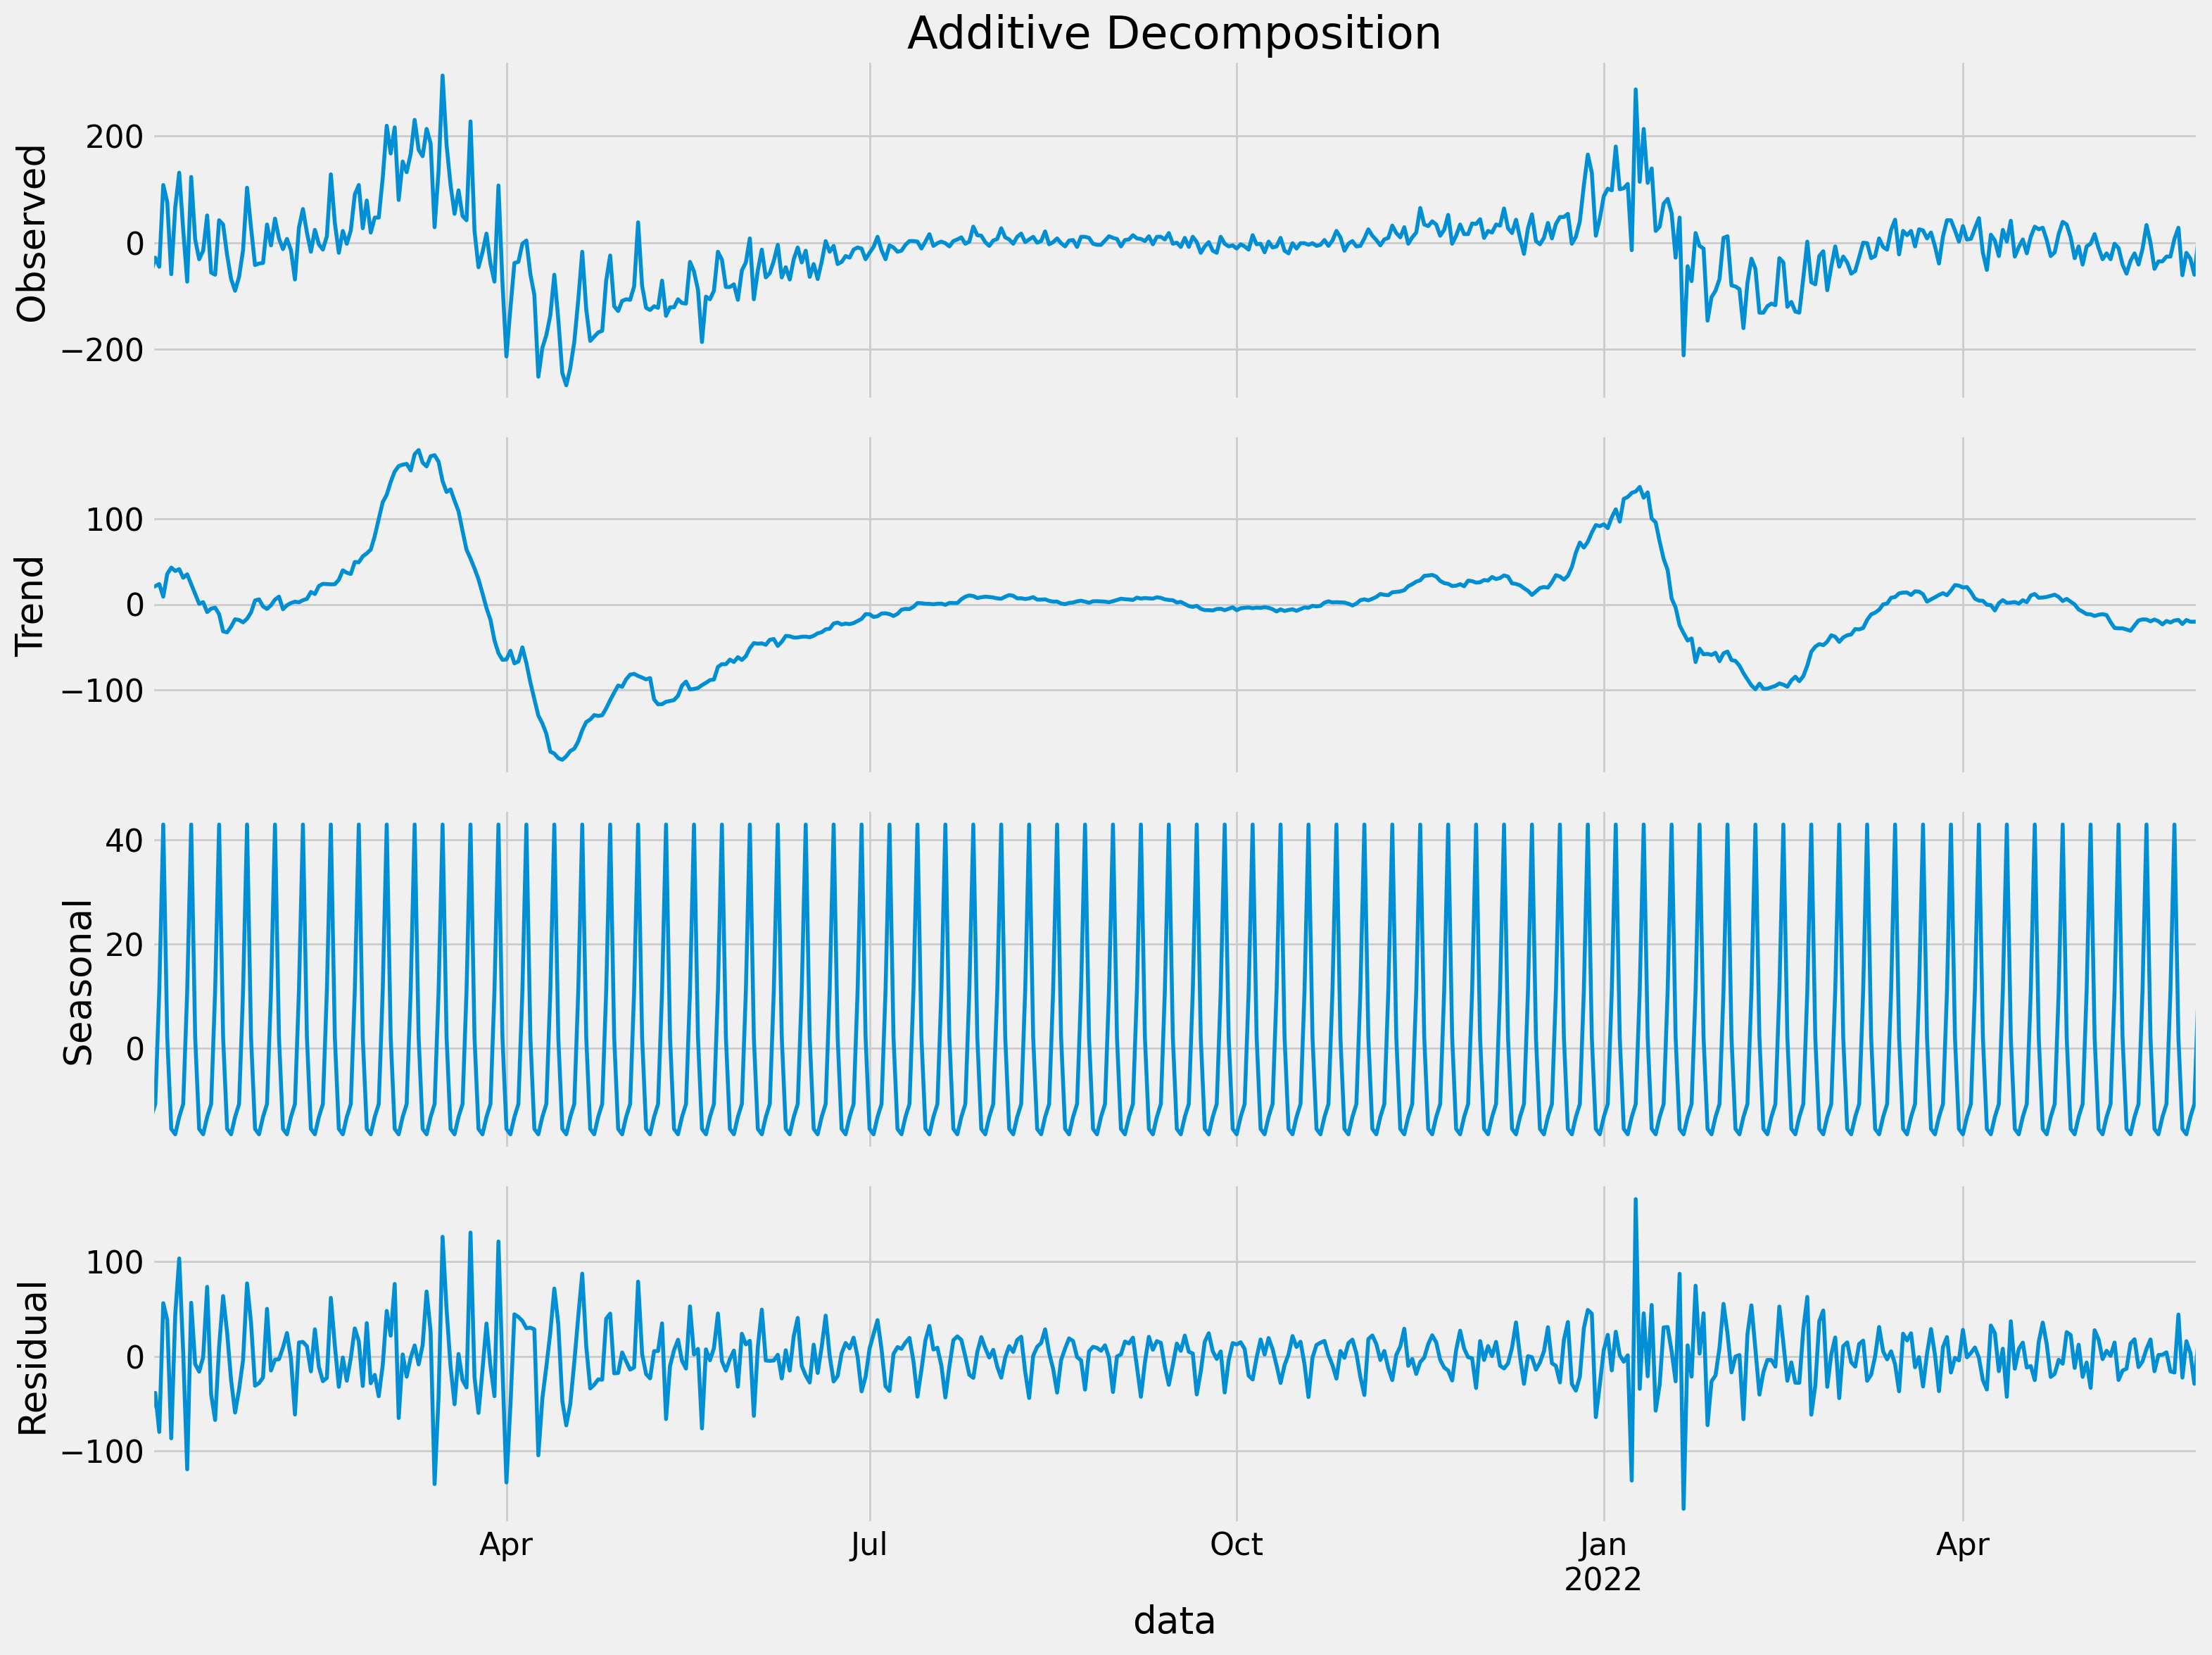

In [145]:
input  = ['nuovi_ospedalizzati', 'nuovi_positivi', 'nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_terapia_intensiva', 'vaccini']
decomposition_window, diff_window = 5, 7

# Get dataset
df = get_dataset(name='Lombardia', parser=parser)
df = df[:-1]
df = df[:'2022-05-30']

# Perform decomposition
plot_decomposition(df, column_name='nuovi_ospedalizzati', decomposition_type='additive')
df, seasonal = seasonal_decomposition(df, decomposition_window=5, decomposition_type='additive')

# Differentiate
df, input = input_differentiation(df, input, diff_window=diff_window)
df = df[(diff_window * 3 + decomposition_window - 1):]

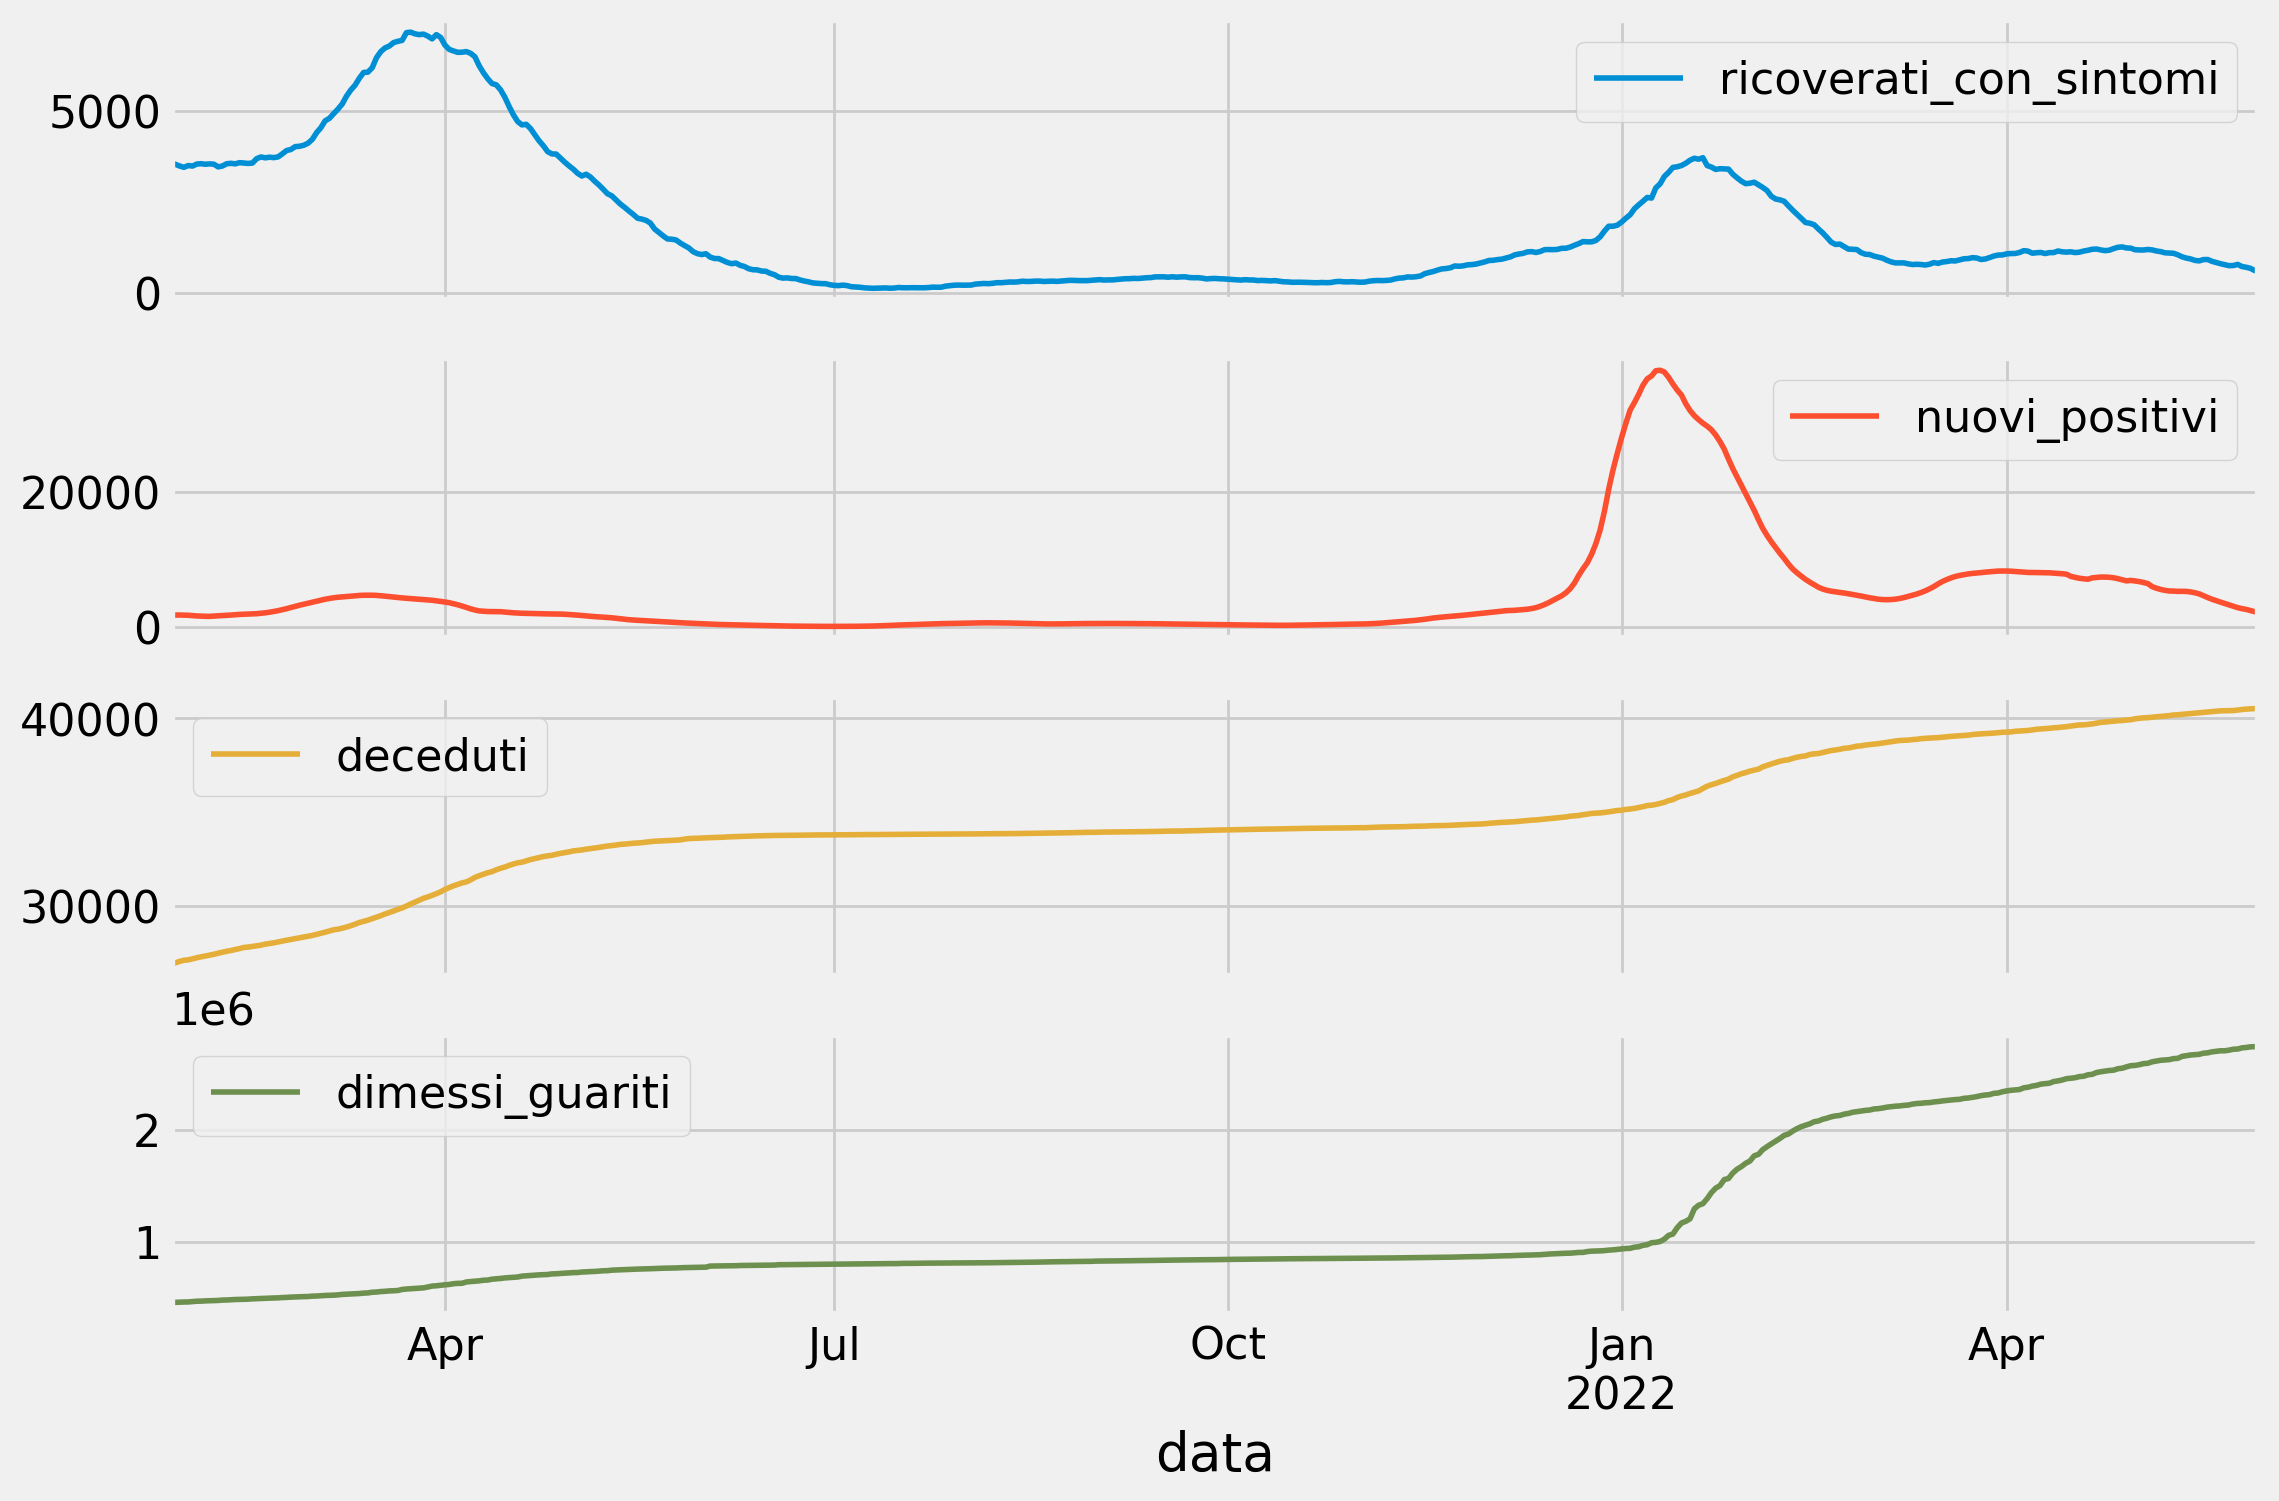

In [146]:
#Plot dataset
df[output].plot(subplots=True); 

# Define output for chosen model
output = ['nuovi_ospedalizzati', 'nuovi_deceduti']

# Define input for the model
diff_list = ['','_diff', '_diff2', '_diff3']
input = [out+diff for out in output for diff in diff_list]

Pre peak :  308 Peak :  42 Post peak training:  81 Post peak validation:  55
Total training :  389


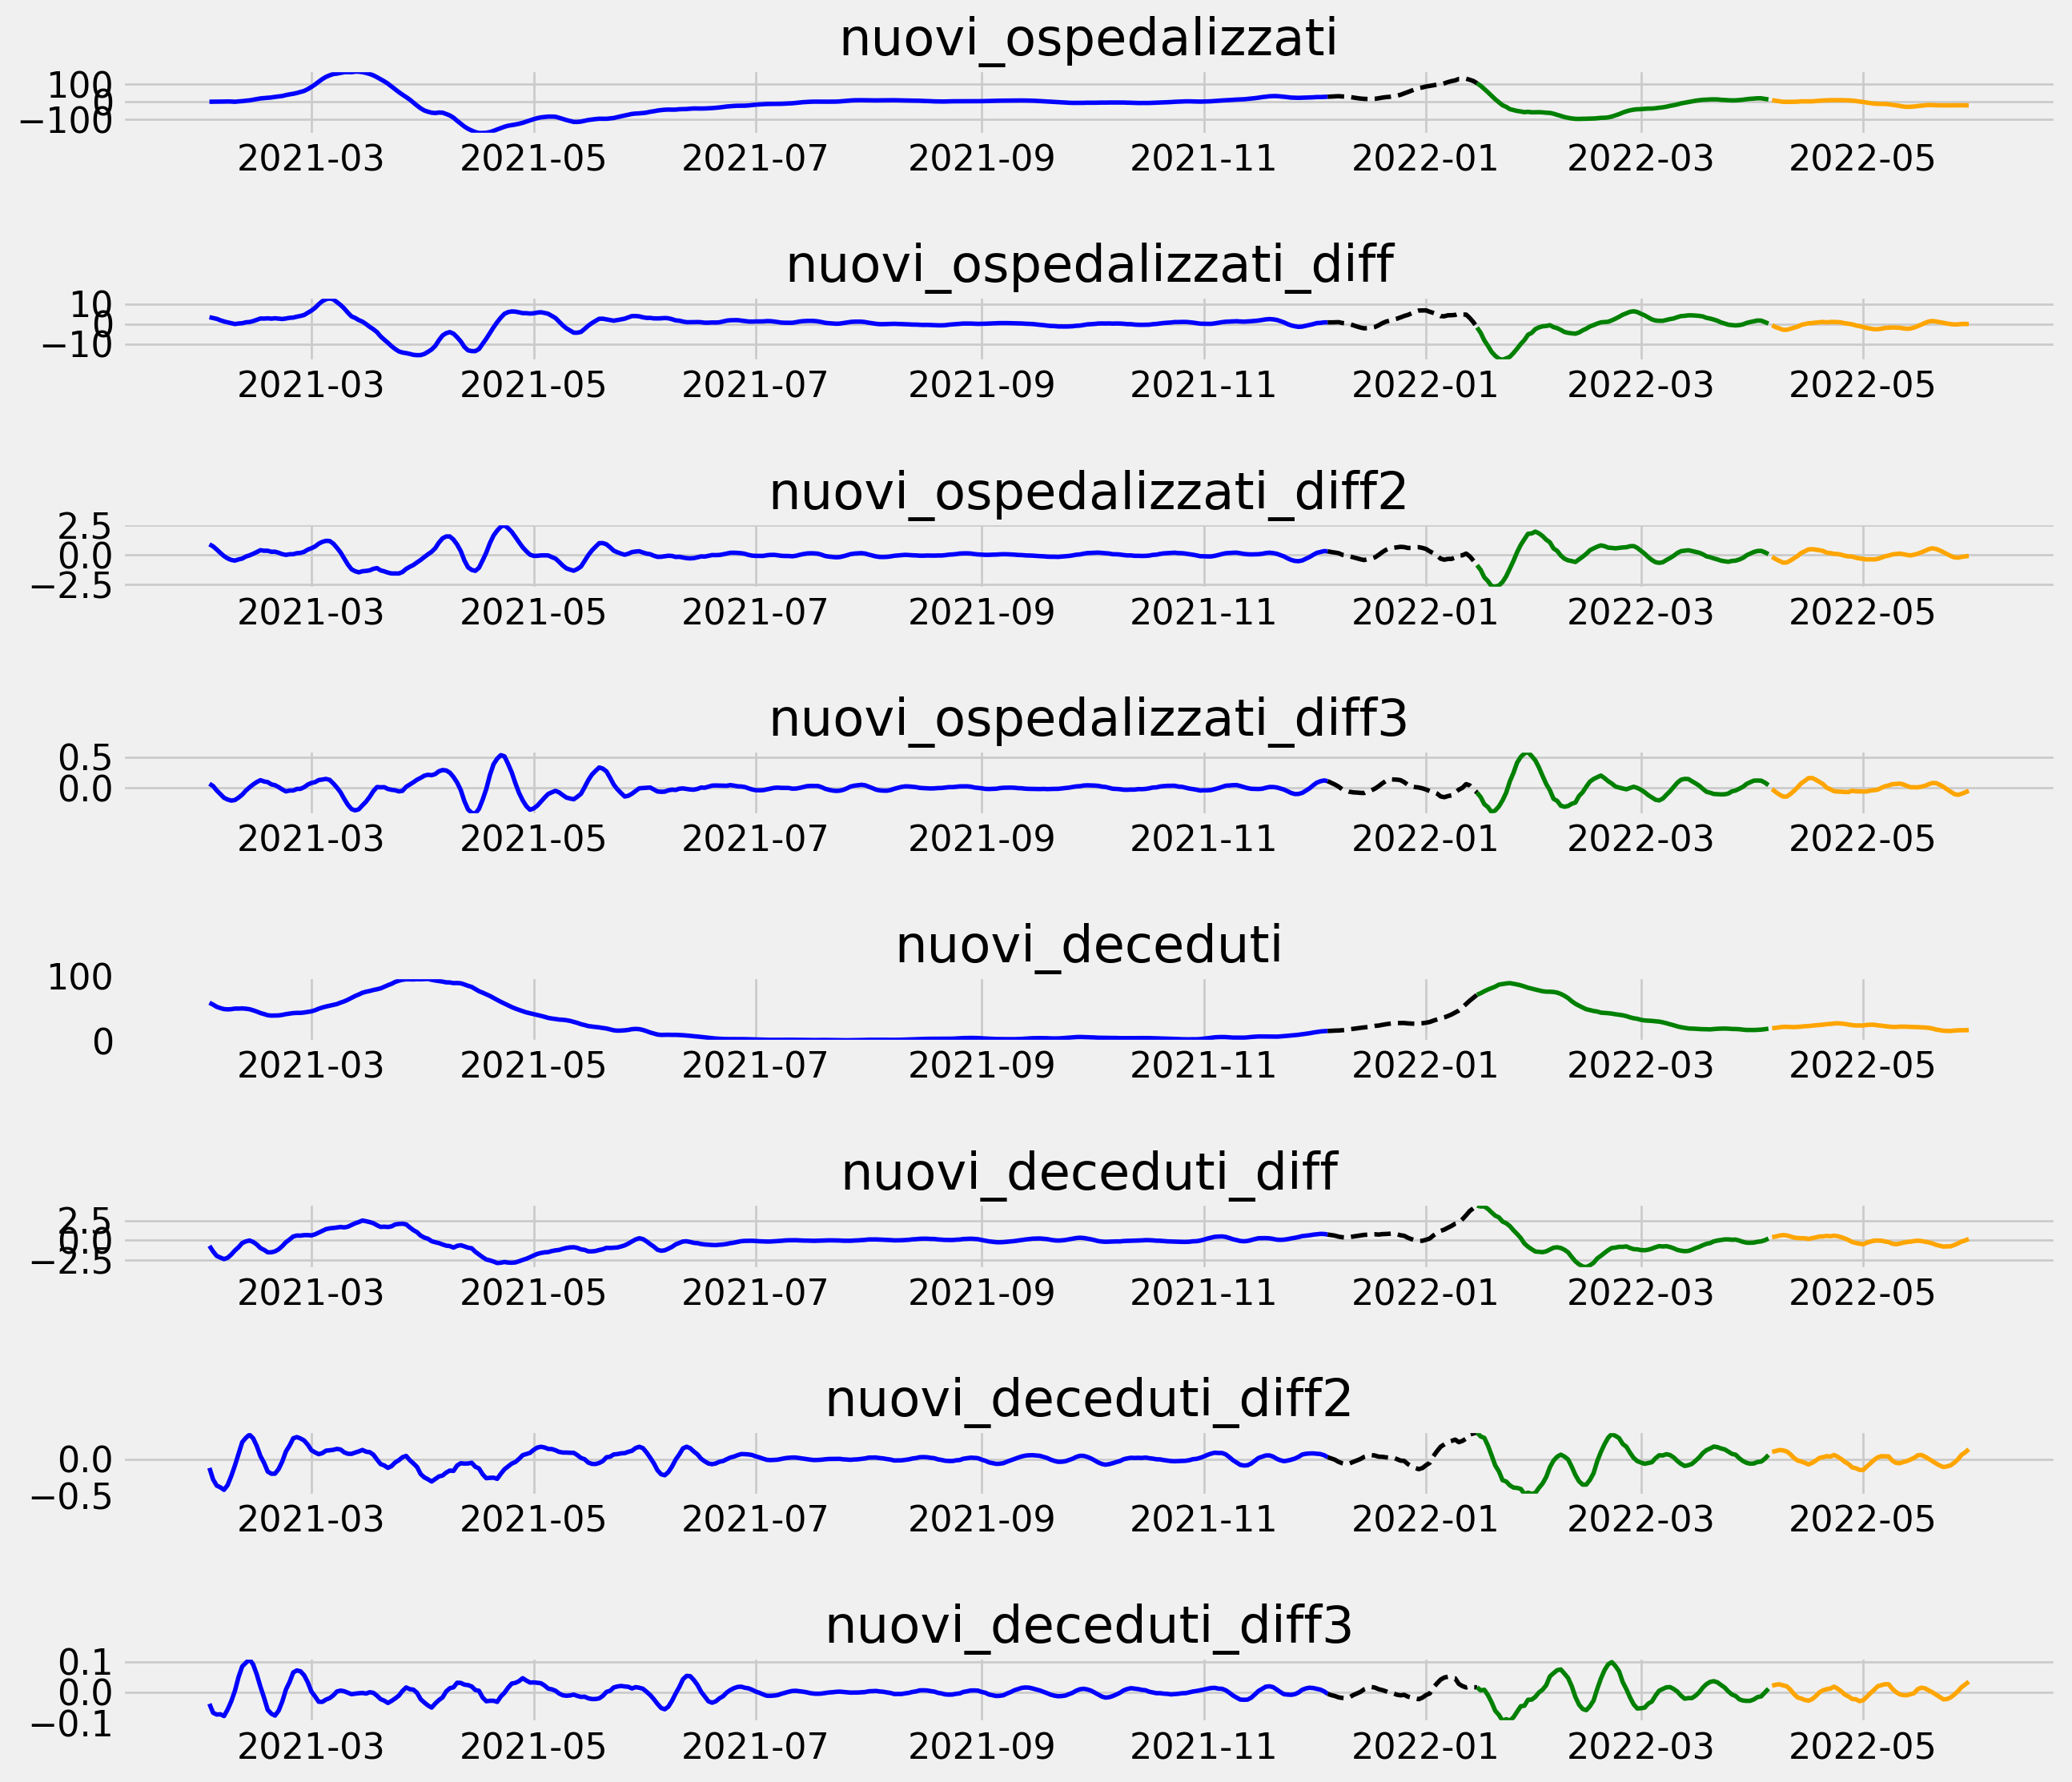

In [147]:
start, peak_start, peak_stop = '2021-02-01', '2021-12-05', '2022-01-15'
val_pct = 0.6

# Division in windows
pre_peak, peak, post_peak_t, post_peak_val = time_windows(df=df, start=start, 
                                                          peak_start=peak_start, 
                                                          peak_stop=peak_stop, 
                                                          val_pct=val_pct)

# Plot
plot_dataset_peak(pre_peak, peak, post_peak_t, post_peak_val)


# Standardize the dataset
train_data = pd.concat([pre_peak, post_peak_t])
train_mean = train_data.mean()
train_std = train_data.std()

pre_peak = (pre_peak - train_mean) / train_std
post_peak_t = (post_peak_t - train_mean) / train_std
post_peak_val = (post_peak_val - train_mean) / train_std

In [148]:
window_length, output_length = 14, 7

# Create dataset
x_train_pre_peak, y_train_pre_peak,   _ = windows_creation(pre_peak,      window_length=window_length, output_length=output_length, input=input, output=output)
x_train_post_peak, y_train_post_peak, _ = windows_creation(post_peak_t,   window_length=window_length, output_length=output_length, input=input, output=output)
x_val_windows, y_val_windows, val_date  = windows_creation(post_peak_val, window_length=window_length, output_length=output_length, input=input, output=output)

# Concatenate different windows
x_train, y_train = np.concatenate([x_train_pre_peak, x_train_post_peak]), np.concatenate([y_train_pre_peak, y_train_post_peak])

# Resample
x_train, y_train = resample(x_train, y_train, coefficient=3)

### Example of NN

In [149]:
# Example of model

lombardia_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'),

    tf.keras.layers.Dense(units=len(output), activation='linear'),
])



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)
  
RLO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.7,
    patience=10, verbose=0,
    mode="auto", min_delta=0.0001,
    cooldown=0, min_lr=0
  )

compile(lombardia_model)


history = lombardia_model.fit(x=x_train, y=y_train,  epochs=MAX_EPOCHS,
                      validation_data=(x_val_windows,y_val_windows ),
                      callbacks=[early_stopping, RLO], shuffle = True, batch_size=16)

Epoch 1/1000
63/63 [==============================] - 6s 20ms/step - loss: 0.4722 - mean_absolute_error: 0.5140 - val_loss: 0.0257 - val_mean_absolute_error: 0.1414 - lr: 0.0010
Epoch 2/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.2810 - mean_absolute_error: 0.3989 - val_loss: 0.0532 - val_mean_absolute_error: 0.1960 - lr: 0.0010
Epoch 3/1000
63/63 [==============================] - 1s 12ms/step - loss: 0.2007 - mean_absolute_error: 0.3363 - val_loss: 0.1000 - val_mean_absolute_error: 0.2775 - lr: 0.0010
Epoch 4/1000
63/63 [==============================] - 1s 10ms/step - loss: 0.1660 - mean_absolute_error: 0.3056 - val_loss: 0.1028 - val_mean_absolute_error: 0.2824 - lr: 0.0010
Epoch 5/1000
63/63 [==============================] - 0s 8ms/step - loss: 0.1402 - mean_absolute_error: 0.2824 - val_loss: 0.1523 - val_mean_absolute_error: 0.3534 - lr: 0.0010
Epoch 6/1000
63/63 [==============================] - 1s 10ms/step - loss: 0.1370 - mean_absolute_error: 0.2753 

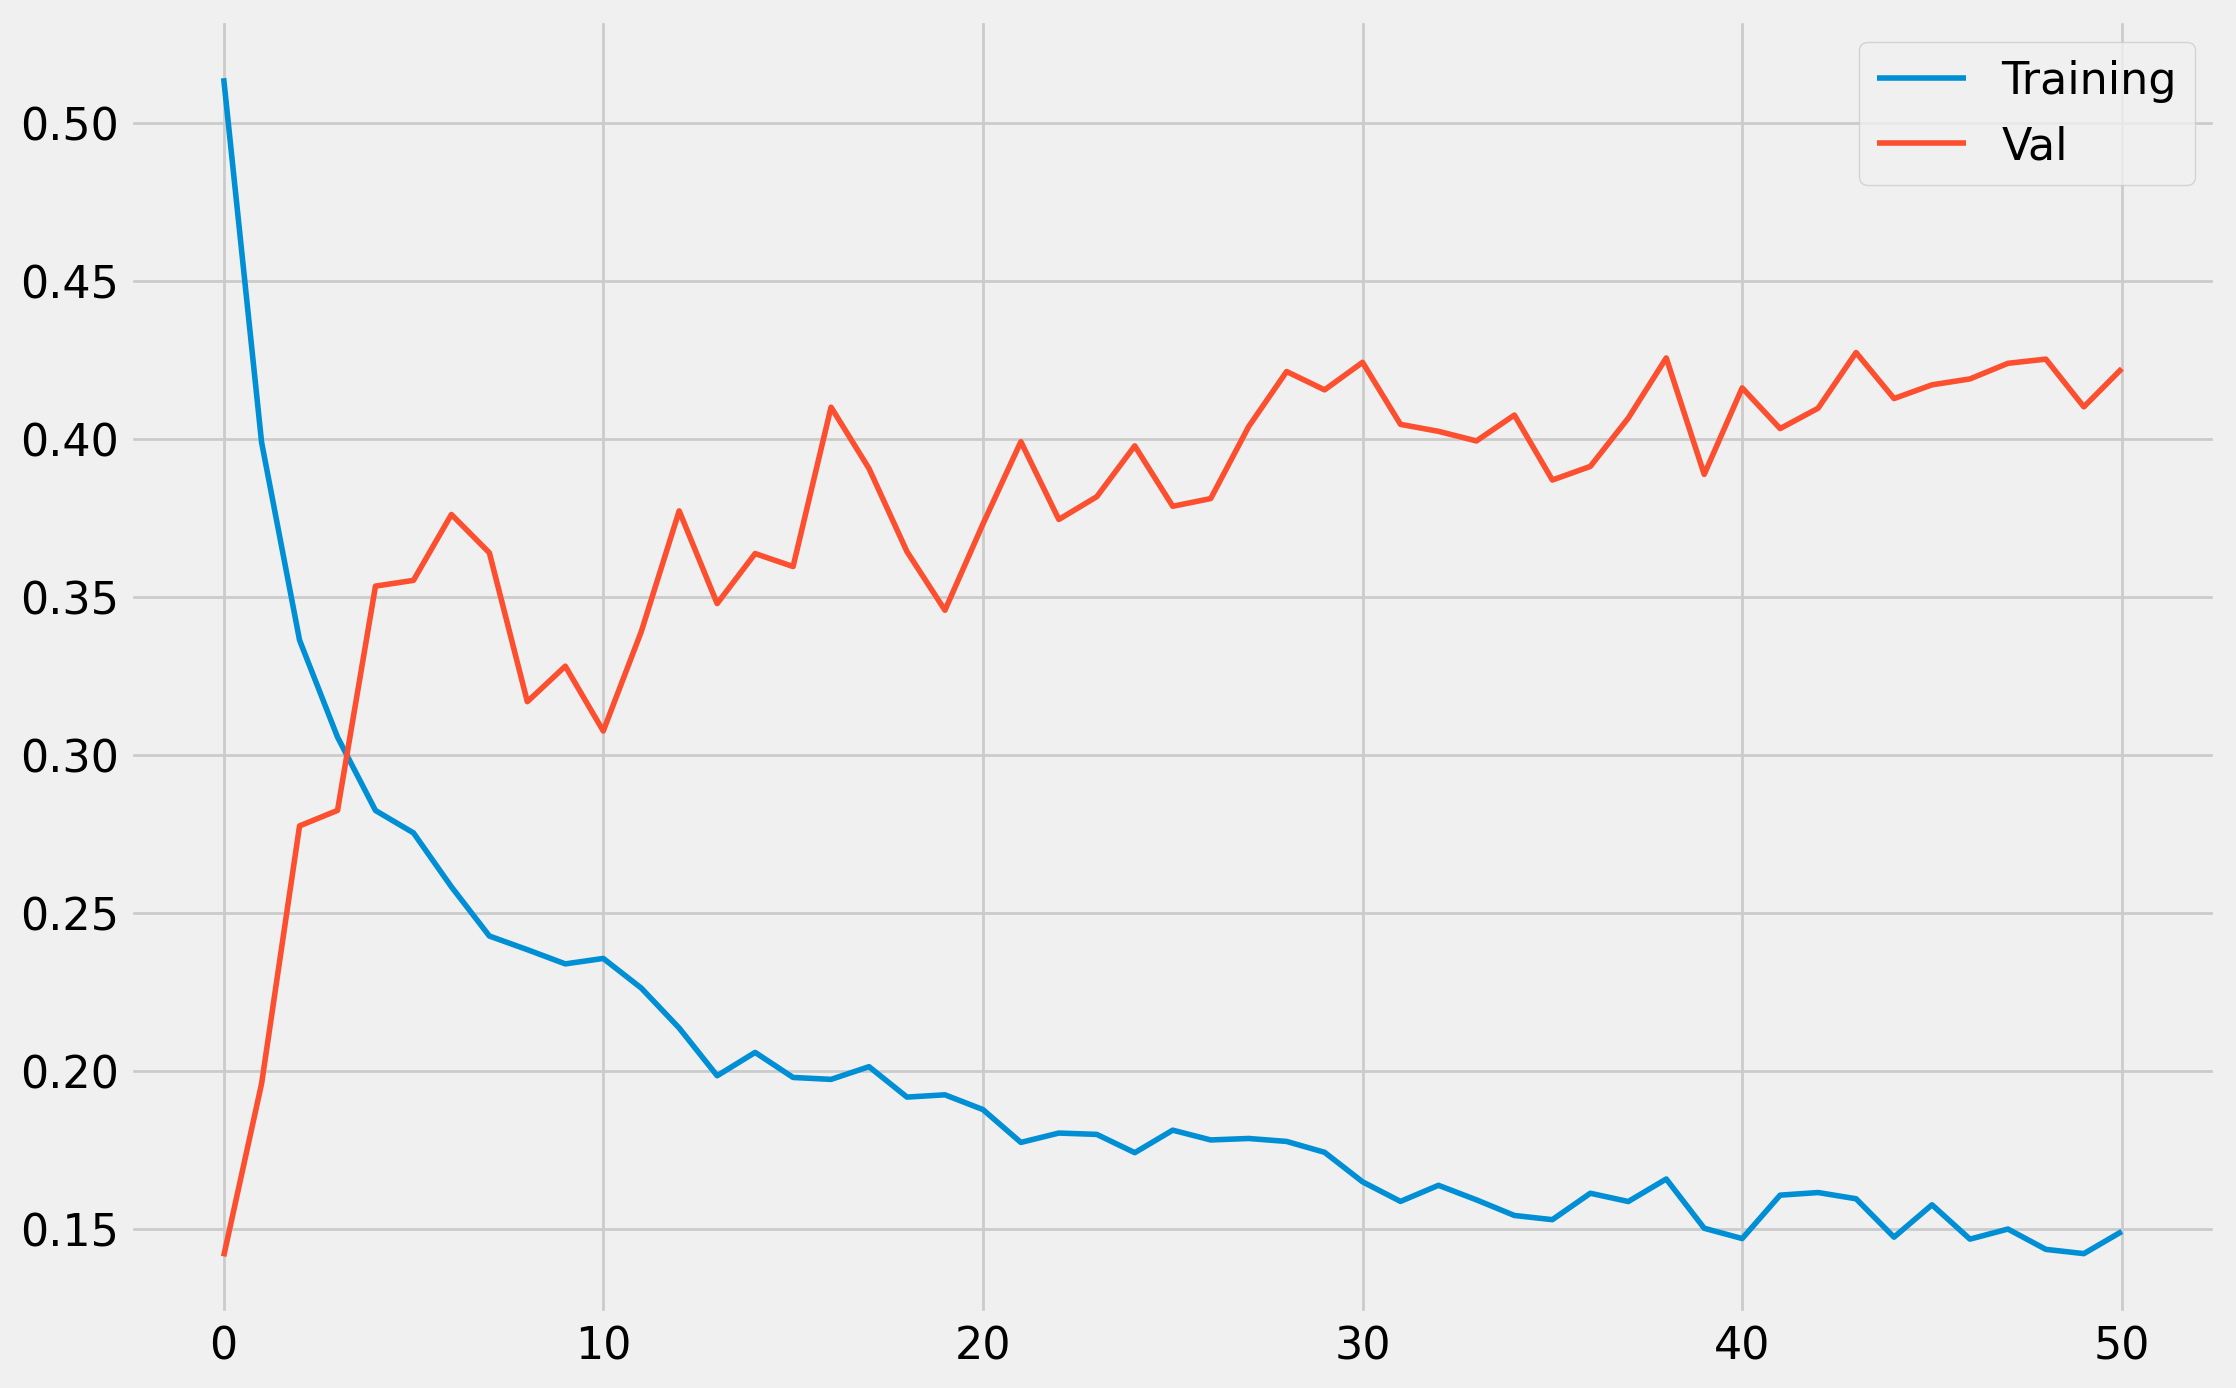

In [150]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['Training', 'Val']);

In [151]:
lombardia_model.evaluate(x_val_windows, y_val_windows, batch_size=16)

3/3 [==============================] - 0s 7ms/step - loss: 0.0257 - mean_absolute_error: 0.1414


[0.025681335479021072, 0.14136497676372528]

<Figure size 1600x800 with 0 Axes>

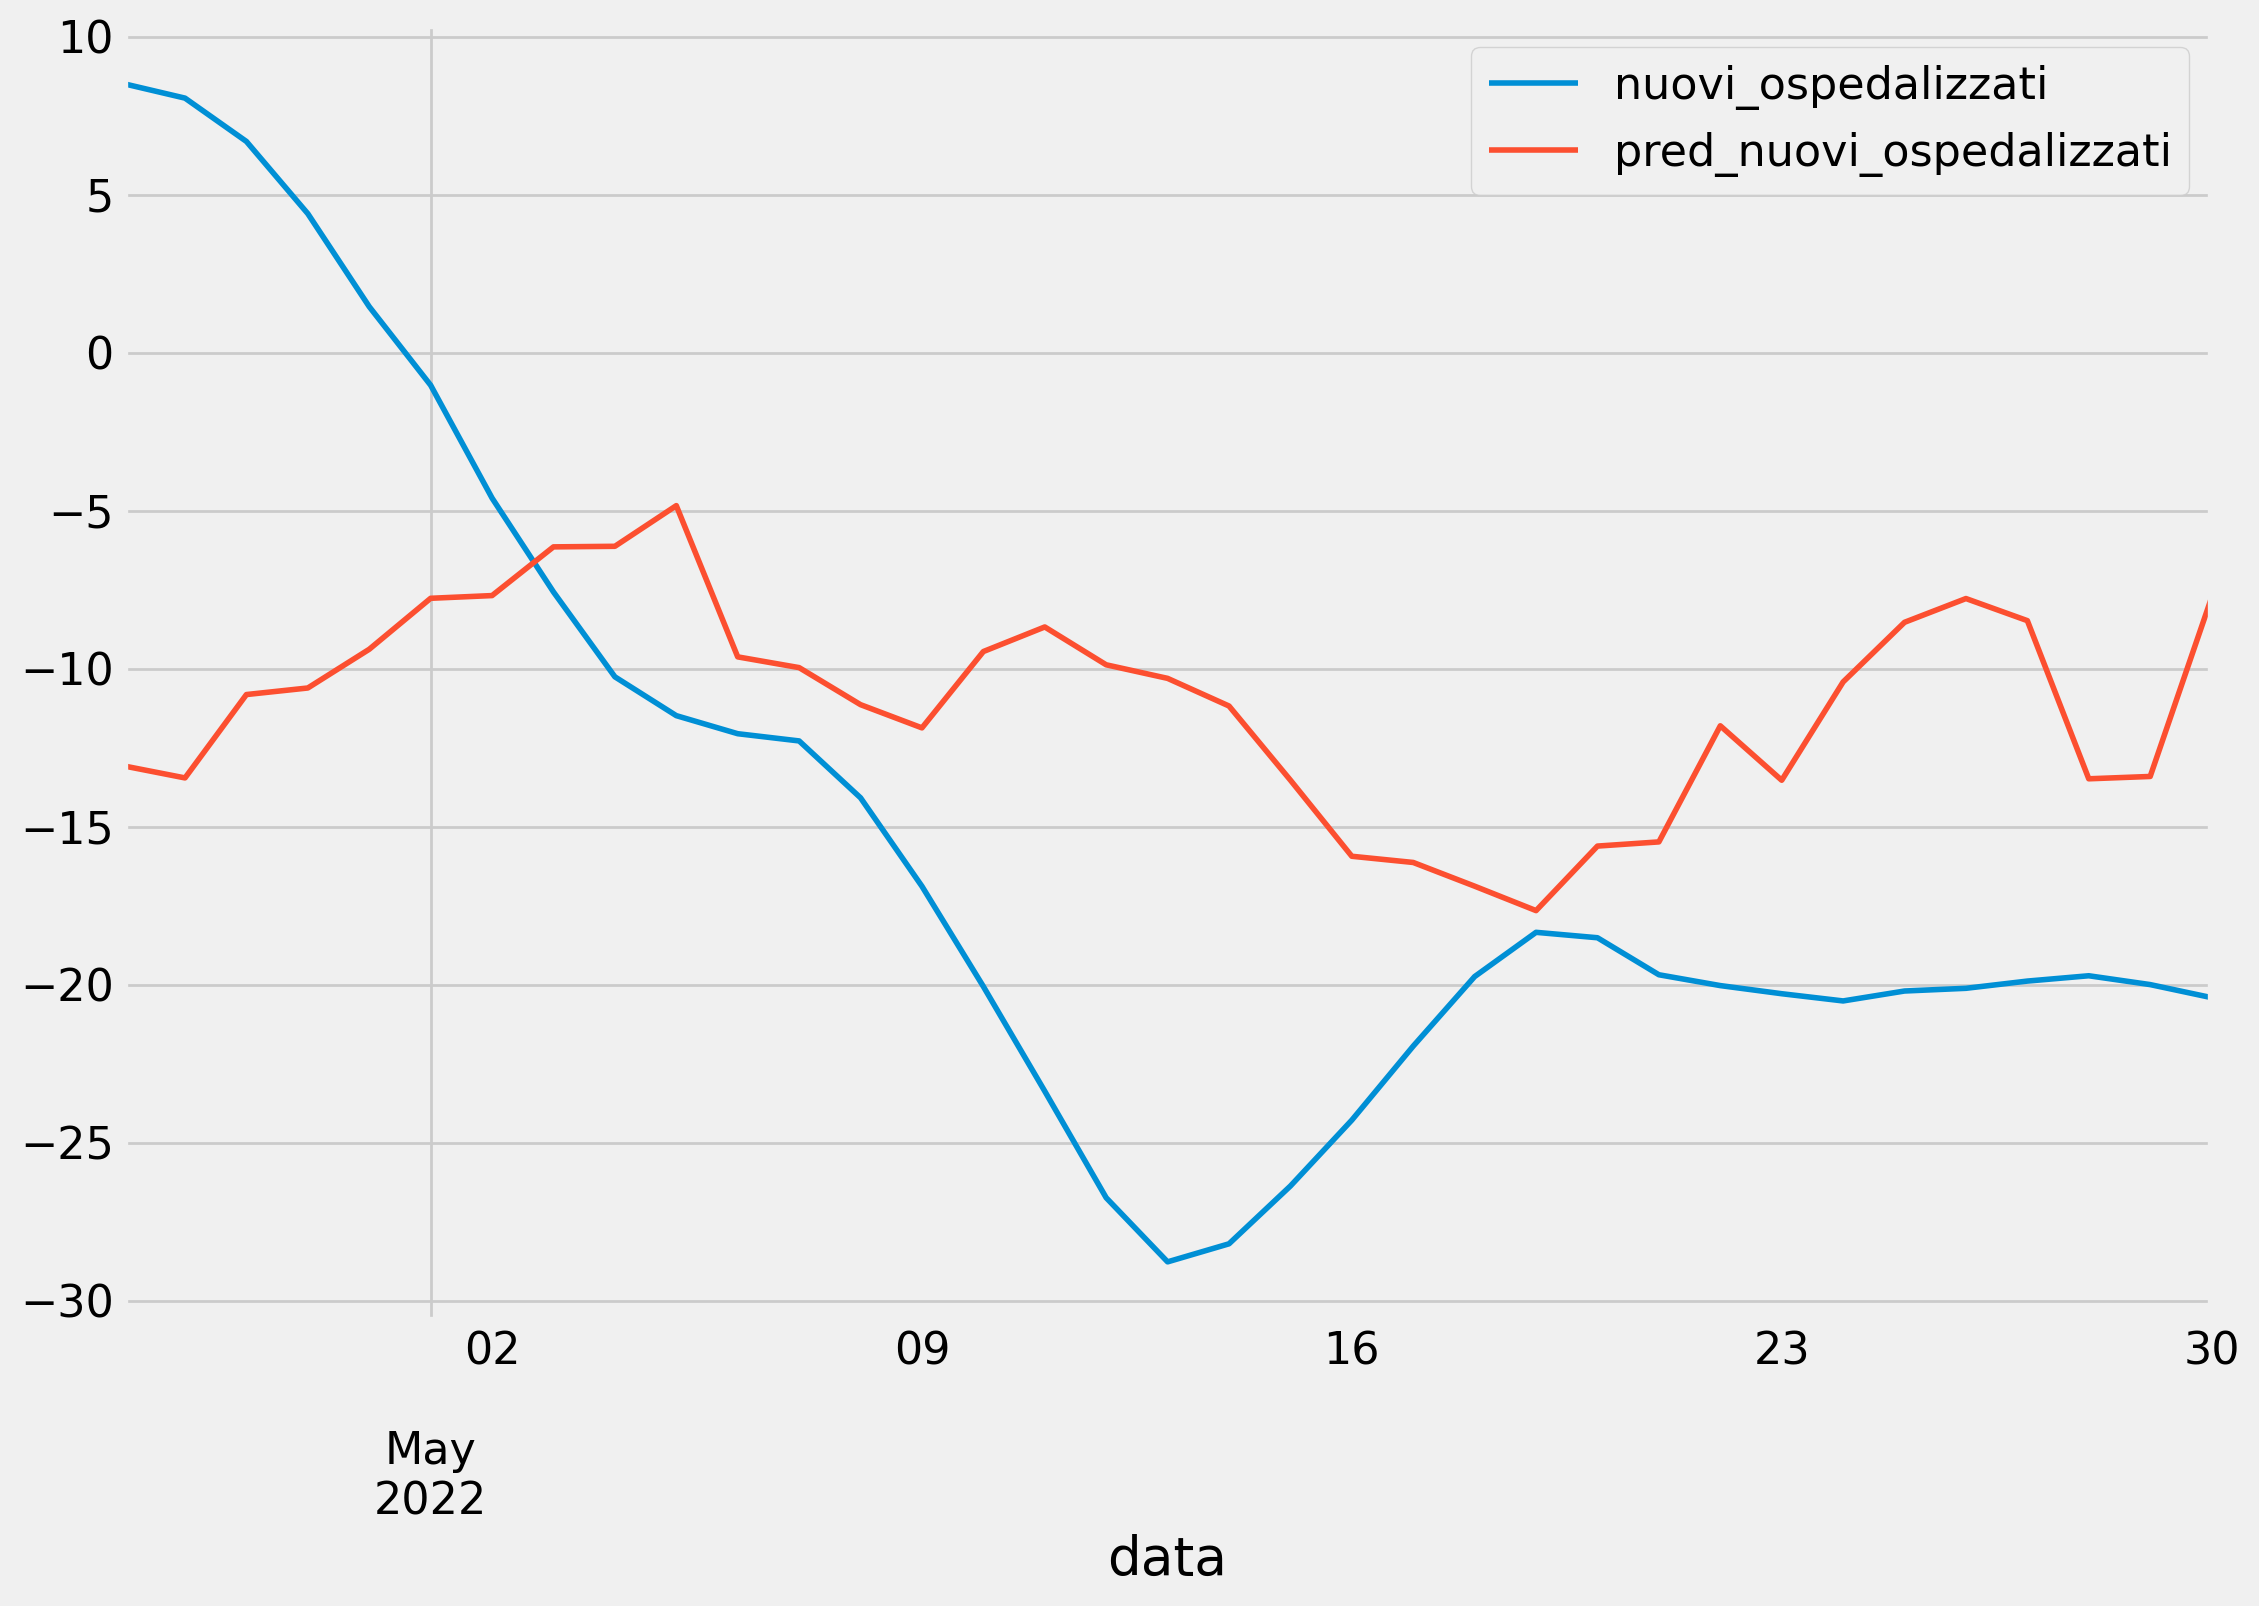

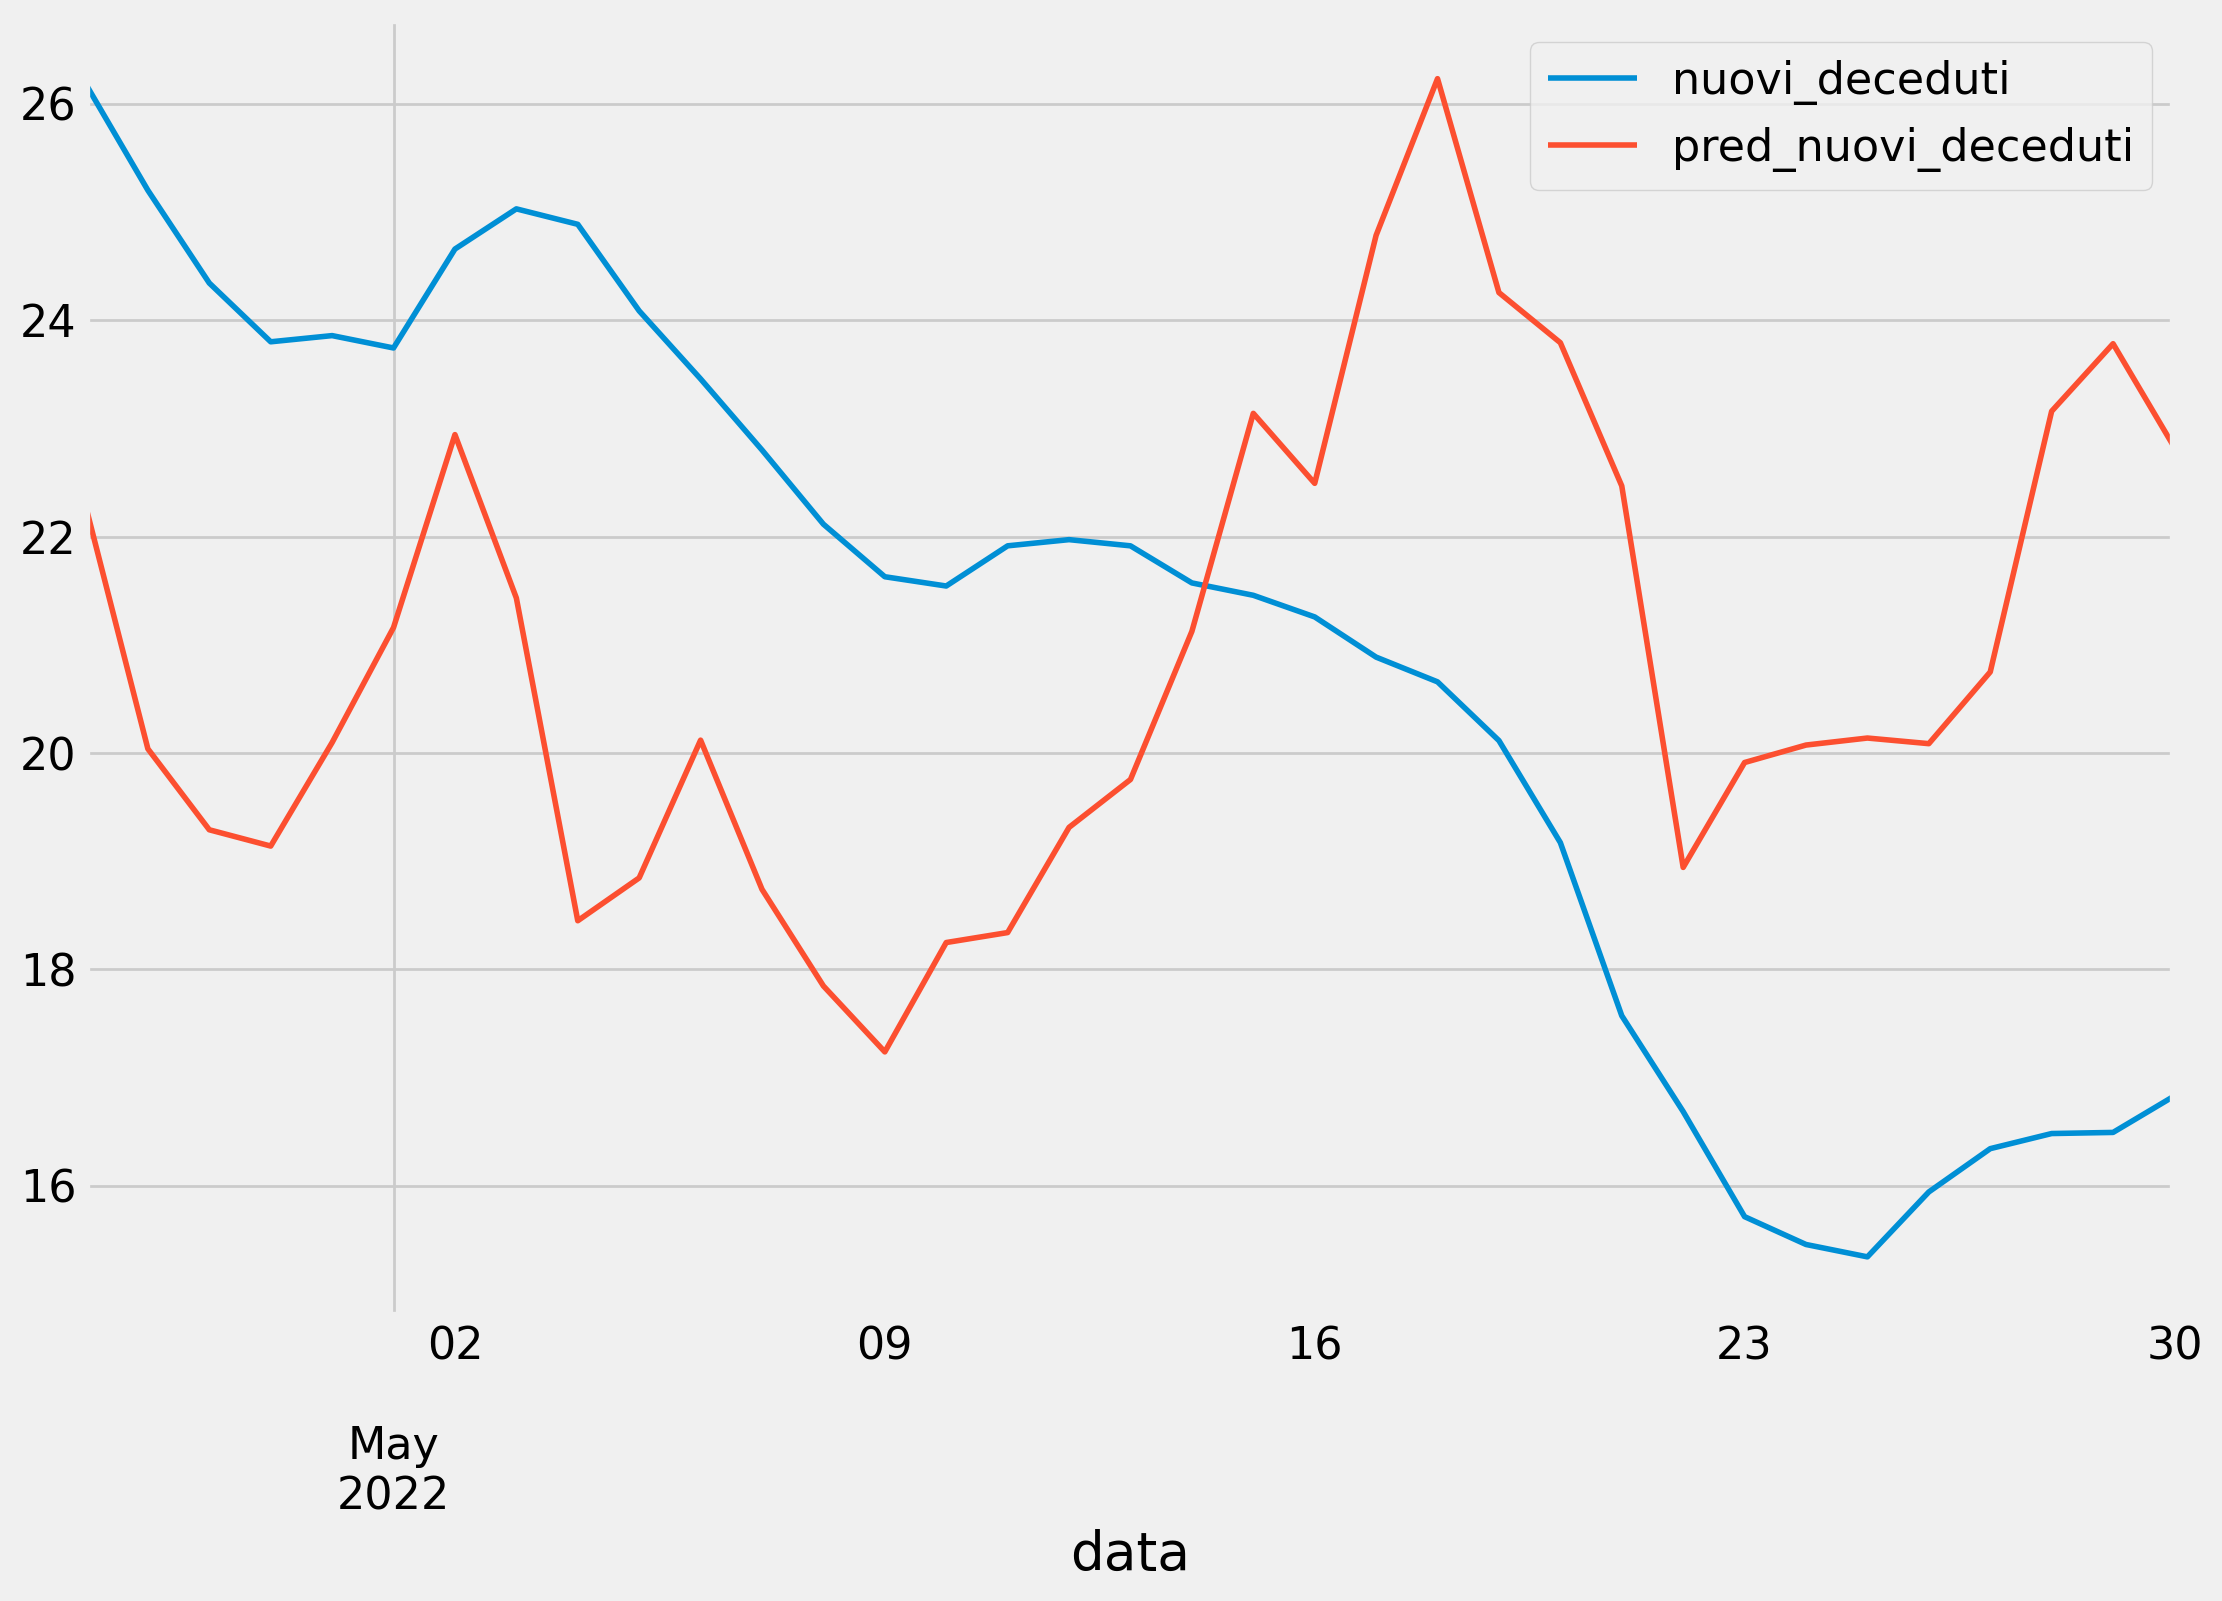

In [152]:
lombardia_pred = lombardia_model.predict(x_val_windows)
lombardia_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

plt.figure(figsize=(16,8));

for ind, out in enumerate(output):
  lombardia_ref['pred_'+out] = lombardia_pred[:,ind]
  lombardia_ref[[out, 'pred_'+out]] = lombardia_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  lombardia_ref[[out, 'pred_'+out]].plot();

### Combination of models

<Figure size 1600x800 with 0 Axes>

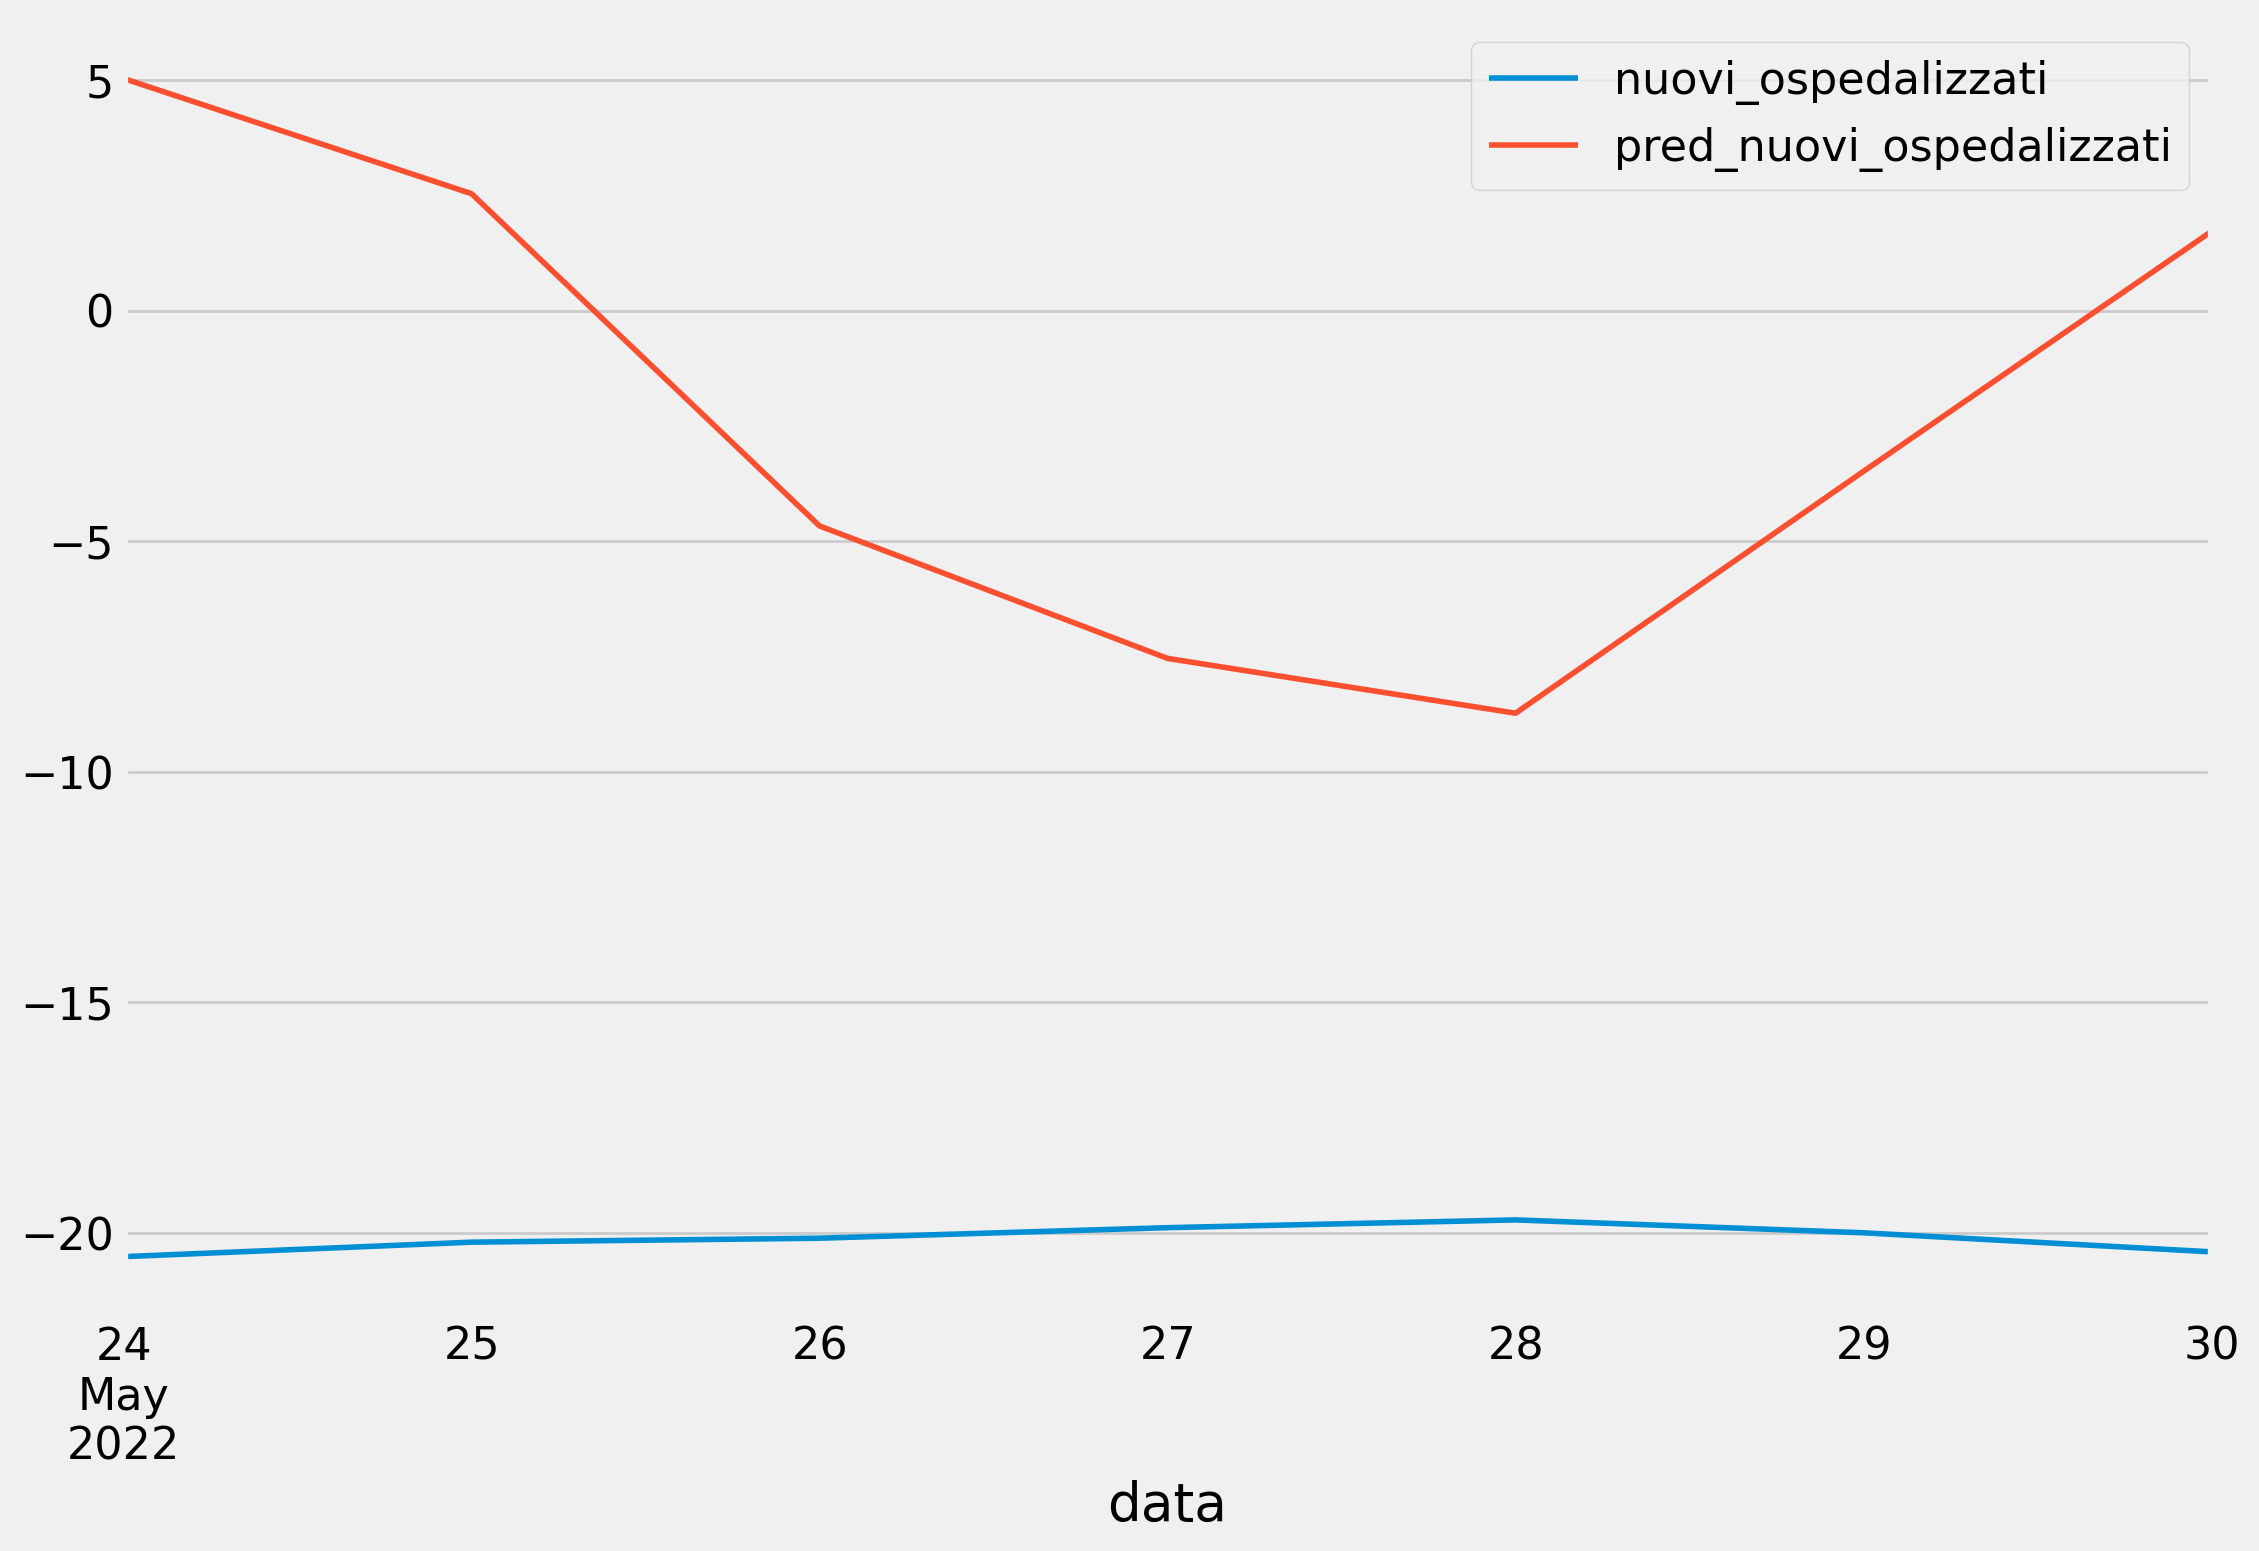

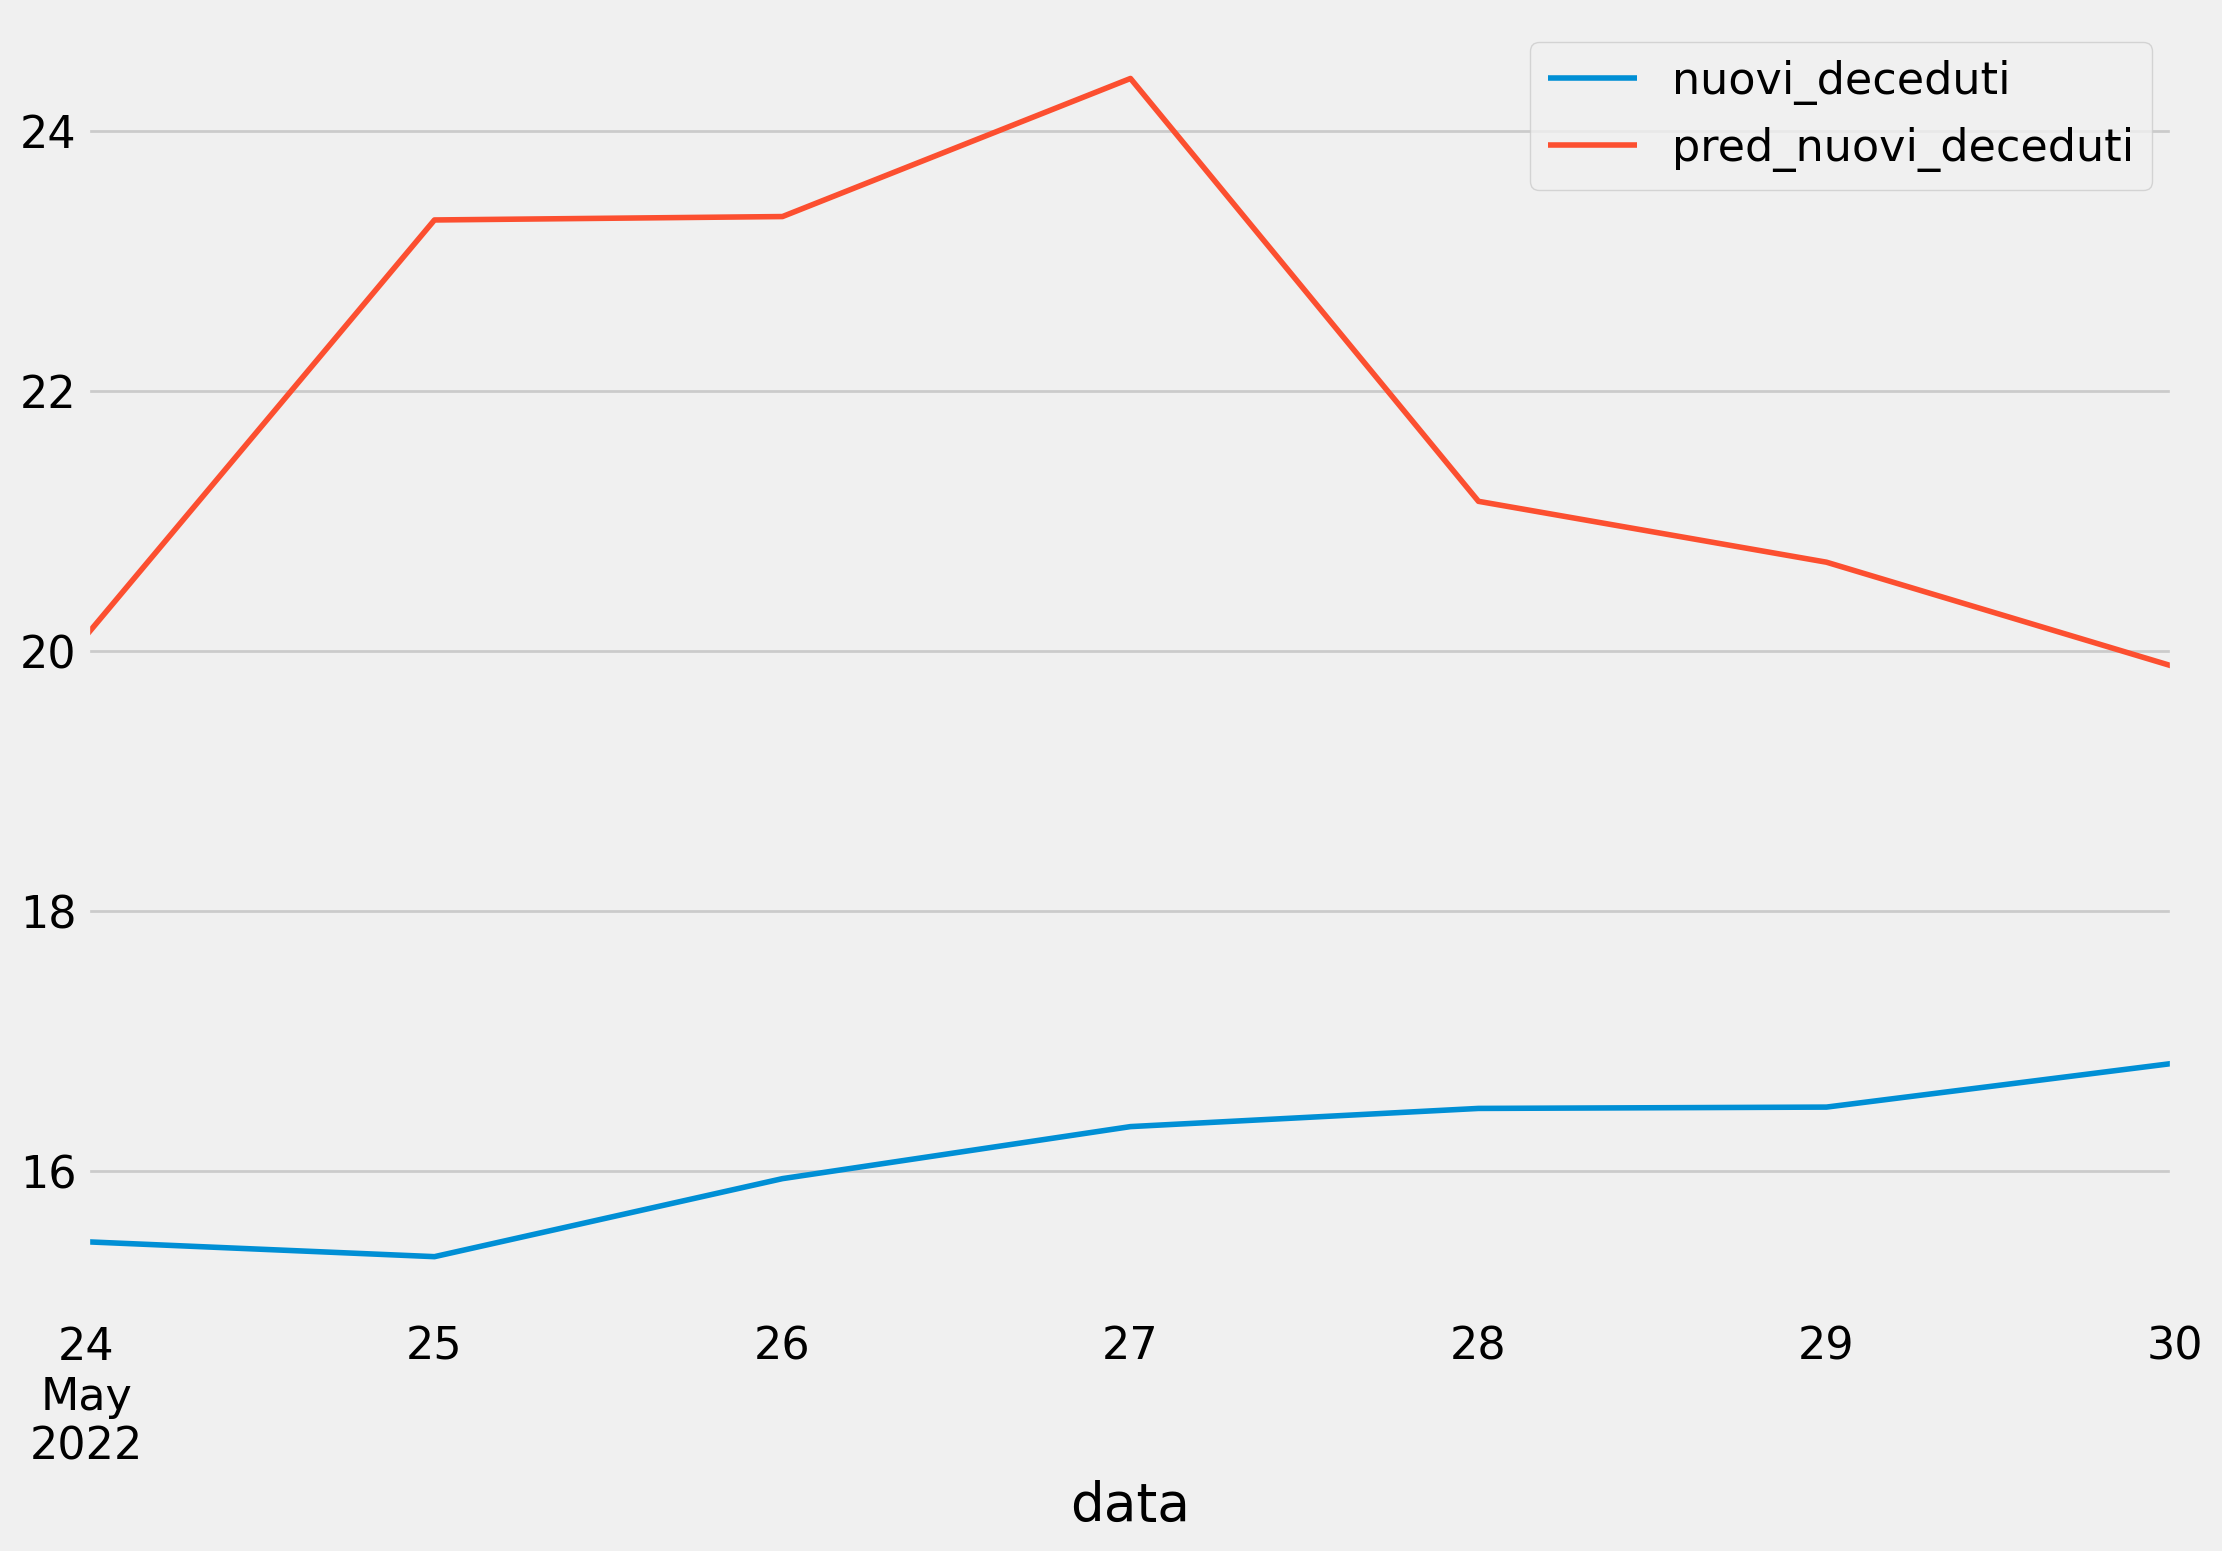

In [153]:
model1 = tf.keras.models.load_model('lombardia_deceduti_ospedalizzati_0.1003057')
model2 = model1#tf.keras.models.load_model('lombardia_deceduti_ospedalizzati_0.1142338')

lombardia_pred = (model1.predict(x_val_windows)  + model1.predict(x_val_windows)) / 2
lombardia_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

def denormalize(value, name):
  return value * train_std[name] + train_mean[name]

plt.figure(figsize=(16,8));
plt.subplot
for ind, out in enumerate(output):
  lombardia_ref['pred_'+out] = lombardia_pred[:,ind]
  lombardia_ref[[out, 'pred_'+out]] = lombardia_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  lombardia_ref[[out, 'pred_'+out]]['2022-05-24':'2022-05-30'].plot();

In [155]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(lombardia_ref[output]['2022-05-24':'2022-05-30'].values, lombardia_ref[['pred_'+out for out in output]]['2022-05-24':'2022-05-30'].values)

11.835086040470038

## Test

In [156]:
lombardia_x_test = post_peak_val[input].values[-14:]
lombardia_test_df = create_submmission(lombardia_x_test, 'Lombardia', model1, model2, seasonal, output=output)
lombardia_test_df.set_index('region', inplace=True)

ospedalizzati, deceduti = 'totale_ospedalizzati', 'deceduti'

base_output = [ospedalizzati, deceduti]
base_df = post_peak_val[base_output].iloc[-1:]

for out in base_output:
  base_df[[out]] = base_df[[out]].apply(denormalize, raw=True, **{'name':out})

[[ 0.21965083 -0.16475056]]
['nuovi_ospedalizzati', 'nuovi_deceduti']


In [157]:
final_output = ['hospitalized', 'deceased']
lombardia_test_df['hospitalized'] = (base_df[['totale_ospedalizzati']].values[0,0] + lombardia_test_df[['nuovi_ospedalizzati']].values[0,0])
lombardia_test_df['deceased'] = (base_df[['deceduti']].values[0,0] + lombardia_test_df[['nuovi_deceduti']].values[0,0])

In [158]:
lombardia_test_df[final_output]

hospitalized      deceased
region                               
Lombardia    661.332872  40560.750872

## Final Result

In [159]:
lombardia_test_df['newinfections'] = 0
lombardia_test_df['recovered'] = 0

In [160]:
final_output = ['hospitalized', 'deceased', 'newinfections','recovered']
lombardia_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                         
Lombardia    661.332872  40560.750872              0          0

# Lazio

### NN ospedalizzati deceduti

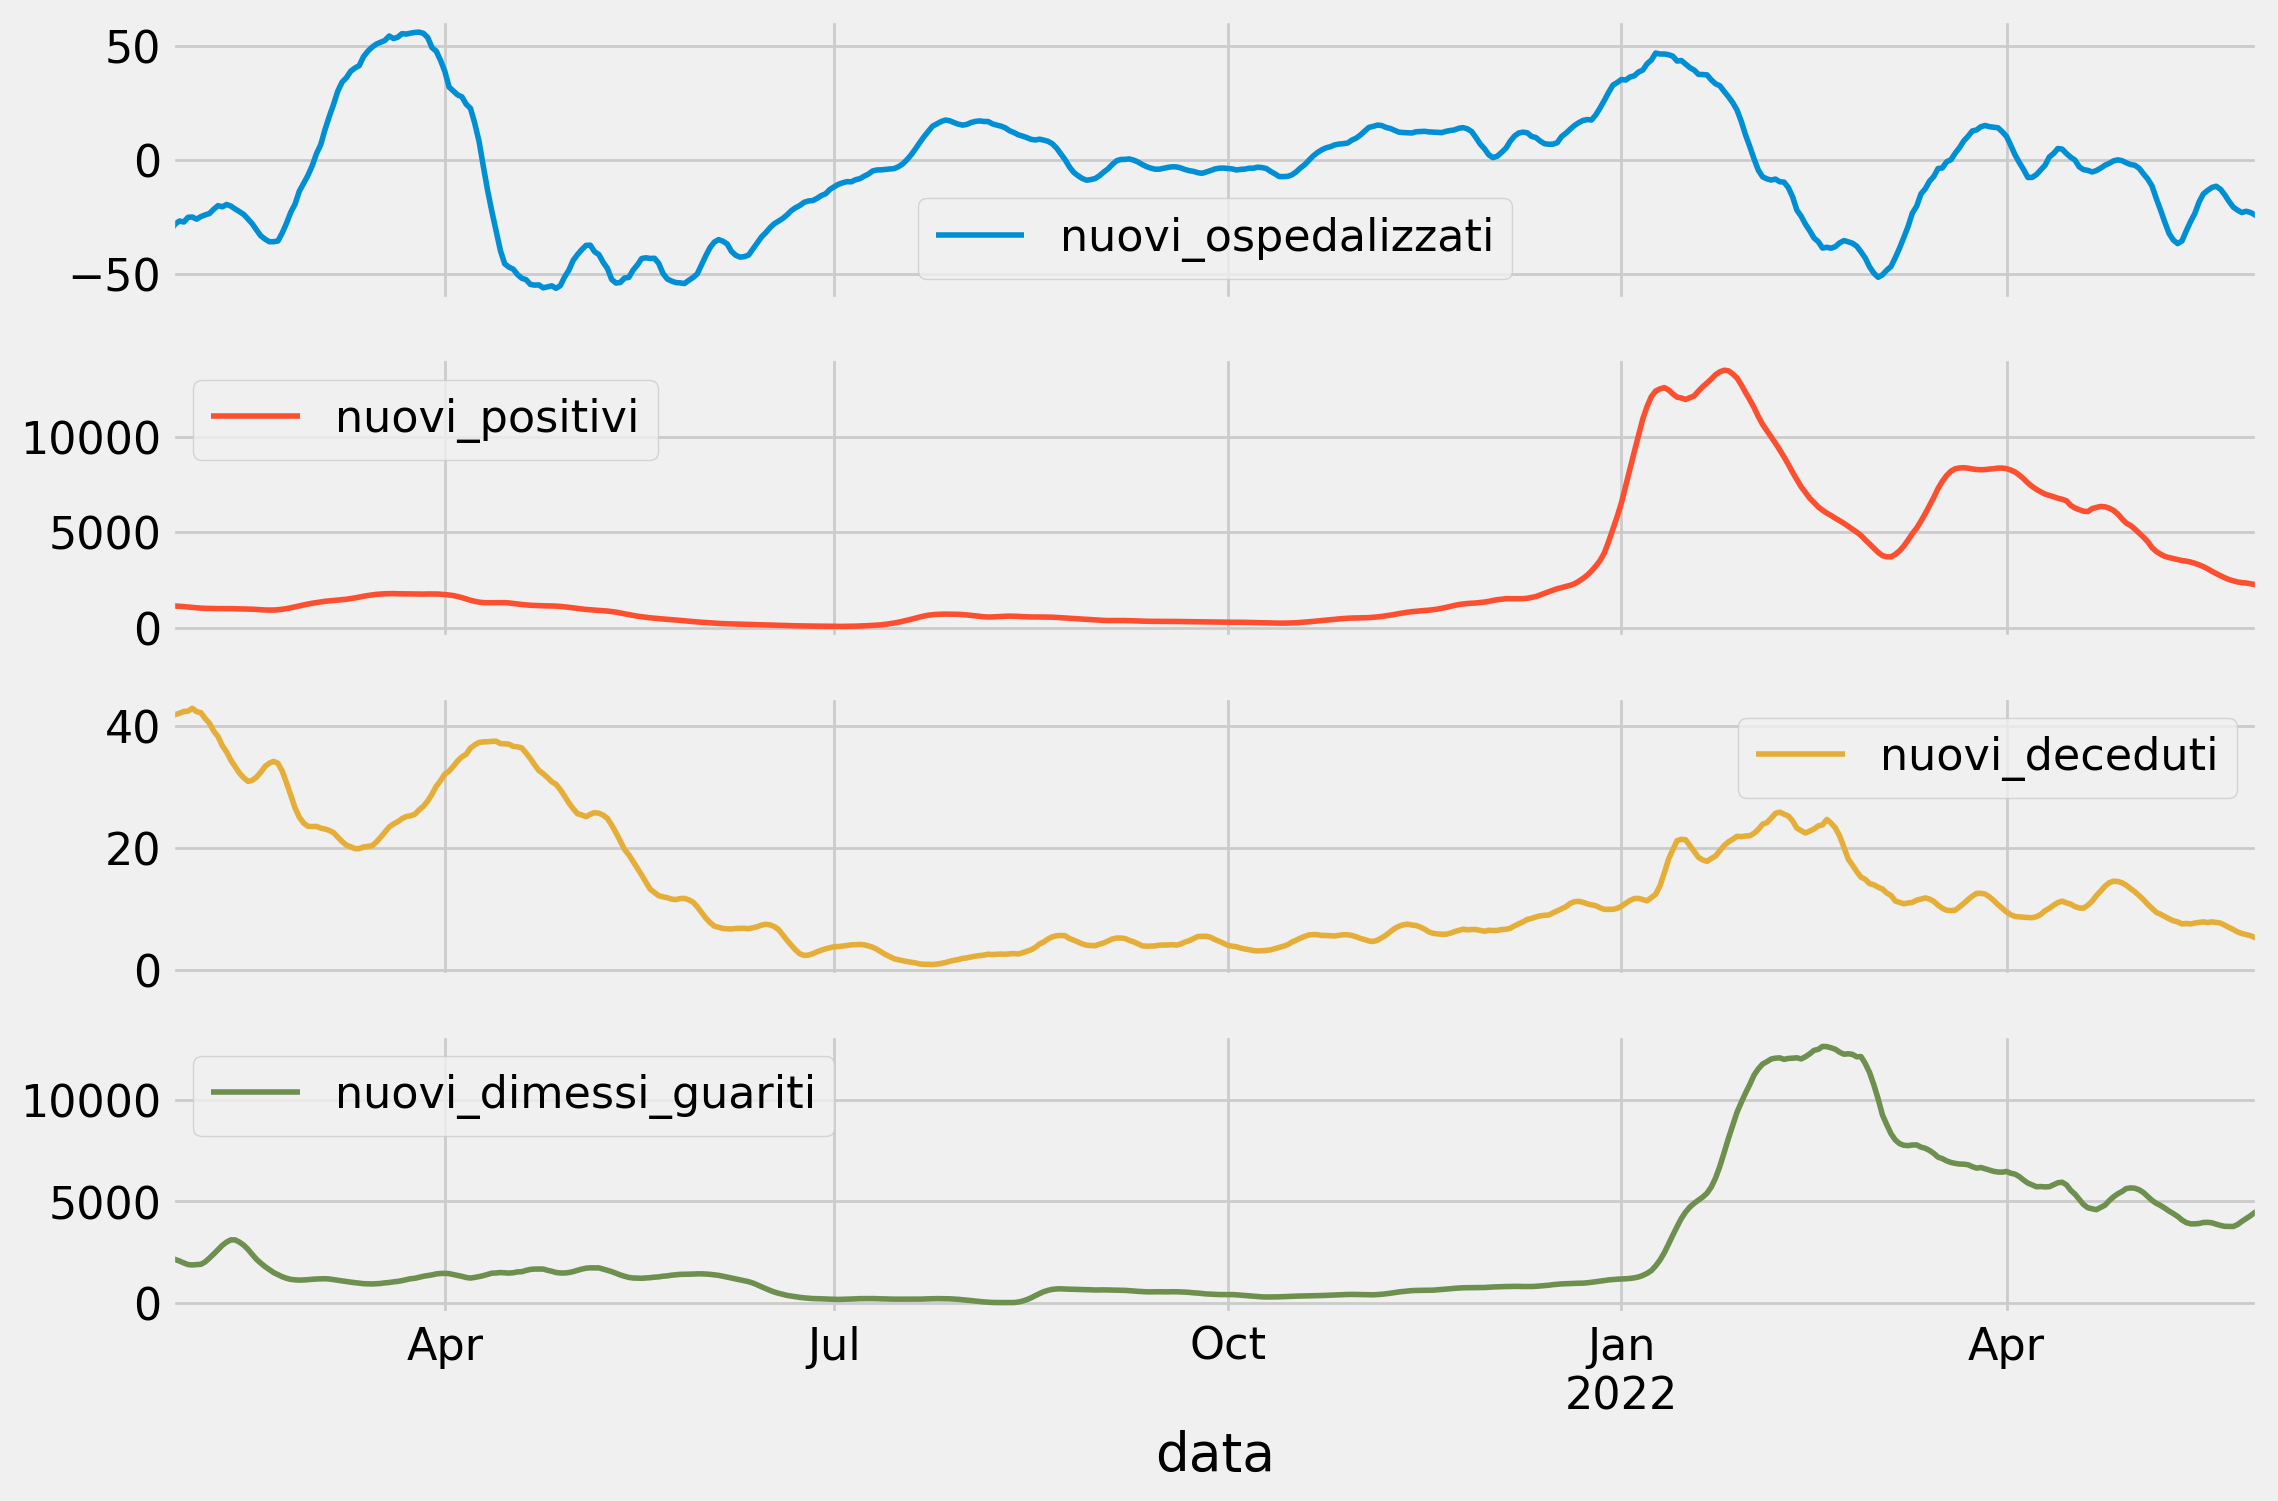

In [161]:
df = parser.region_dict['Lazio'].copy()
input  = ['nuovi_ospedalizzati', 'nuovi_positivi', 'nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_terapia_intensiva', 'vaccini']
output = ['nuovi_ospedalizzati', 'nuovi_positivi', 'nuovi_deceduti', 'nuovi_dimessi_guariti']
df[['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 'nuovi_ospedalizzati','nuovi_ricoverati','nuovi_terapia_intensiva']] = df[['deceduti', 'dimessi_guariti', 'tamponi','totale_ospedalizzati','ricoverati_con_sintomi','terapia_intensiva']].diff()
df.head()

df.rename(columns = {'totale':'vaccini'}, inplace = True)
df[['vaccini']] = df[['vaccini']].cumsum()
seasonal = pd.DataFrame()

noise = pd.DataFrame()
# Trend extraction
df = df['2021-01-02':]
df = df[:-1]
df = df[:'2022-05-30']
for name in ['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 'nuovi_ospedalizzati','nuovi_ricoverati','nuovi_terapia_intensiva','nuovi_positivi']:
  seasonal[[name]] = seasonal_decompose(df[[name]], model='additive', extrapolate_trend='freq').seasonal
  df[[name]] = seasonal_decompose(df[[name]], model='additive', extrapolate_trend='freq').trend.rolling(window=5).mean()
  

#df[['nuovi_positivi']] = df[['nuovi_positivi']].pct_change()
vel = []
for name in input:
  new = name+'_diff'
  new2 = name+'_diff2'
  new3 = name+'_diff3'
  vel.append(new)
  vel.append(new2)
  vel.append(new3)
  df[[new]] = df[[name]].diff().rolling(window=7).mean()
  df[[new2]] = df[[new]].diff().rolling(window=7).mean()
  df[[new3]] = df[[new2]].diff().rolling(window=7).mean()

input = input + vel
df = df[25:]

df[df.isna().any(axis=1)]

df[output].plot(subplots=True); 

In [162]:
output = ['nuovi_ospedalizzati', 'nuovi_deceduti']#['nuovi_positivi', 'nuovi_dimessi_guariti']#

orig_input = ['nuovi_ospedalizzati',
 'nuovi_positivi',
 'nuovi_deceduti',
 'nuovi_dimessi_guariti',
 'nuovi_terapia_intensiva',
 'vaccini',
 'nuovi_ospedalizzati_diff',
 'nuovi_ospedalizzati_diff2',
 'nuovi_ospedalizzati_diff3',
 'nuovi_positivi_diff',
 'nuovi_positivi_diff2',
 'nuovi_positivi_diff3',
 'nuovi_deceduti_diff',
 'nuovi_deceduti_diff2',
 'nuovi_deceduti_diff3',
 'nuovi_dimessi_guariti_diff',
 'nuovi_dimessi_guariti_diff2',
 'nuovi_dimessi_guariti_diff3',
 'nuovi_terapia_intensiva_diff',
 'nuovi_terapia_intensiva_diff2',
 'nuovi_terapia_intensiva_diff3',
 'vaccini_diff',
 'vaccini_diff2',
 'vaccini_diff3']

diff_list = ['','_diff', '_diff2', '_diff3']
input = [out+diff for out in output for diff in diff_list]



Pre peak :  313 Peak :  42 Post peak :  68.0
Total df :  449


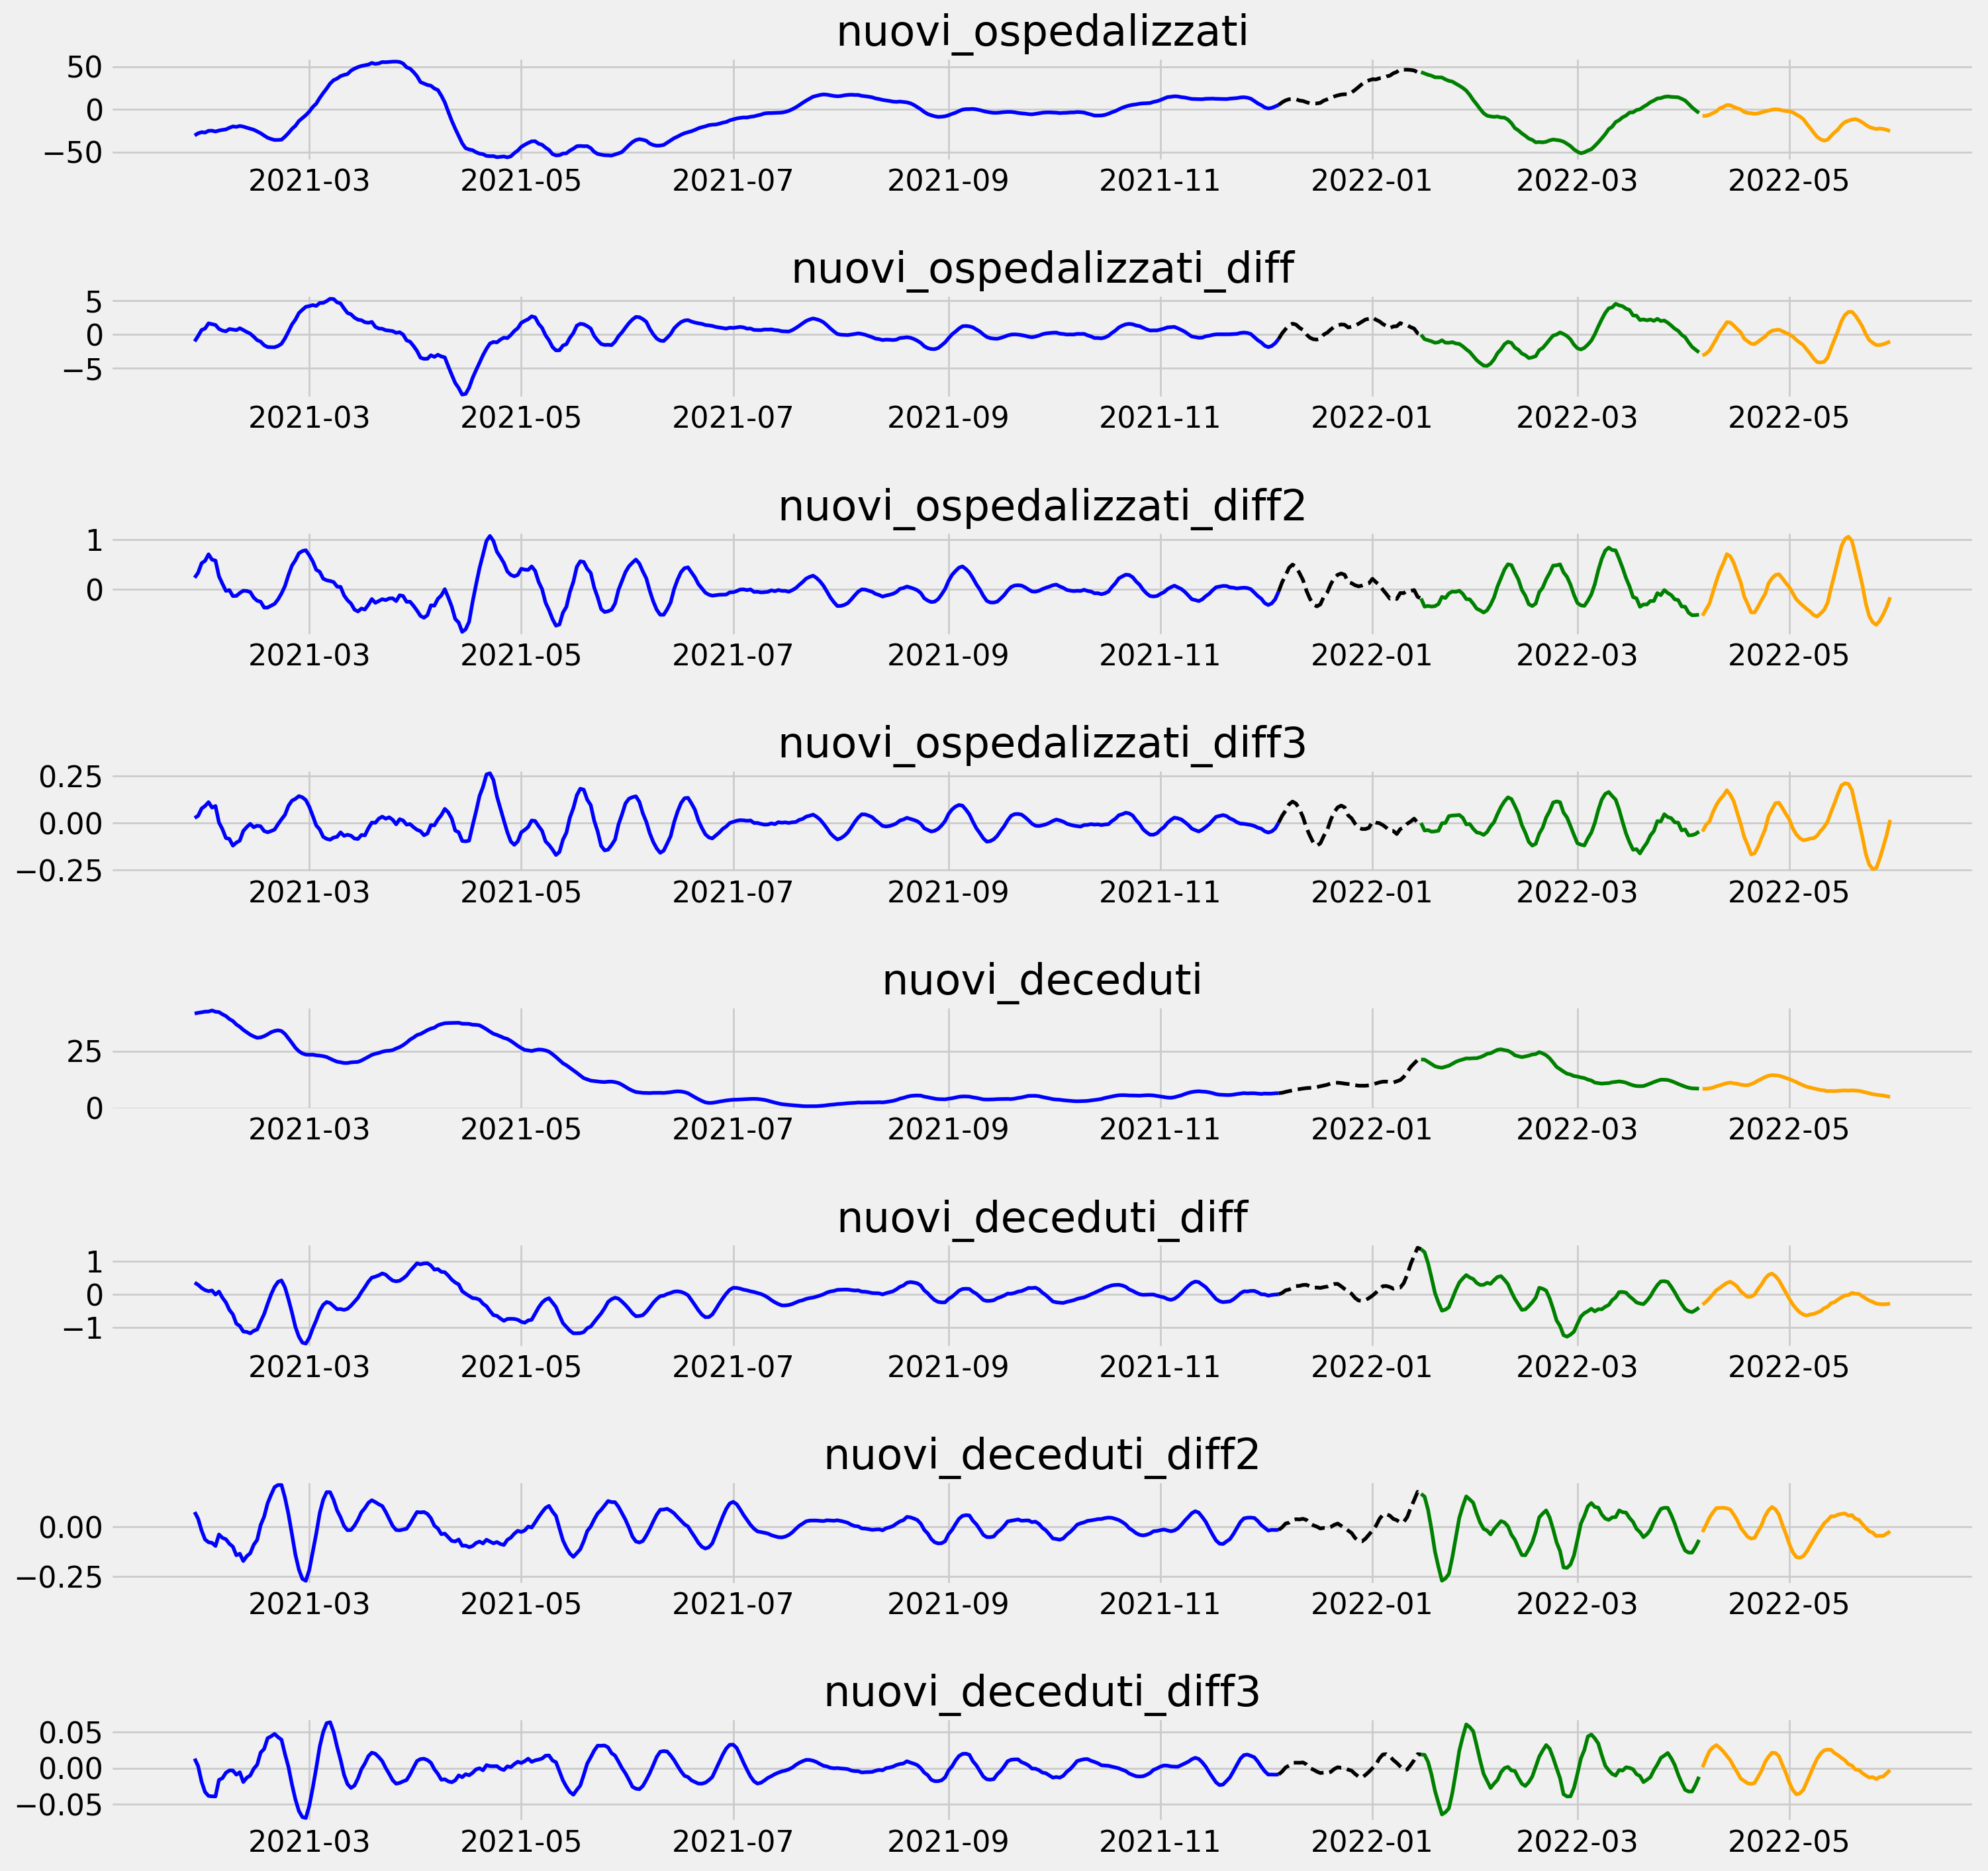

In [163]:
# Division in time sectors
pre_peak = df['2021-01-01':'2021-12-05'].copy()
#pre_peak = df['2021-11-15':'2021-12-10'].copy()
peak = df['2021-12-05':'2022-01-15'].copy()
post_peak = df['2022-01-15':].copy()

# Divide post peak in training and validation
n_post_peak = len(post_peak)
post_peak_t = post_peak[:int(n_post_peak * 0.6)] #0.5 for the rest
post_peak_val = post_peak[int(n_post_peak * 0.6):]
len(post_peak_val)

print('Pre peak : ', len(pre_peak), 'Peak : ', len(peak), 'Post peak : ', len(post_peak)*0.5)
print('Total df : ', len(pre_peak+post_peak))


# Plot
def plot_dataset_peak():
  fig, axs = plt.subplots(nrows=len(input), figsize=(16,15))
  fig.tight_layout(pad=3.0)
  
  for index, name in enumerate(input):
    axs[index].plot(pre_peak[[name]], 'blue', peak[[name]], 'k--',  post_peak_t[[name]], 'green', post_peak_val[[name]], 'orange')
    axs[index].set_title(name)
    
  
  plt.show()

plot_dataset_peak()


# Standardize
train_data = pd.concat([pre_peak, post_peak_t])
train_mean = train_data.mean()
train_std = train_data.std()

pre_peak = (pre_peak - train_mean) / train_std
post_peak_t = (post_peak_t - train_mean) / train_std
post_peak_val = (post_peak_val - train_mean) / train_std

In [164]:
window_length = 14
output_length = 7

def windows_creation(dataframe, window_length=window_length, output_length=output_length, input=input, output=output):
  
  num_windows = len(dataframe) - window_length - output_length
  x_train, y_train = np.array([dataframe[input][i:i+window_length] for i in range(num_windows)]), np.array([dataframe[output].iloc[i+window_length+output_length-1] for i in range(num_windows)])
  date = np.array([dataframe.index[i+window_length+output_length-1] for i in range(num_windows)])

  return x_train, y_train, date


x_train_pre_peak, y_train_pre_peak, _   = windows_creation(pre_peak, window_length=window_length, output_length=output_length, input=input, output=output)
x_train_post_peak, y_train_post_peak, _ = windows_creation(post_peak_t, window_length=window_length, output_length=output_length, input=input, output=output)
x_val_windows, y_val_windows, val_date  = windows_creation(post_peak_val, window_length=window_length, output_length=output_length, input=input, output=output)


x_train, y_train = np.concatenate([x_train_pre_peak, x_train_post_peak]), np.concatenate([y_train_pre_peak, y_train_post_peak])
#x_train, y_train = x_train_post_peak, y_train_post_peak

rng = np.random.default_rng(12345)
weights = np.array([((i+1)/100)**4 for i in range(x_train.shape[0])]) # **3 lomb
norm_weights = weights / np.linalg.norm(weights, 1)
resample_idx = rng.choice(a=x_train.shape[0], size = 1000, replace=True, p=norm_weights)

x_train = x_train[resample_idx]
y_train = y_train[resample_idx]

In [165]:
# Lazio 'lazio_deceduti_ospedalizzati_0.14841258
lazio_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'),

    tf.keras.layers.Dense(units=len(output), activation='linear'),
])

# 'lazio_deceduti_ospedalizzati_0.15734104'
lazio_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'),

    tf.keras.layers.Dense(units=len(output), activation='linear'),
])

# 'lazio_deceduti_ospedalizzati_0.1058159'

lazio_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'),

    tf.keras.layers.Dense(units=len(output), activation='linear'),
])


# 'lazio_deceduti_ospedalizzati_0.10719934'
lazio_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(output), activation='linear'),
])

In [166]:
lazio_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(output), activation='linear'),
])




early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)
  
RLO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.7,
    patience=10, verbose=0,
    mode="auto", min_delta=0.0001,
    cooldown=0, min_lr=0
  )

compile(lazio_model)


history = lazio_model.fit(x=x_train, y=y_train,  epochs=MAX_EPOCHS,
                      validation_data=(x_val_windows,y_val_windows ),
                      callbacks=[early_stopping, RLO], shuffle = True, batch_size=16)

Epoch 1/1000
63/63 [==============================] - 4s 18ms/step - loss: 0.5452 - mean_absolute_error: 0.5756 - val_loss: 0.2500 - val_mean_absolute_error: 0.4117 - lr: 0.0010
Epoch 2/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.3056 - mean_absolute_error: 0.4272 - val_loss: 0.2628 - val_mean_absolute_error: 0.4051 - lr: 0.0010
Epoch 3/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.2492 - mean_absolute_error: 0.3877 - val_loss: 0.2636 - val_mean_absolute_error: 0.4004 - lr: 0.0010
Epoch 4/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.2019 - mean_absolute_error: 0.3496 - val_loss: 0.2699 - val_mean_absolute_error: 0.4005 - lr: 0.0010
Epoch 5/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.1805 - mean_absolute_error: 0.3254 - val_loss: 0.2947 - val_mean_absolute_error: 0.4247 - lr: 0.0010
Epoch 6/1000
63/63 [==============================] - 1s 9ms/step - loss: 0.1751 - mean_absolute_error: 0.3230 - v

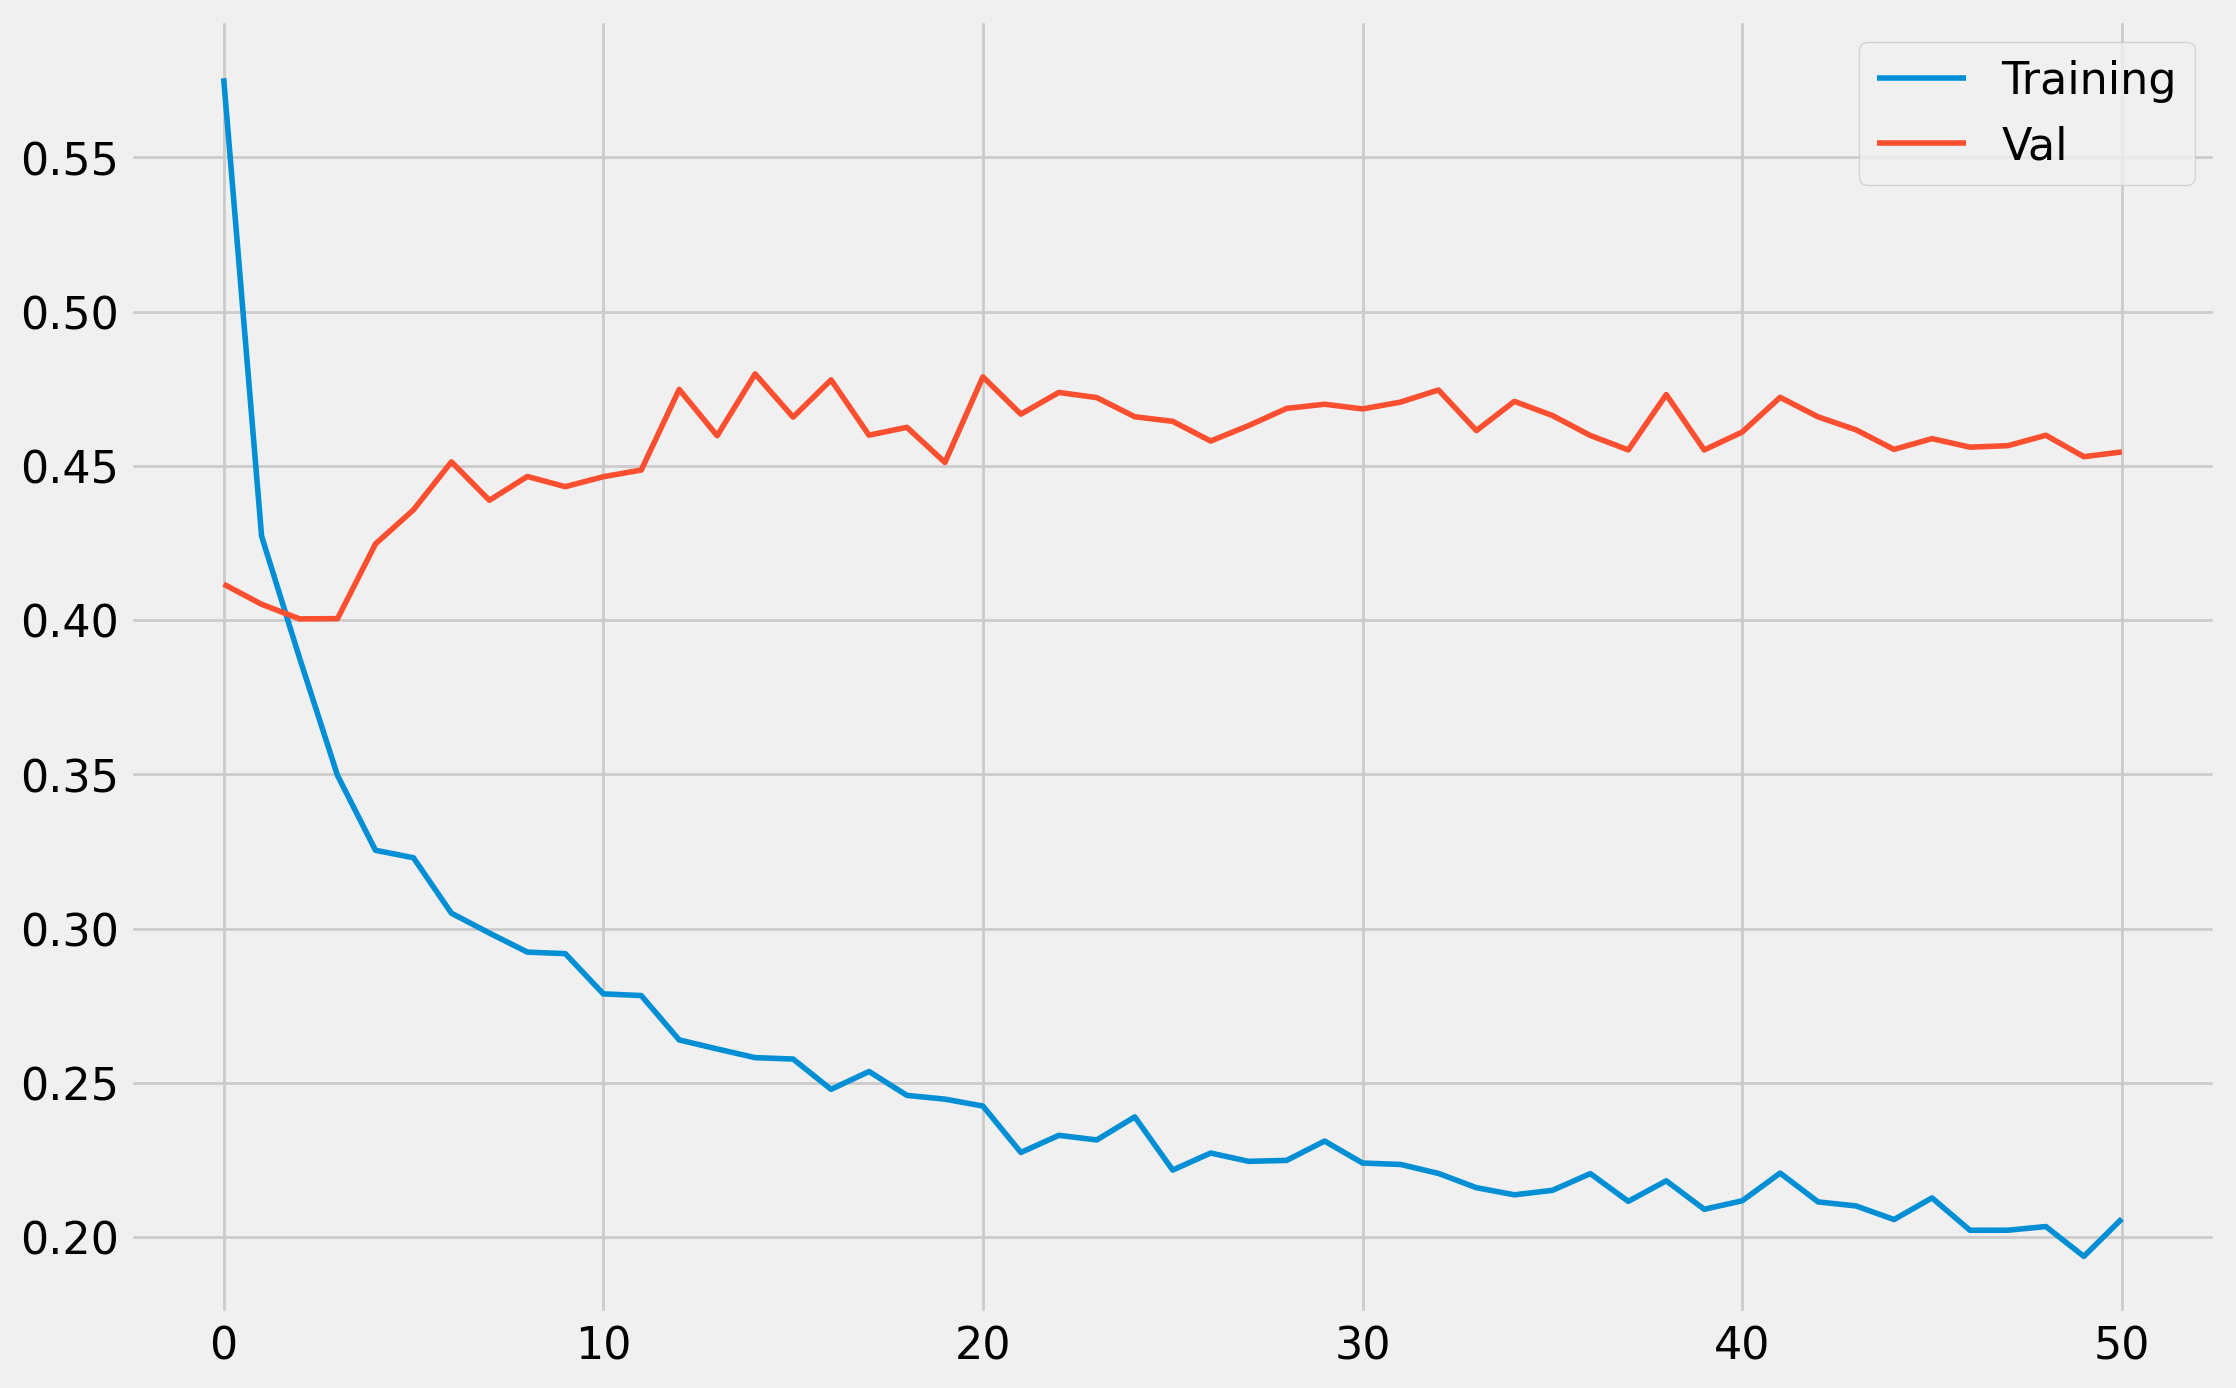

In [167]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['Training', 'Val']);

In [168]:
lazio_model.evaluate(x_val_windows, y_val_windows, batch_size=16)

3/3 [==============================] - 0s 5ms/step - loss: 0.2500 - mean_absolute_error: 0.4117


[0.2499924898147583, 0.41165241599082947]

<Figure size 1600x800 with 0 Axes>

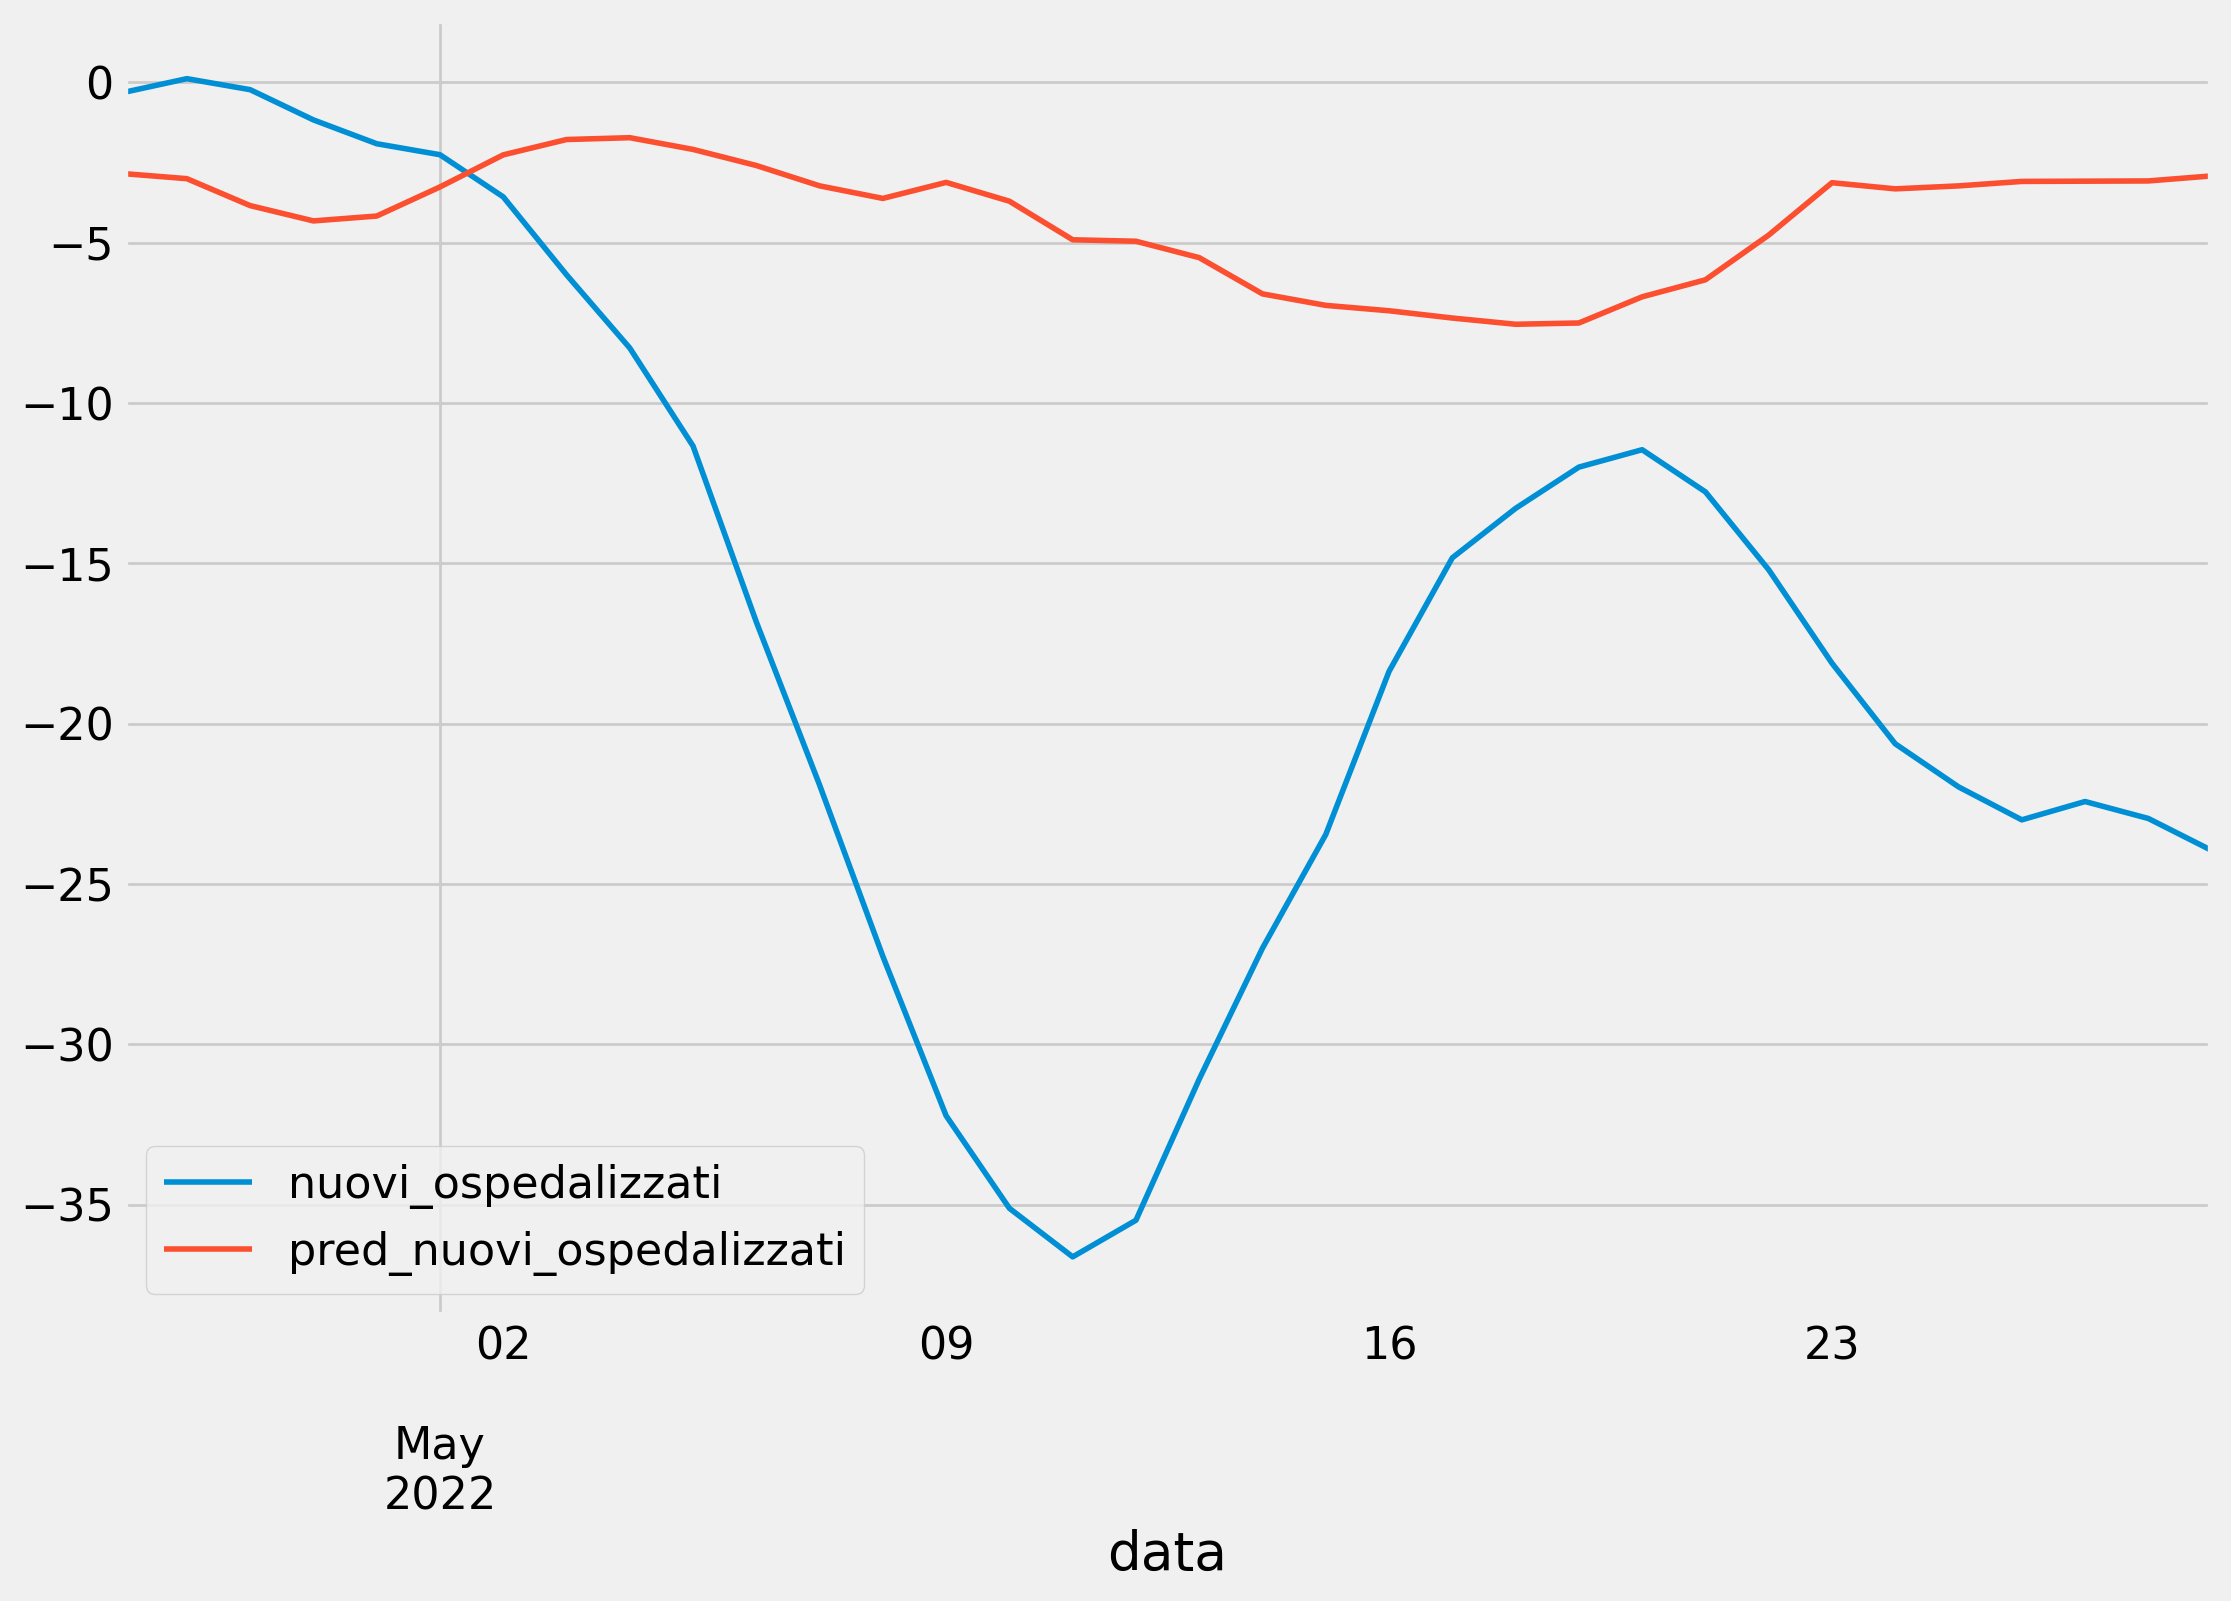

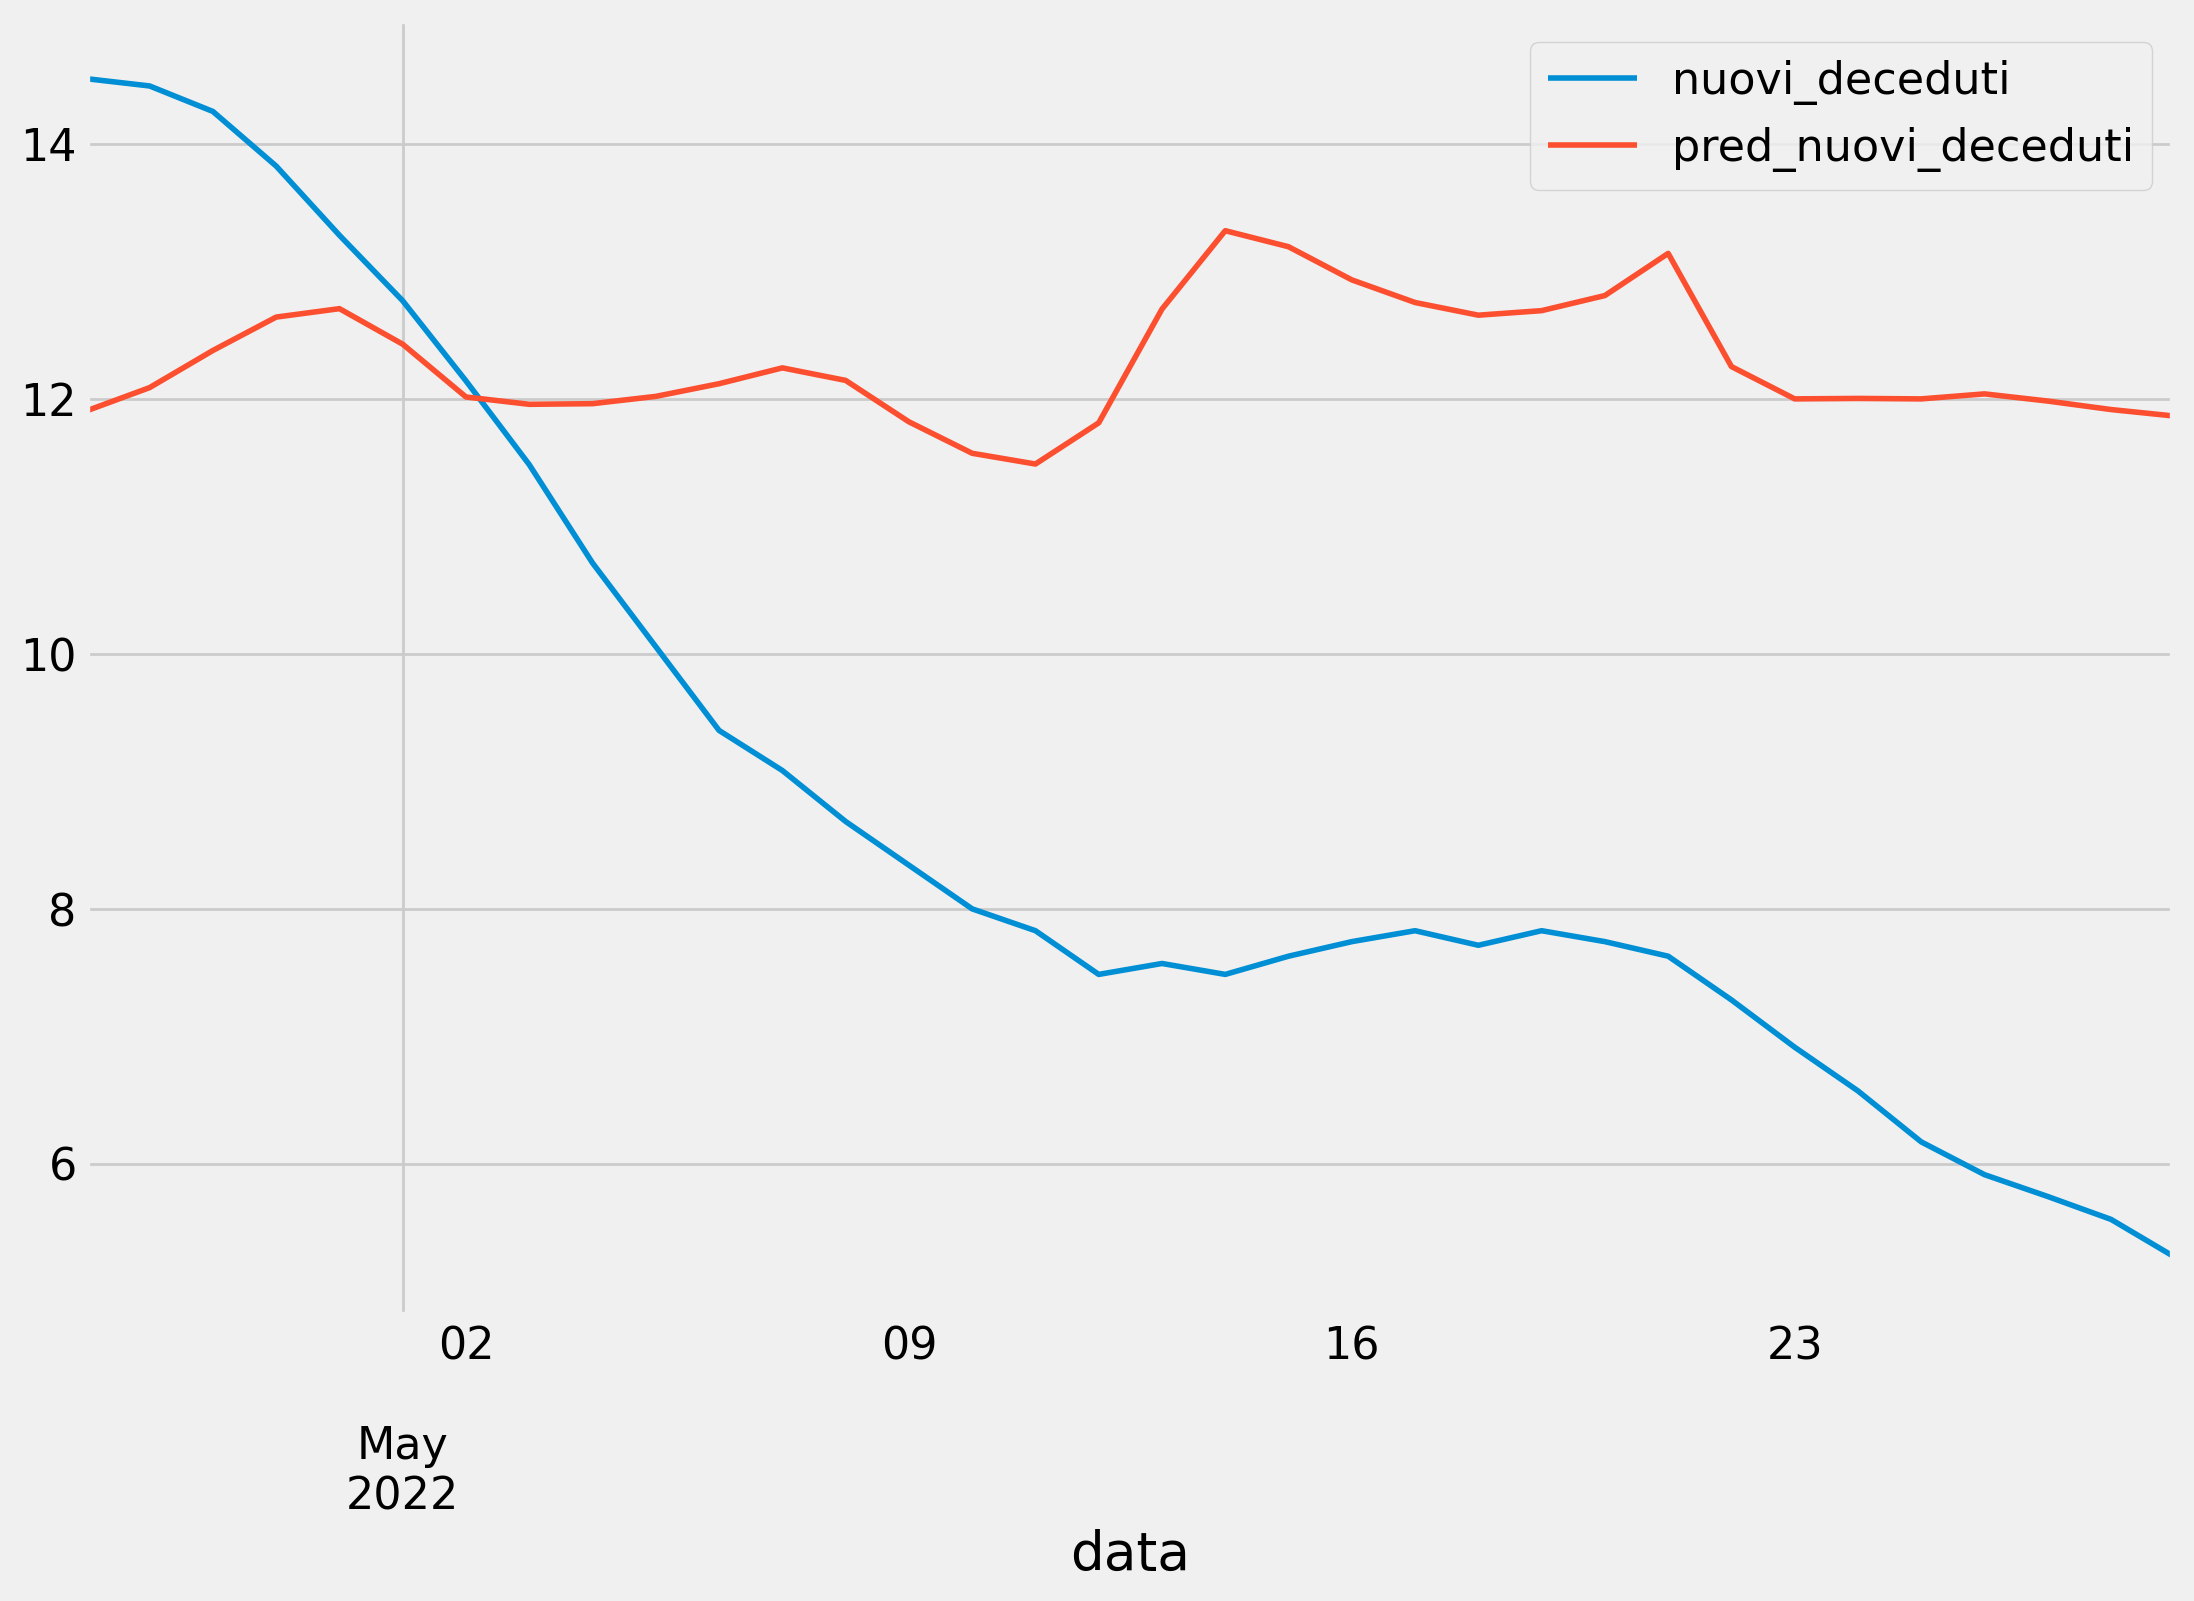

In [169]:
lazio_pred = lazio_model.predict(x_val_windows)
lazio_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

def denormalize(value, name):
  return value * train_std[name] + train_mean[name]

plt.figure(figsize=(16,8));

for ind, out in enumerate(output):
  lazio_ref['pred_'+out] = lazio_pred[:,ind]
  lazio_ref[[out, 'pred_'+out]] = lazio_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  lazio_ref[[out, 'pred_'+out]].plot();

In [170]:
#lazio_model.save('lazio_deceduti_ospedalizzati_0.1071993')

<Figure size 1600x800 with 0 Axes>

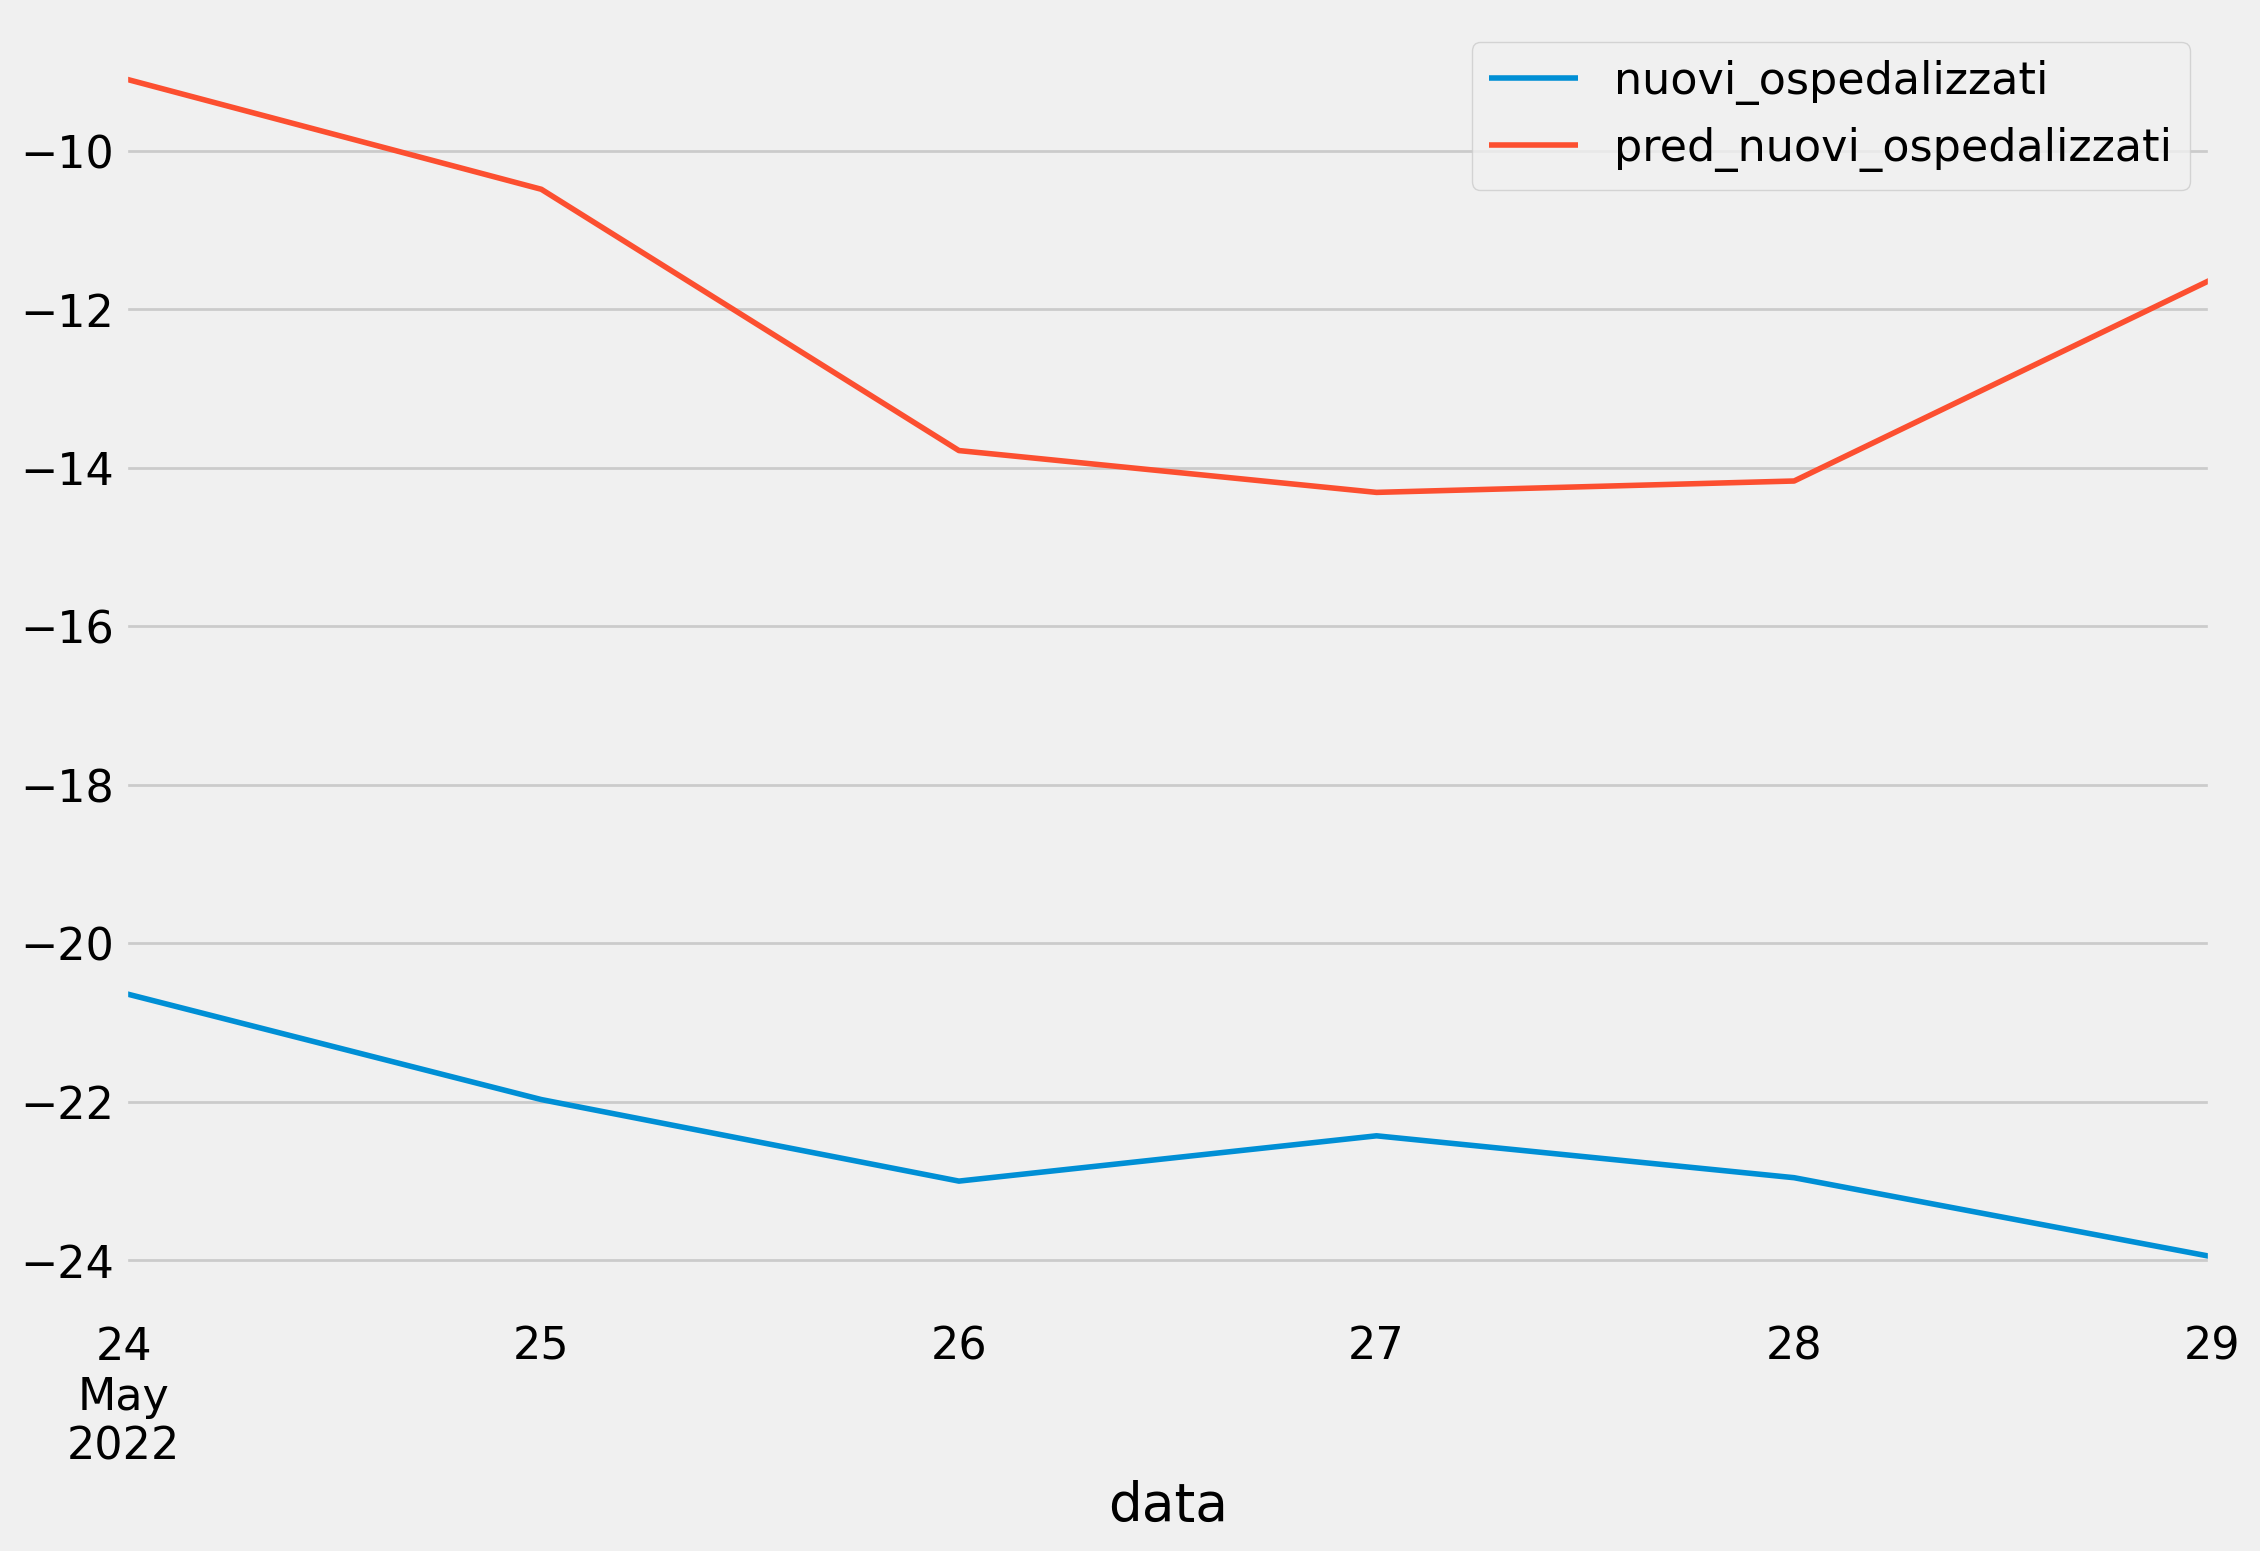

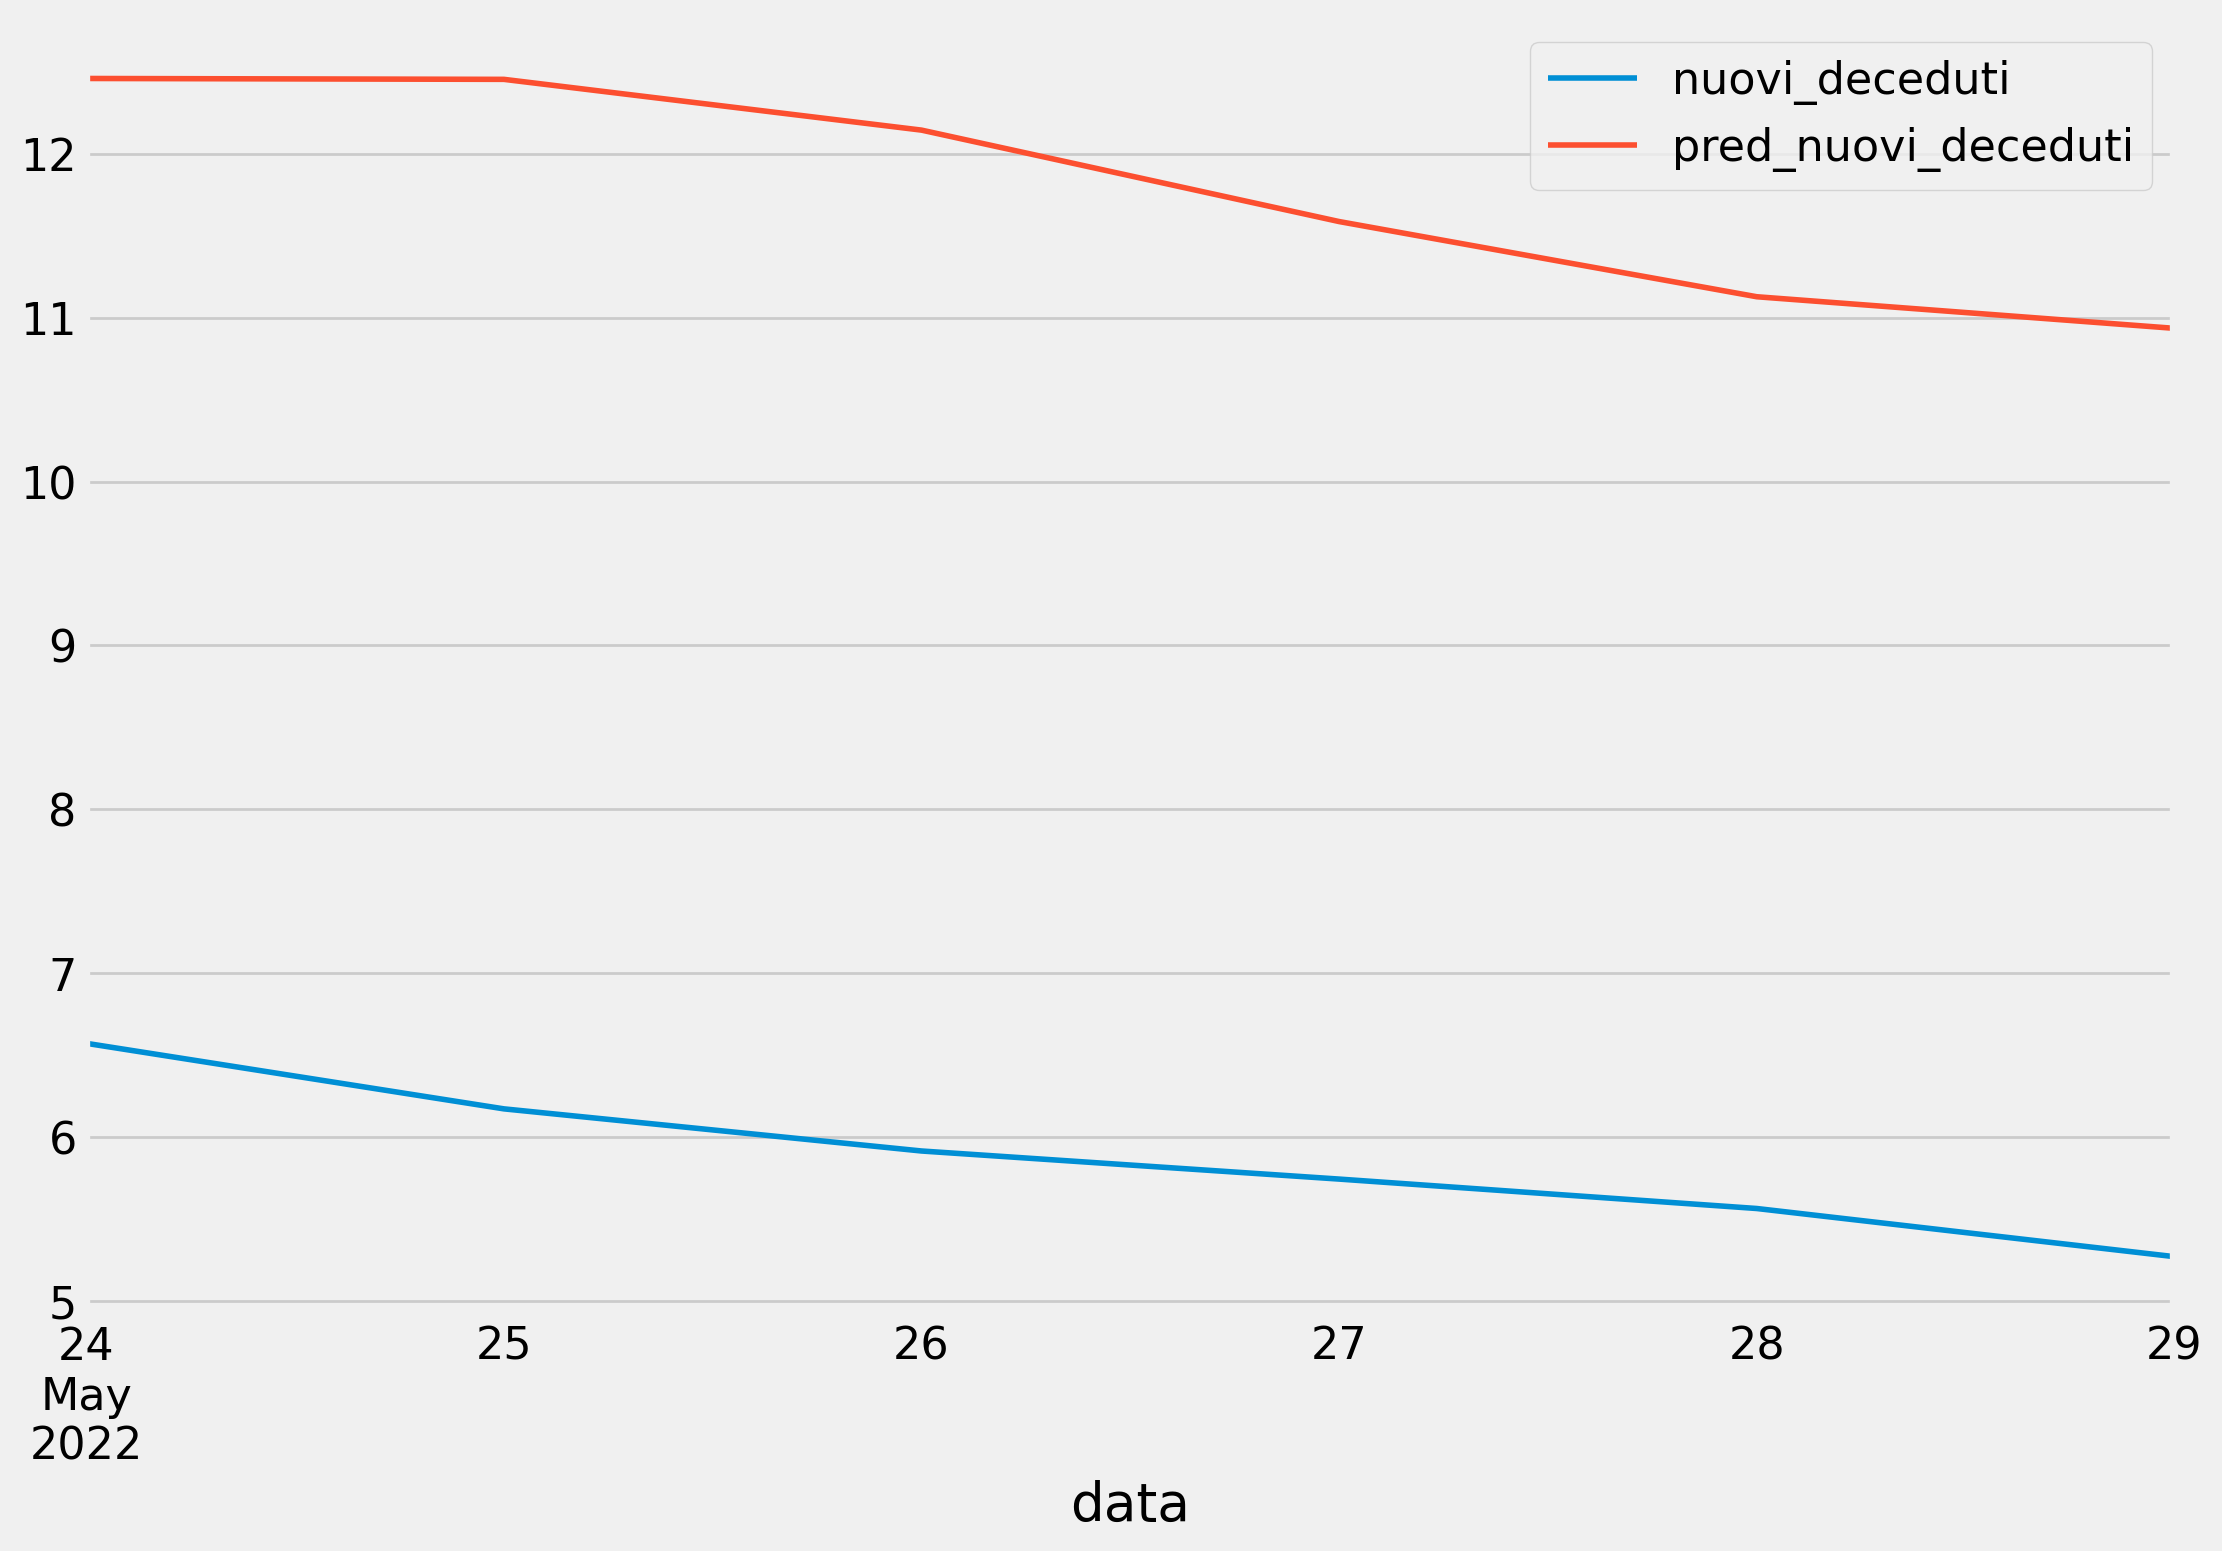

In [171]:
model1 = tf.keras.models.load_model('lazio_deceduti_ospedalizzati_0.1058159')
model2 = tf.keras.models.load_model('lazio_deceduti_ospedalizzati_0.10719934')

lazio_pred = (model1.predict(x_val_windows)  + model2.predict(x_val_windows)) / 2

lazio_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

def denormalize(value, name):
  return value * train_std[name] + train_mean[name]

plt.figure(figsize=(16,8));

for ind, out in enumerate(output):
  lazio_ref['pred_'+out] = lazio_pred[:,ind]
  lazio_ref[[out, 'pred_'+out]] = lazio_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  lazio_ref[[out, 'pred_'+out]]['2022-05-24':'2022-05-30'].plot();

In [172]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(lazio_ref[output]['2022-05-24':'2022-05-30'].values, lazio_ref[['pred_'+out for out in output]]['2022-05-24':'2022-05-30'].values)

8.079090134988476

## Test

In [173]:
def create_submmission(x_test, name, model1, model2, output=output, seasonal=seasonal):
  
  test_pred1 = model1.predict(x_test[np.newaxis,:])
  test_pred2 = model2.predict(x_test[np.newaxis,:])
  test_pred = (test_pred1 + test_pred2) / 2

  test_df = pd.DataFrame()
  test_df[output] = test_pred
  test_df['region'] = name

  for out in output:
    test_df[[out]] = test_df[[out]].apply(denormalize, raw=True, **{'name':out})

  test_df[output] = test_df[output] + seasonal[output].values[-1]

  return test_df

In [174]:
lazio_x_test = post_peak_val[input].values[-14:]
lazio_test_df = create_submmission(lazio_x_test, 'Lazio', model1, model2)
lazio_test_df.set_index('region', inplace=True)

ospedalizzati, deceduti = 'totale_ospedalizzati', 'deceduti'

base_output = [ospedalizzati, deceduti]
base_df = post_peak_val[base_output].iloc[-1:]

for out in base_output:
  base_df[[out]] = base_df[[out]].apply(denormalize, raw=True, **{'name':out})

In [175]:
lazio_test_df['hospitalized'] = (base_df[['totale_ospedalizzati']].values[0,0] + lazio_test_df[['nuovi_ospedalizzati']].values[0,0])
lazio_test_df['deceased'] = (base_df[['deceduti']].values[0,0] + lazio_test_df[['nuovi_deceduti']].values[0,0])

##Final Result

In [176]:
lazio_test_df['newinfections'] = 0
lazio_test_df['recovered'] = 0

final_output = ['hospitalized', 'deceased', 'newinfections', 'recovered']
lazio_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                      
Lazio     662.075366  11341.612079              0          0

# Sicilia

### NN ospedalizzati deceduti

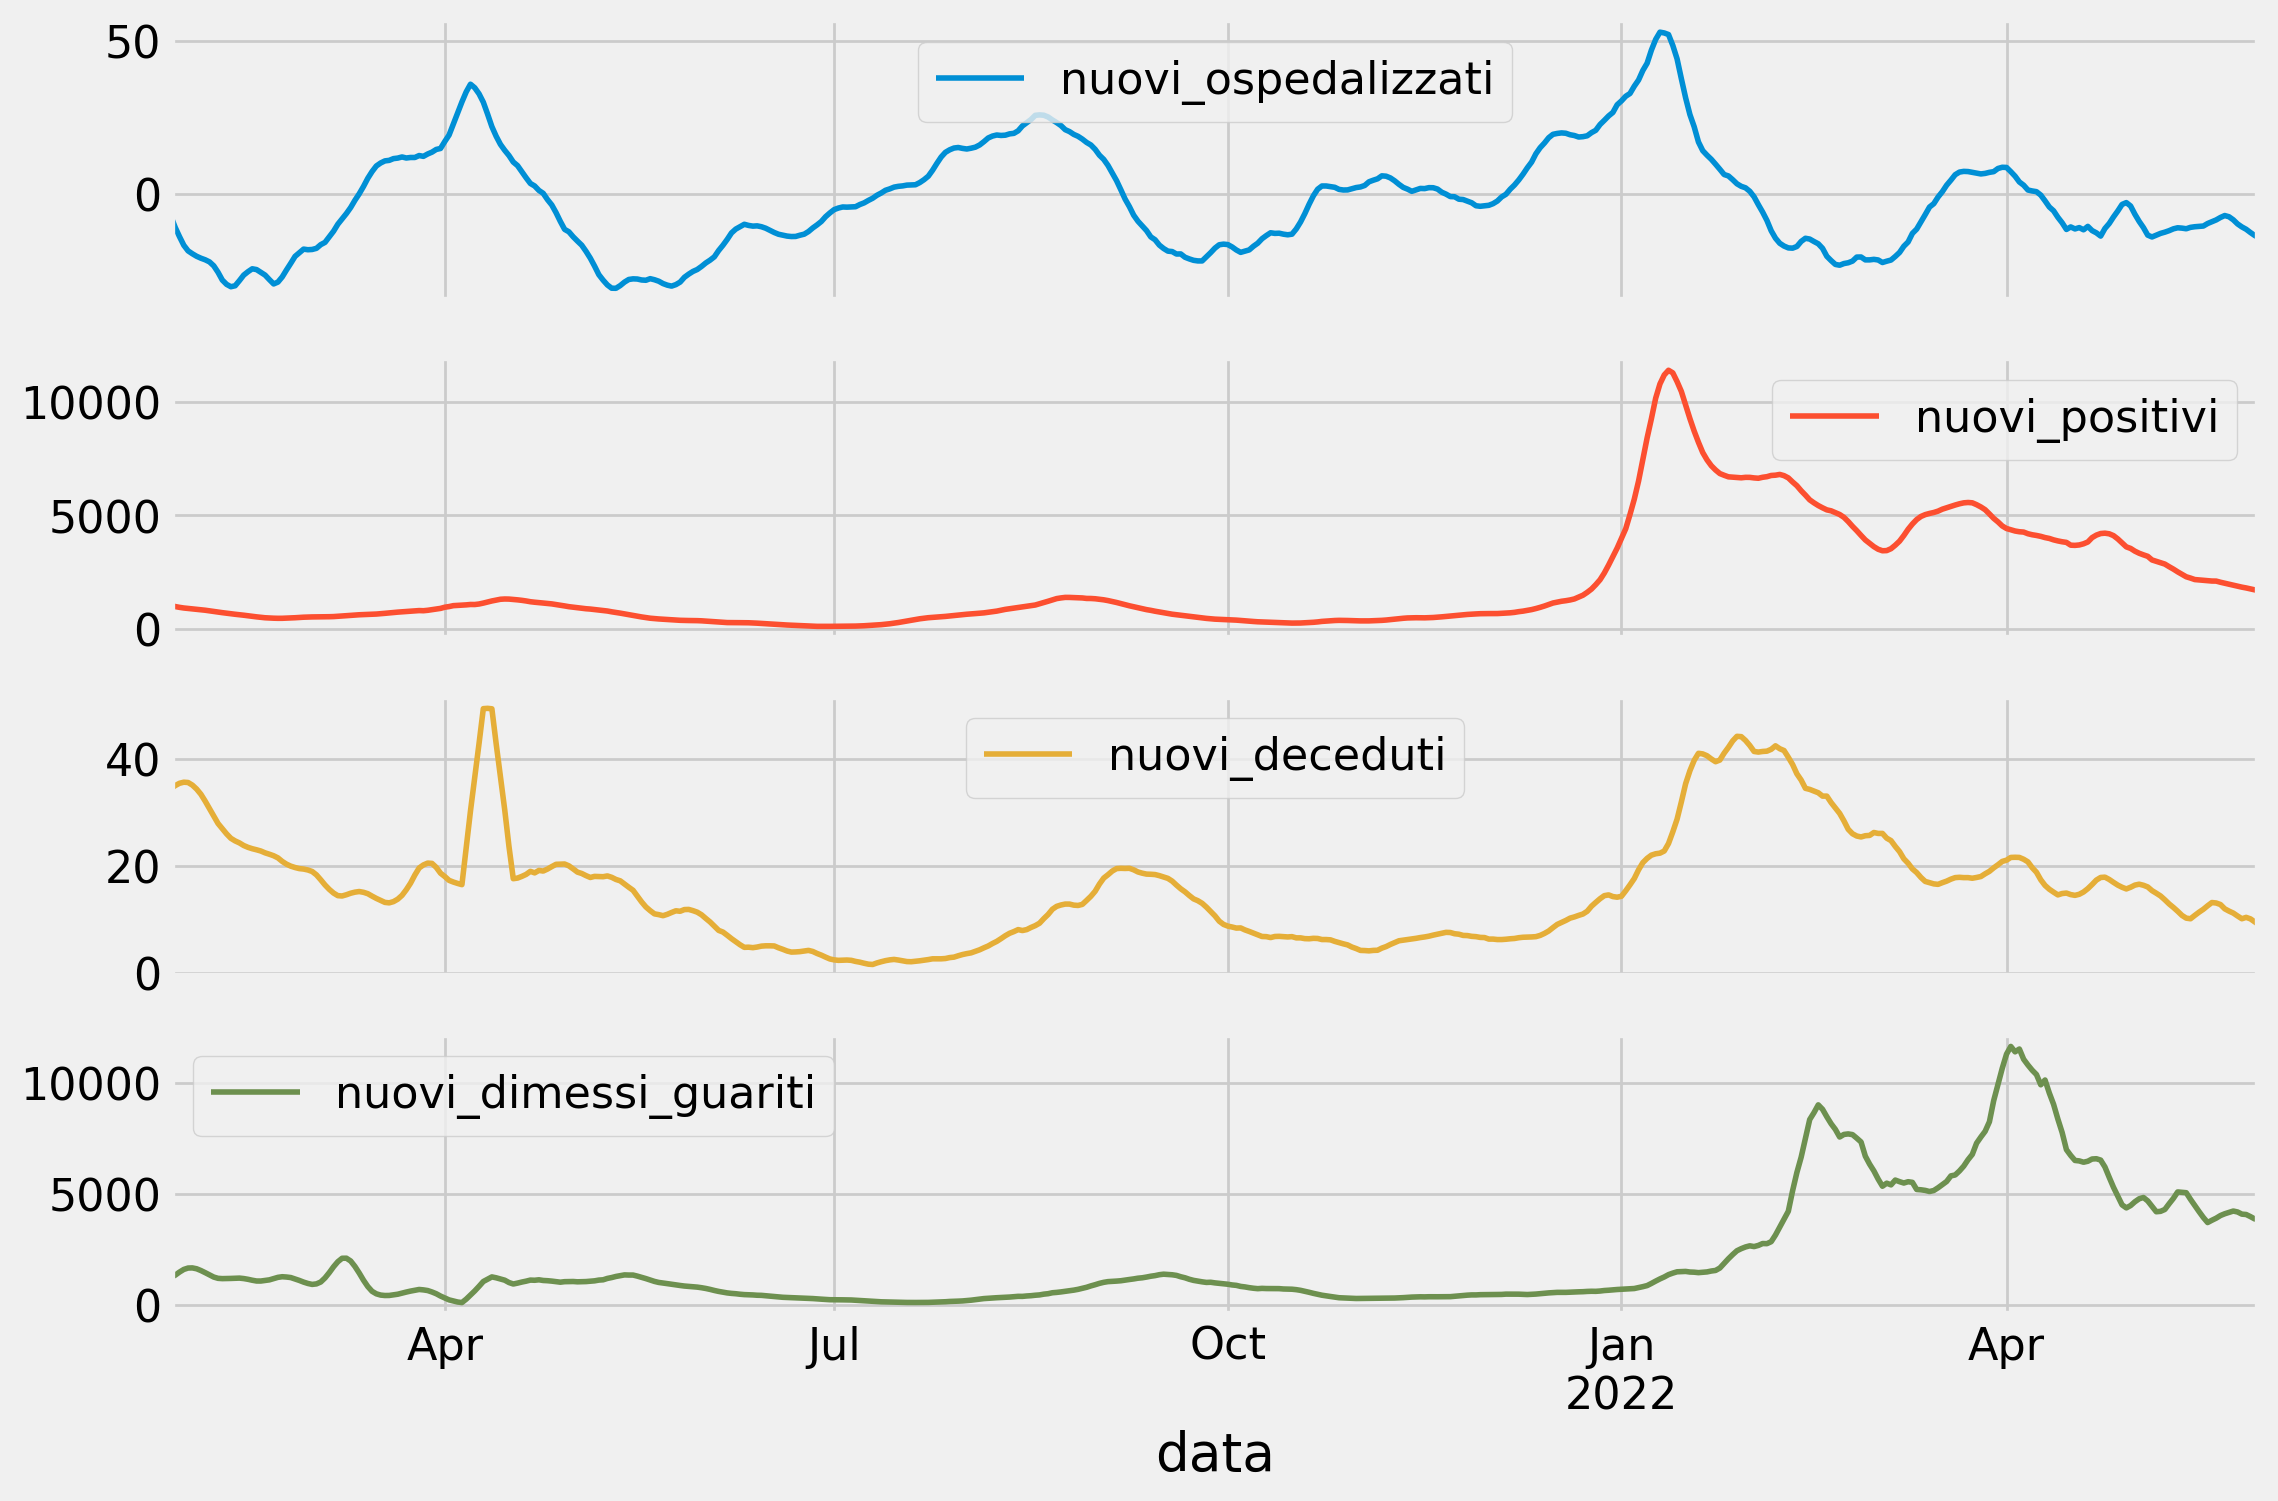

In [177]:
df = parser.region_dict['Sicilia'].copy()
input  = ['nuovi_ospedalizzati', 'nuovi_positivi', 'nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_terapia_intensiva', 'vaccini']
output = ['nuovi_ospedalizzati', 'nuovi_positivi', 'nuovi_deceduti', 'nuovi_dimessi_guariti']
df[['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 'nuovi_ospedalizzati','nuovi_ricoverati','nuovi_terapia_intensiva']] = df[['deceduti', 'dimessi_guariti', 'tamponi','totale_ospedalizzati','ricoverati_con_sintomi','terapia_intensiva']].diff()
df.head()

df.rename(columns = {'totale':'vaccini'}, inplace = True)
df[['vaccini']] = df[['vaccini']].cumsum()
seasonal = pd.DataFrame()

noise = pd.DataFrame()
# Trend extraction
df = df['2021-01-02':]
df = df[:-1]
df = df[:'2022-05-30']
for name in ['nuovi_deceduti', 'nuovi_dimessi_guariti', 'nuovi_tamponi', 'nuovi_ospedalizzati','nuovi_ricoverati','nuovi_terapia_intensiva','nuovi_positivi']:
  seasonal[[name]] = seasonal_decompose(df[[name]], model='additive', extrapolate_trend='freq').seasonal
  df[[name]] = seasonal_decompose(df[[name]], model='additive', extrapolate_trend='freq').trend.rolling(window=5).mean()
  

#df[['nuovi_positivi']] = df[['nuovi_positivi']].pct_change()
vel = []
for name in input:
  new = name+'_diff'
  new2 = name+'_diff2'
  new3 = name+'_diff3'
  vel.append(new)
  vel.append(new2)
  vel.append(new3)
  df[[new]] = df[[name]].diff().rolling(window=7).mean()
  df[[new2]] = df[[new]].diff().rolling(window=7).mean()
  df[[new3]] = df[[new2]].diff().rolling(window=7).mean()

input = input + vel
df = df[25:]

df[df.isna().any(axis=1)]

df[output].plot(subplots=True); 

In [178]:
output = ['nuovi_ospedalizzati', 'nuovi_deceduti']#['nuovi_positivi', 'nuovi_dimessi_guariti']#

orig_input = ['nuovi_ospedalizzati',
 'nuovi_positivi',
 'nuovi_deceduti',
 'nuovi_dimessi_guariti',
 'nuovi_terapia_intensiva',
 'vaccini',
 'nuovi_ospedalizzati_diff',
 'nuovi_ospedalizzati_diff2',
 'nuovi_ospedalizzati_diff3',
 'nuovi_positivi_diff',
 'nuovi_positivi_diff2',
 'nuovi_positivi_diff3',
 'nuovi_deceduti_diff',
 'nuovi_deceduti_diff2',
 'nuovi_deceduti_diff3',
 'nuovi_dimessi_guariti_diff',
 'nuovi_dimessi_guariti_diff2',
 'nuovi_dimessi_guariti_diff3',
 'nuovi_terapia_intensiva_diff',
 'nuovi_terapia_intensiva_diff2',
 'nuovi_terapia_intensiva_diff3',
 'vaccini_diff',
 'vaccini_diff2',
 'vaccini_diff3']

diff_list = ['','_diff', '_diff2', '_diff3']
input = [out+diff for out in output for diff in diff_list]



Pre peak :  339 Peak :  2 Post peak :  75.0
Total df :  489


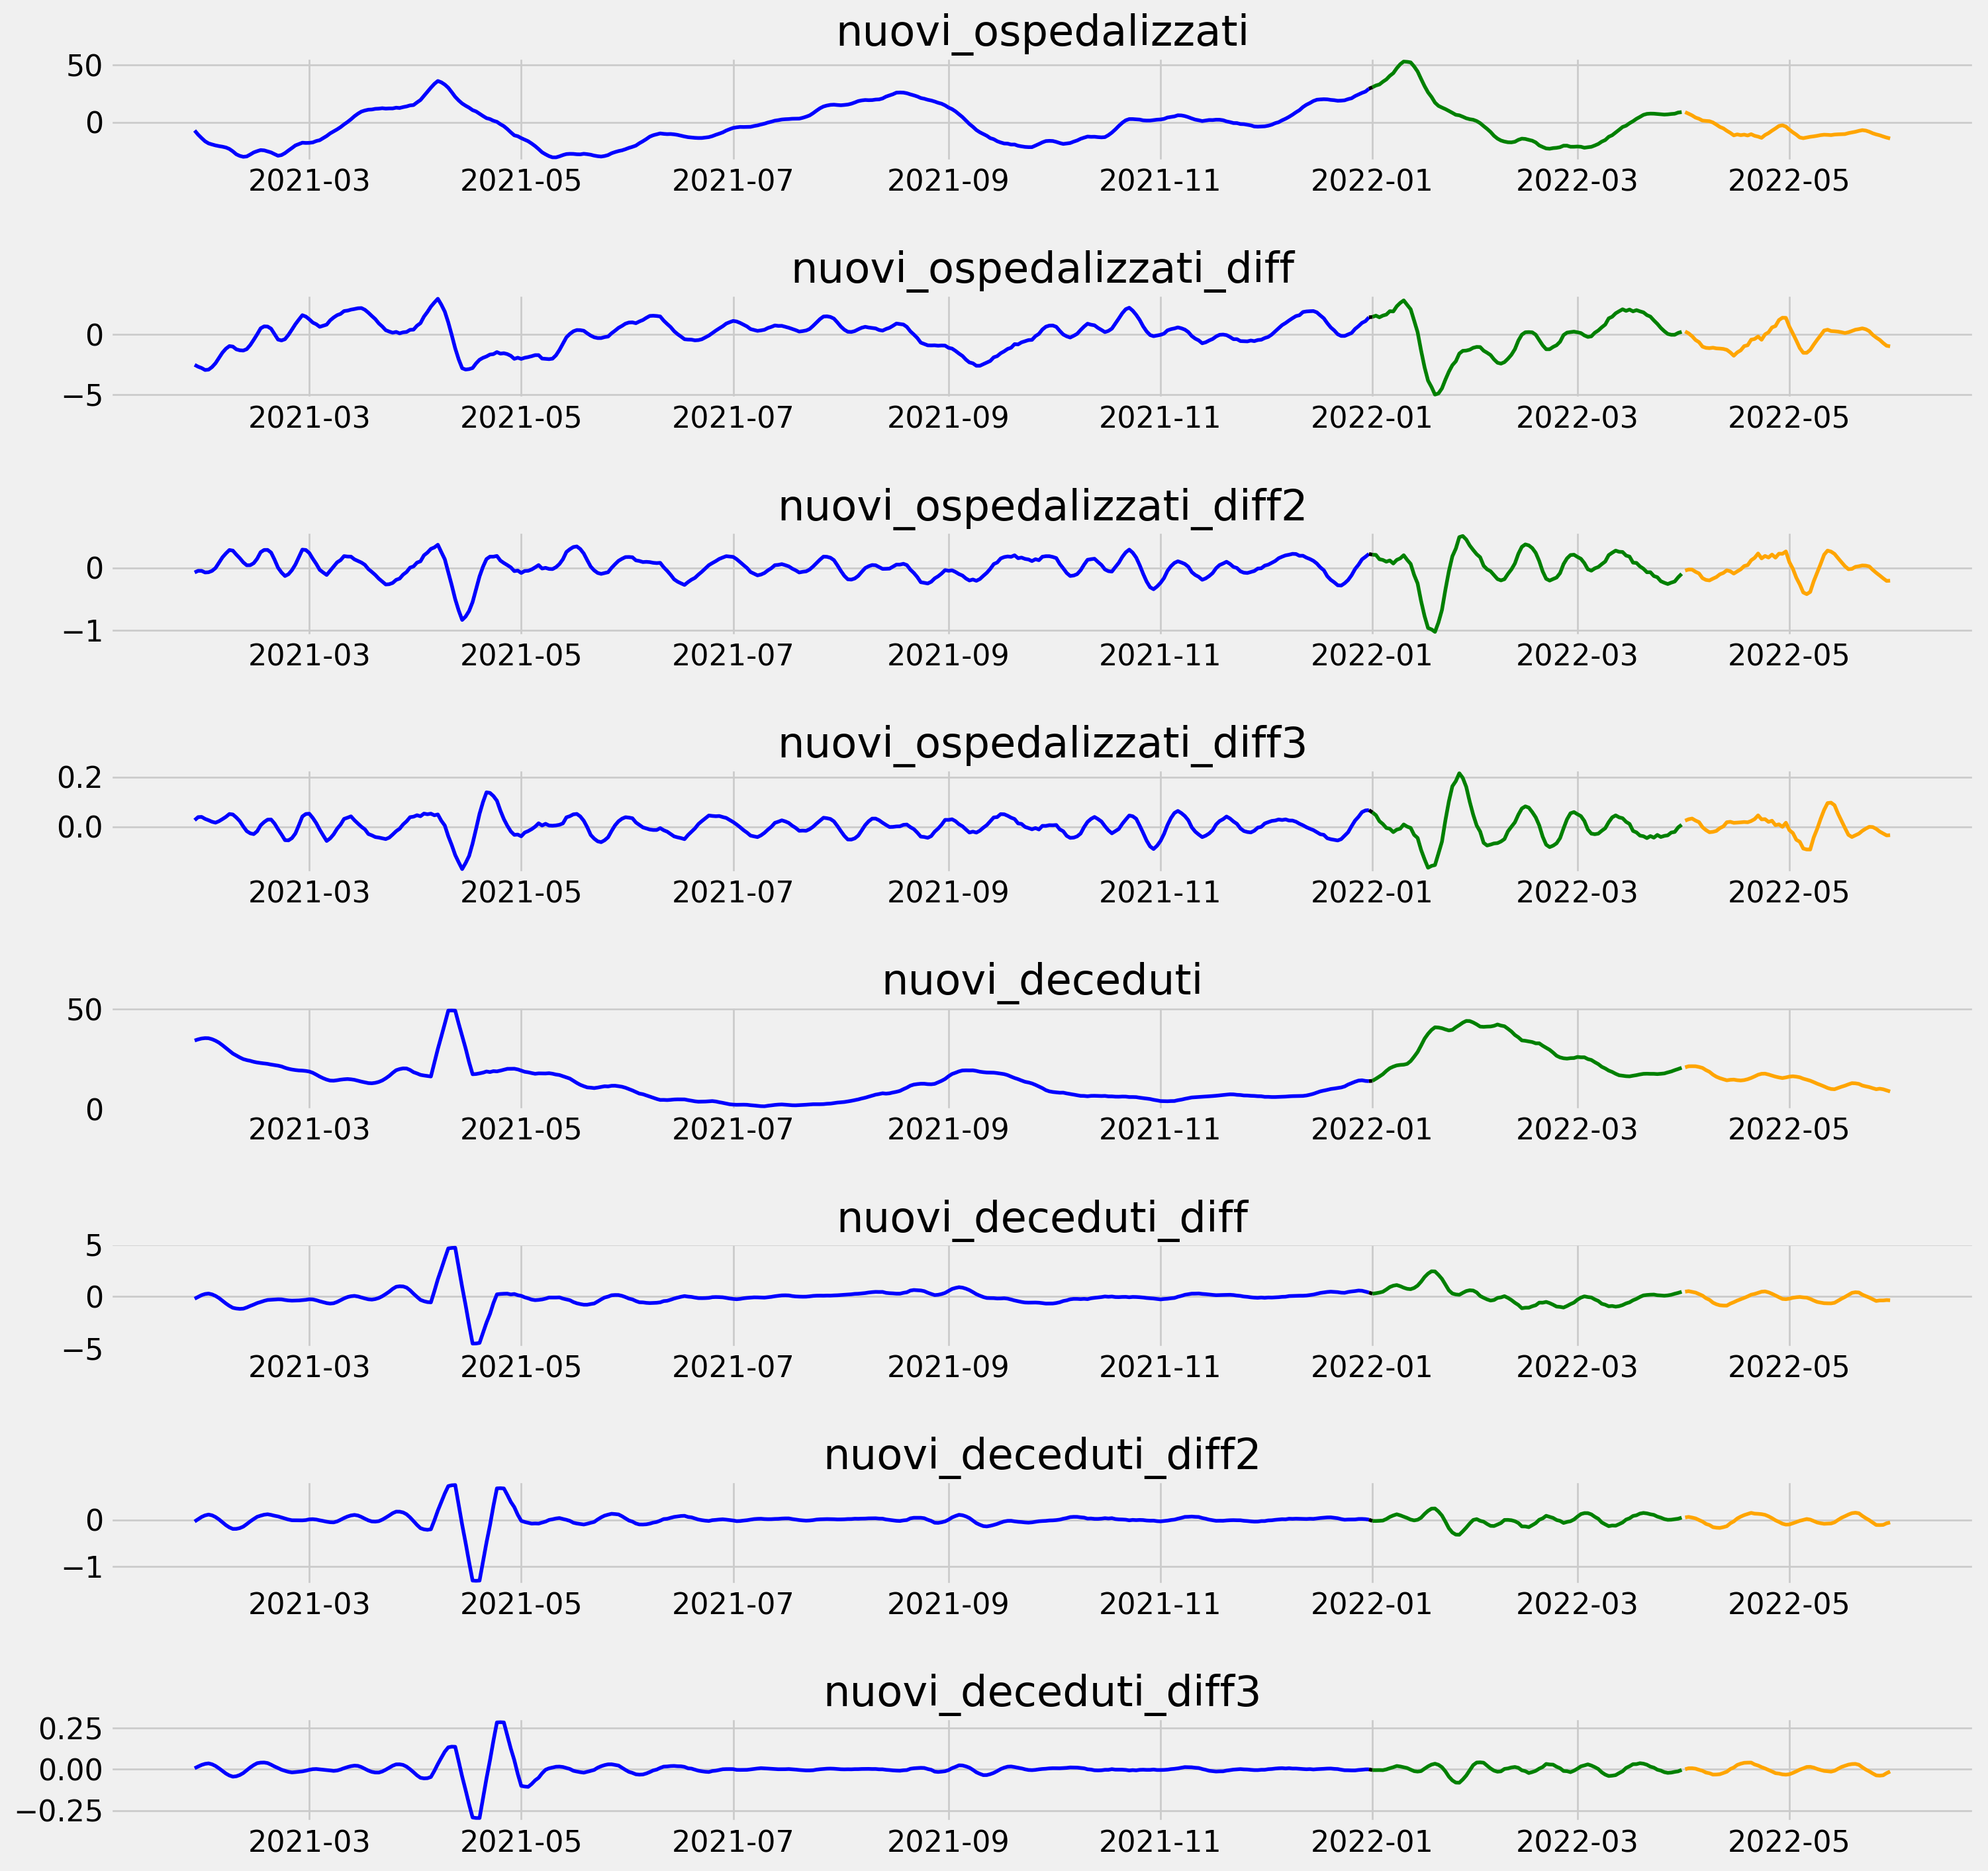

In [179]:
# Division in time sectors
pre_peak = df['2021-01-01':'2021-12-31'].copy()
#pre_peak = df['2021-11-15':'2021-12-10'].copy()
peak = df['2021-12-31':'2022-01-01'].copy()
post_peak = df['2022-01-01':].copy()

# Divide post peak in training and validation
n_post_peak = len(post_peak)
post_peak_t = post_peak[:int(n_post_peak * 0.6)] #0.5 for the rest
post_peak_val = post_peak[int(n_post_peak * 0.6):]
len(post_peak_val)

print('Pre peak : ', len(pre_peak), 'Peak : ', len(peak), 'Post peak : ', len(post_peak)*0.5)
print('Total df : ', len(pre_peak+post_peak))


# Plot
def plot_dataset_peak():
  fig, axs = plt.subplots(nrows=len(input), figsize=(16,15))
  fig.tight_layout(pad=3.0)
  
  for index, name in enumerate(input):
    axs[index].plot(pre_peak[[name]], 'blue', peak[[name]], 'k--',  post_peak_t[[name]], 'green', post_peak_val[[name]], 'orange')
    axs[index].set_title(name)
    
  
  plt.show()

plot_dataset_peak()


# Standardize
train_data = pd.concat([pre_peak, post_peak_t])
train_mean = train_data.mean()
train_std = train_data.std()

pre_peak = (pre_peak - train_mean) / train_std
post_peak_t = (post_peak_t - train_mean) / train_std
post_peak_val = (post_peak_val - train_mean) / train_std

In [180]:
window_length = 14
output_length = 7

def windows_creation(dataframe, window_length=window_length, output_length=output_length, input=input, output=output):
  
  num_windows = len(dataframe) - window_length - output_length
  x_train, y_train = np.array([dataframe[input][i:i+window_length] for i in range(num_windows)]), np.array([dataframe[output].iloc[i+window_length+output_length-1] for i in range(num_windows)])
  date = np.array([dataframe.index[i+window_length+output_length-1] for i in range(num_windows)])

  return x_train, y_train, date


x_train_pre_peak, y_train_pre_peak, _   = windows_creation(pre_peak, window_length=window_length, output_length=output_length, input=input, output=output)
x_train_post_peak, y_train_post_peak, _ = windows_creation(post_peak_t, window_length=window_length, output_length=output_length, input=input, output=output)
x_val_windows, y_val_windows, val_date  = windows_creation(post_peak_val, window_length=window_length, output_length=output_length, input=input, output=output)


x_train, y_train = np.concatenate([x_train_pre_peak, x_train_post_peak]), np.concatenate([y_train_pre_peak, y_train_post_peak])
#x_train, y_train = x_train_post_peak, y_train_post_peak

rng = np.random.default_rng(12345)
weights = np.array([((i+1)/100)**4 for i in range(x_train.shape[0])]) # **3 lomb
norm_weights = weights / np.linalg.norm(weights, 1)
resample_idx = rng.choice(a=x_train.shape[0], size = 1000, replace=True, p=norm_weights)

x_train = x_train[resample_idx]
y_train = y_train[resample_idx]

In [181]:
sicilia_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2()),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2()),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.L1L2()),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L1L2(), activation='relu'), tf.keras.layers.Dropout(0.2),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(output), activation='linear'),
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)
  
RLO = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.7,
    patience=10, verbose=0,
    mode="auto", min_delta=0.0001,
    cooldown=0, min_lr=0
  )

compile(sicilia_model)


history = sicilia_model.fit(x=x_train, y=y_train,  epochs=MAX_EPOCHS,
                      validation_data=(x_val_windows,y_val_windows ),
                      callbacks=[early_stopping, RLO], shuffle = True, batch_size=16)

Epoch 1/1000
63/63 [==============================] - 9s 40ms/step - loss: 0.2780 - mean_absolute_error: 0.4071 - val_loss: 0.1698 - val_mean_absolute_error: 0.3610 - lr: 0.0010
Epoch 2/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.1488 - mean_absolute_error: 0.3002 - val_loss: 0.1702 - val_mean_absolute_error: 0.3611 - lr: 0.0010
Epoch 3/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.1360 - mean_absolute_error: 0.2800 - val_loss: 0.1658 - val_mean_absolute_error: 0.3537 - lr: 0.0010
Epoch 4/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.1014 - mean_absolute_error: 0.2370 - val_loss: 0.1641 - val_mean_absolute_error: 0.3492 - lr: 0.0010
Epoch 5/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.1071 - mean_absolute_error: 0.2489 - val_loss: 0.1623 - val_mean_absolute_error: 0.3480 - lr: 0.0010
Epoch 6/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0965 - mean_absolute_error: 0.235

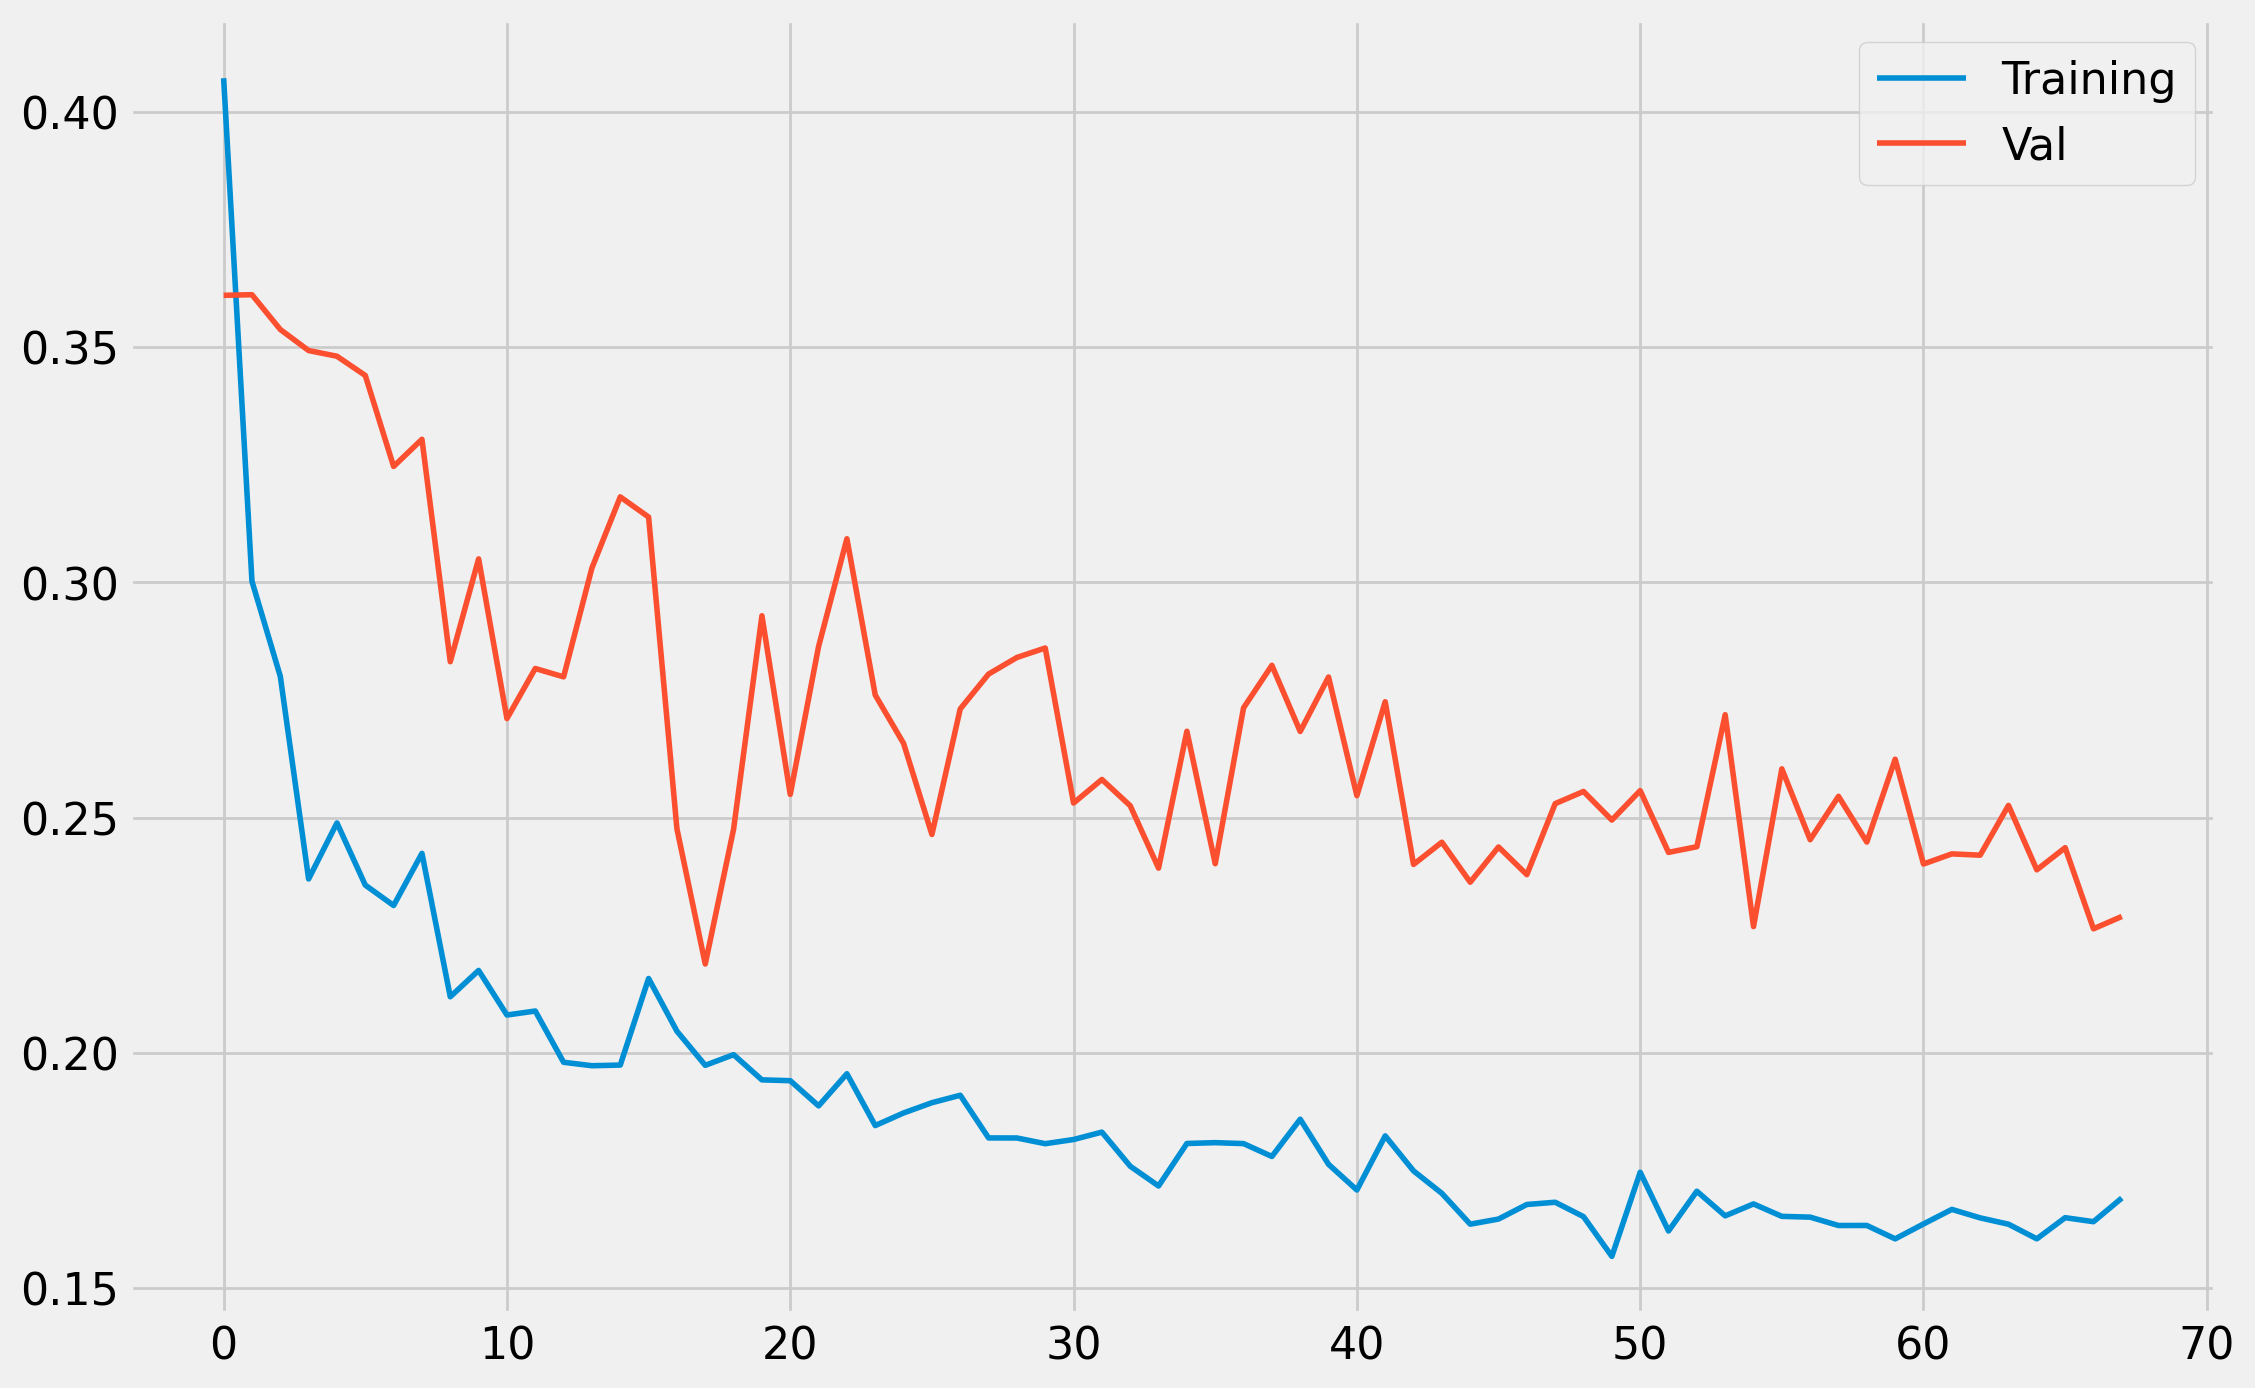

In [182]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['Training', 'Val']);

In [183]:
sicilia_model.evaluate(x_val_windows, y_val_windows, batch_size=16)

3/3 [==============================] - 0s 6ms/step - loss: 0.0838 - mean_absolute_error: 0.2189


[0.08380629122257233, 0.21889163553714752]

<Figure size 1600x800 with 0 Axes>

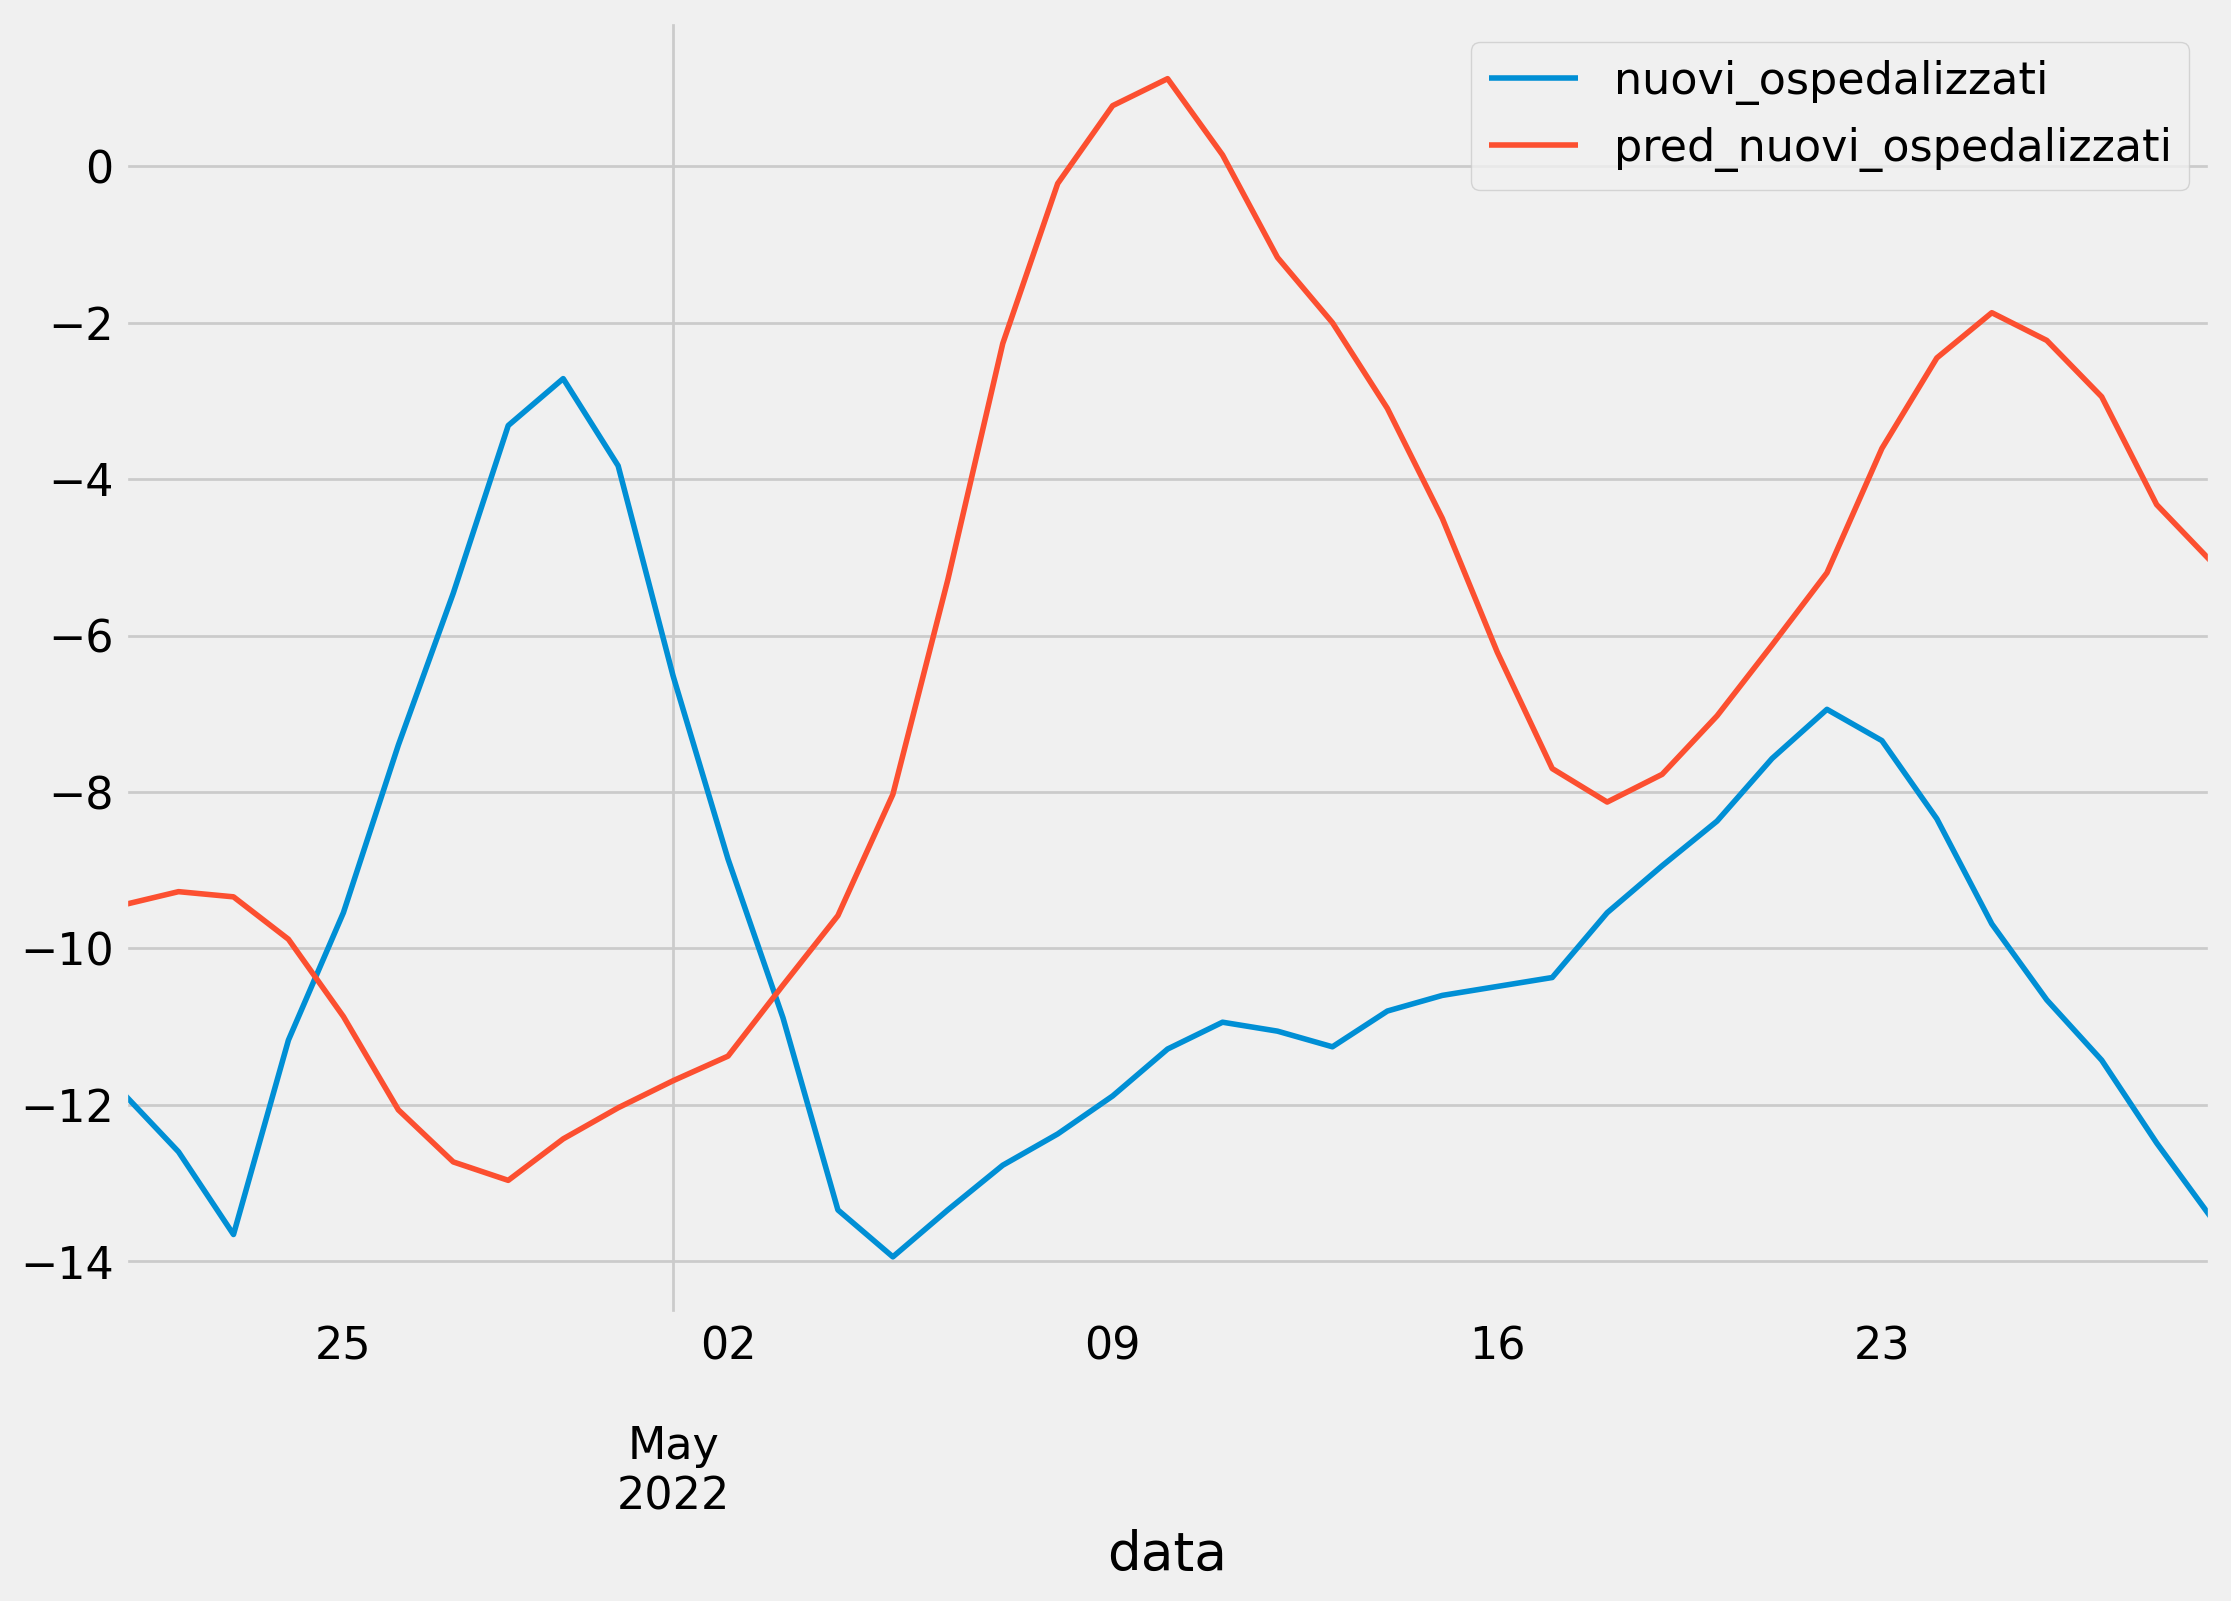

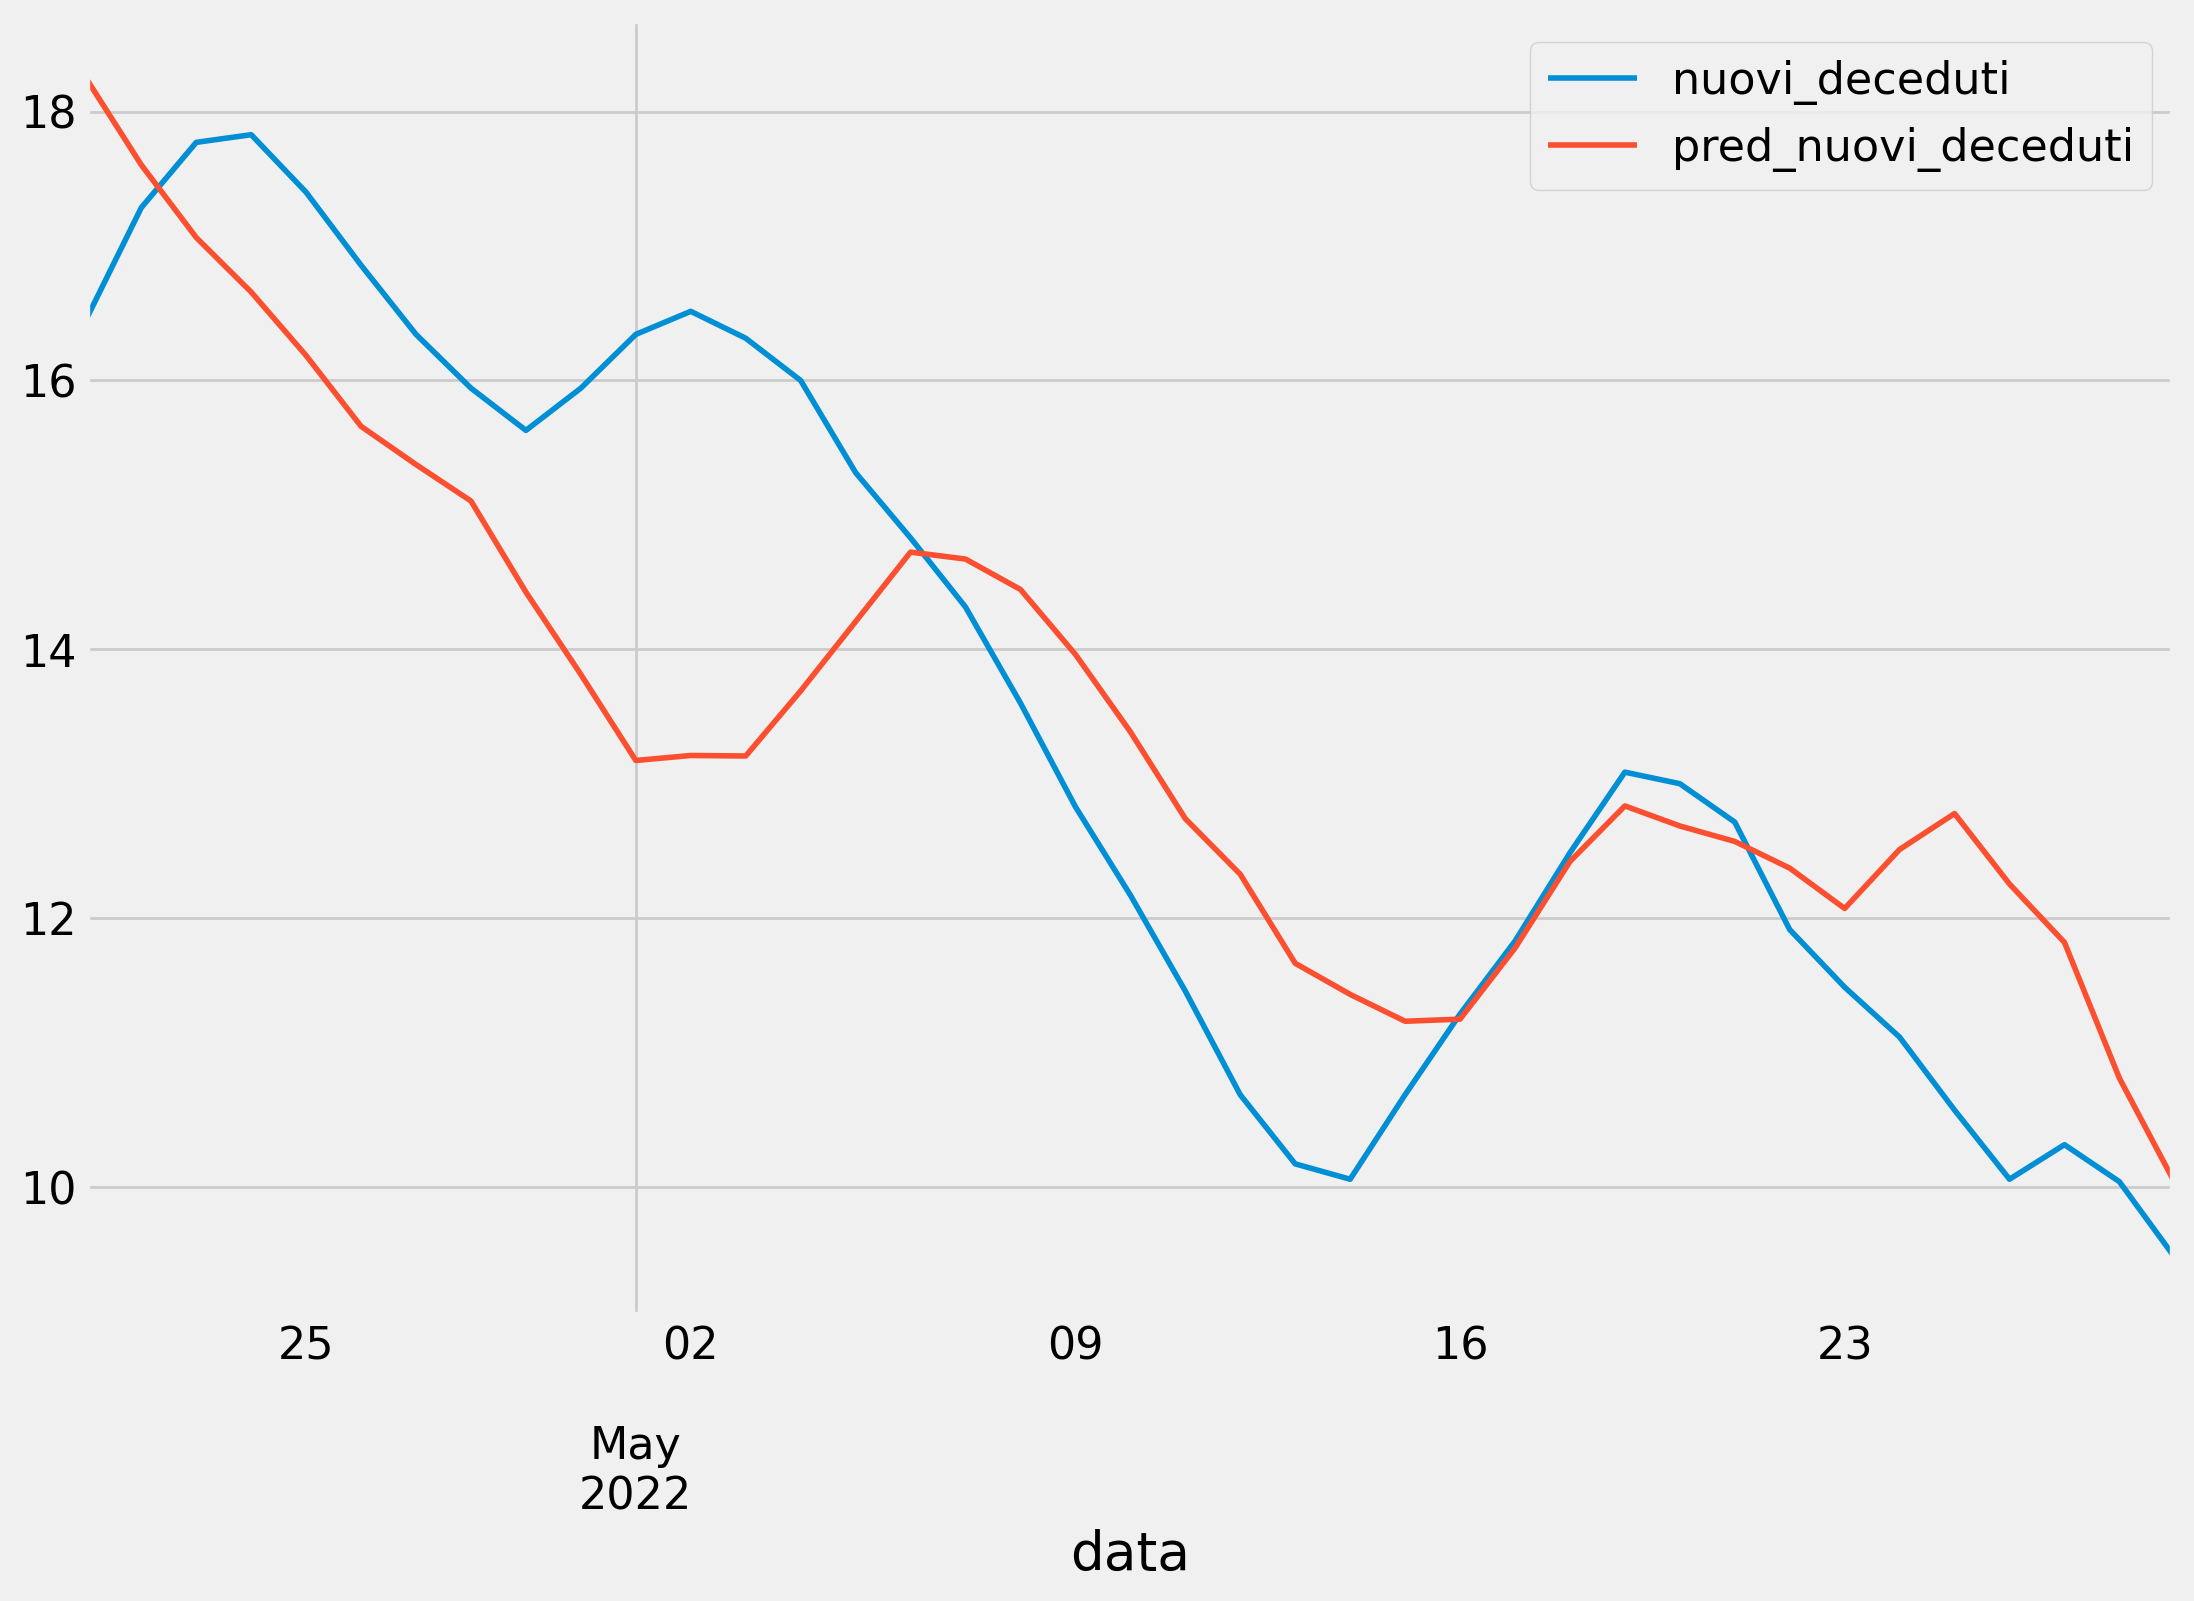

In [184]:
sicilia_pred = sicilia_model.predict(x_val_windows)
sicilia_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

def denormalize(value, name):
  return value * train_std[name] + train_mean[name]

plt.figure(figsize=(16,8));

for ind, out in enumerate(output):
  sicilia_ref['pred_'+out] = sicilia_pred[:,ind]
  sicilia_ref[[out, 'pred_'+out]] = sicilia_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  sicilia_ref[[out, 'pred_'+out]].plot();

In [185]:
#sicilia_model.save('sicilia_deceduti_ospedalizzati_0.1725573')

<Figure size 1600x800 with 0 Axes>

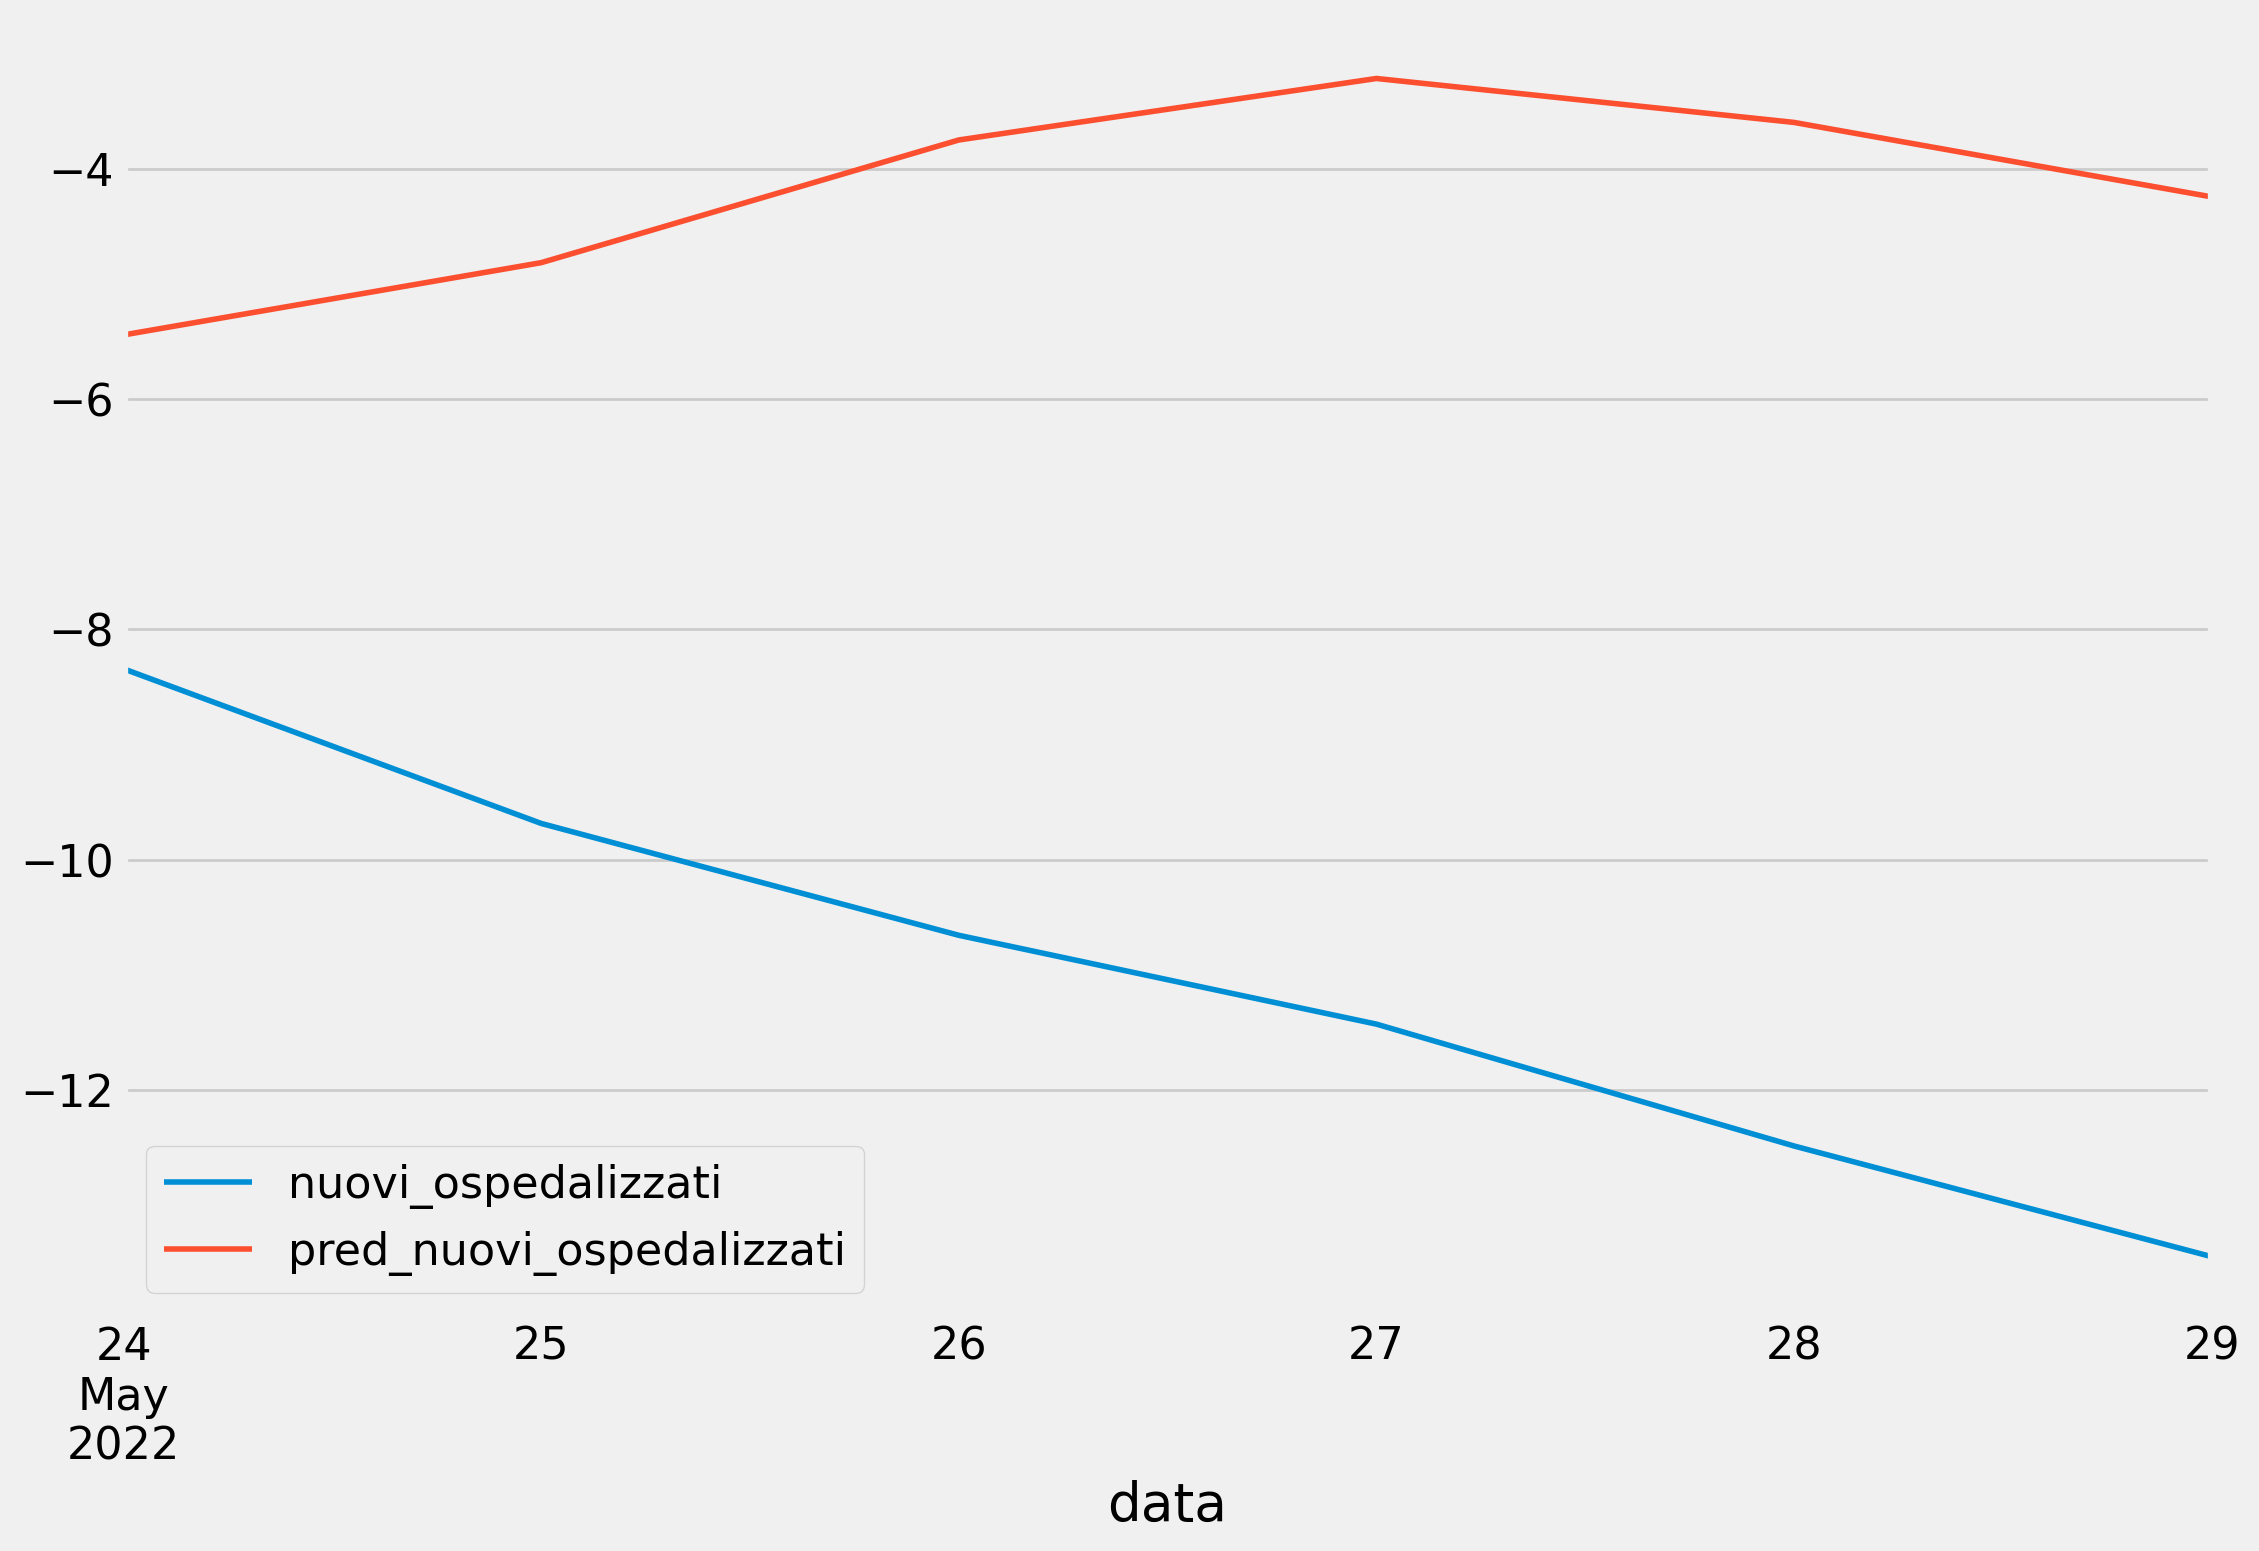

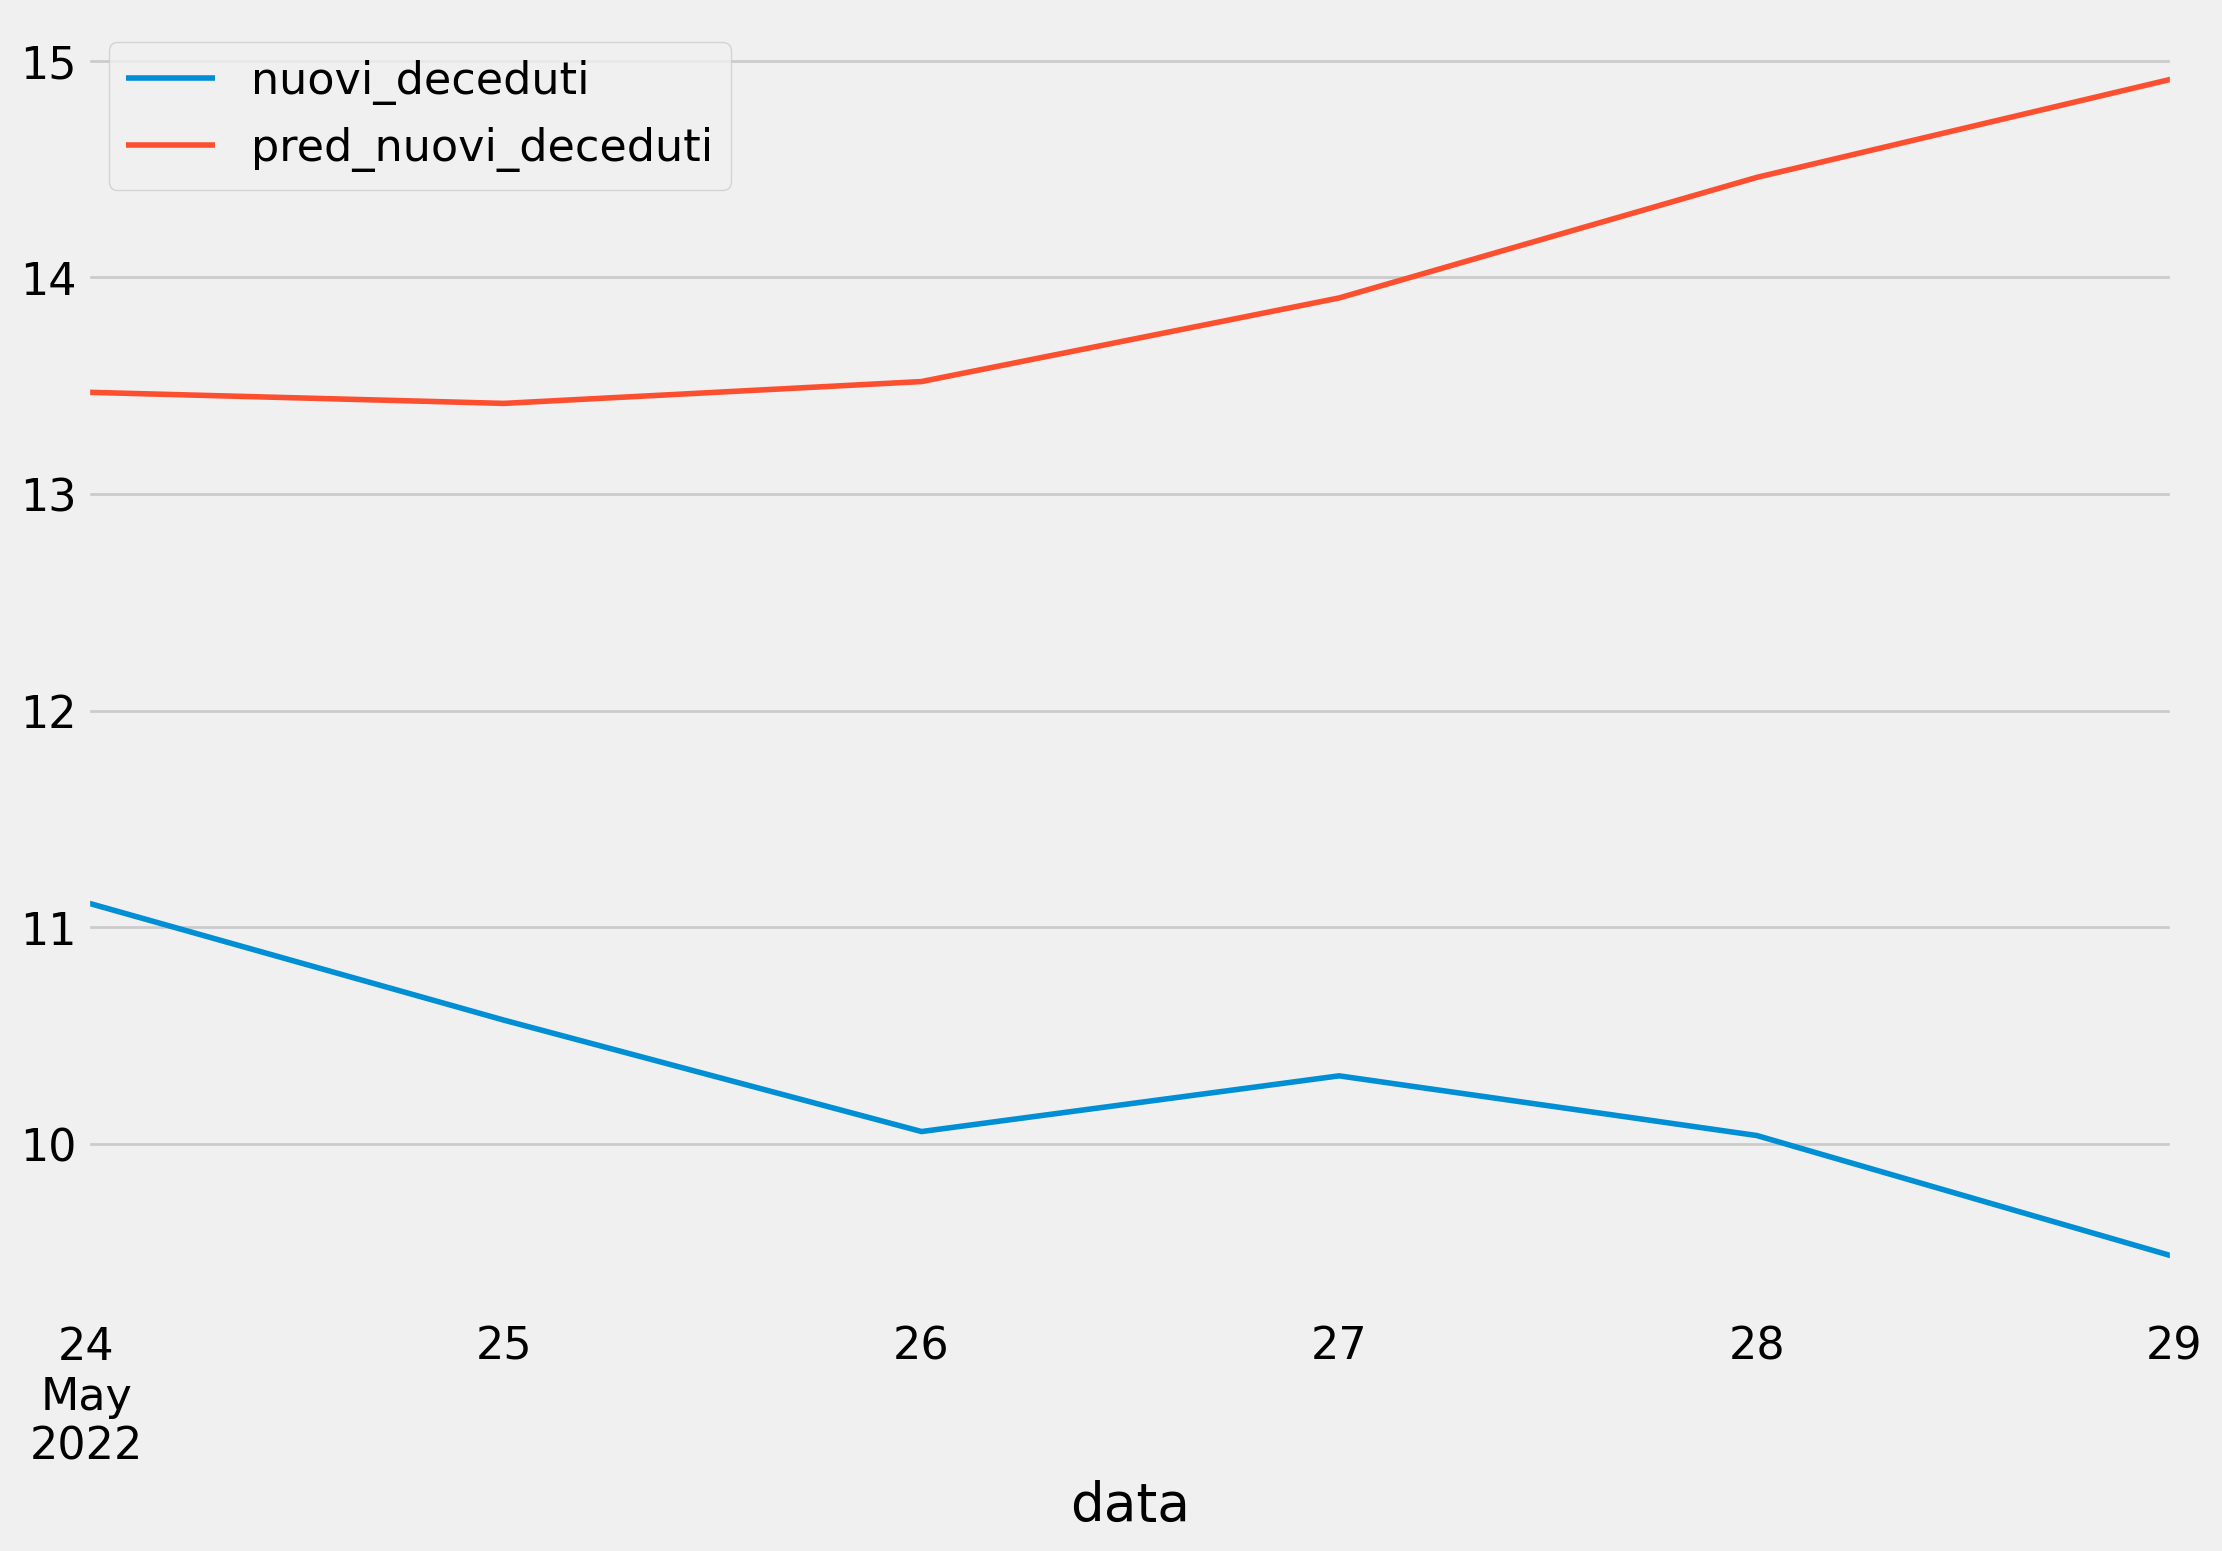

In [186]:
model1 = tf.keras.models.load_model('sicilia_deceduti_ospedalizzati_0.17255973')
model2 = tf.keras.models.load_model('sicilia_deceduti_ospedalizzati_0.14830155')

sicilia_pred = (model1.predict(x_val_windows)  + model2.predict(x_val_windows)) / 2

sicilia_ref = post_peak_val[output].copy()[val_date[0].date():val_date[-1].date()]

def denormalize(value, name):
  return value * train_std[name] + train_mean[name]

plt.figure(figsize=(16,8));

for ind, out in enumerate(output):
  sicilia_ref['pred_'+out] = sicilia_pred[:,ind]
  sicilia_ref[[out, 'pred_'+out]] = sicilia_ref[[out, 'pred_'+out]].apply(denormalize, raw=True, **{'name':out})
  sicilia_ref[[out, 'pred_'+out]]['2022-05-24':'2022-05-30'].plot();

In [187]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(sicilia_ref[output]['2022-05-24':'2022-05-30'].values, sicilia_ref[['pred_'+out for out in output]]['2022-05-24':'2022-05-30'].values)

5.258263172712325

## Test

In [188]:
def create_submmission(x_test, name, model1, model2, output=output, seasonal=seasonal):
  
  test_pred1 = model1.predict(x_test[np.newaxis,:])
  test_pred2 = model2.predict(x_test[np.newaxis,:])
  test_pred = (test_pred1 + test_pred2) / 2

  test_df = pd.DataFrame()
  test_df[output] = test_pred
  test_df['region'] = name

  for out in output:
    test_df[[out]] = test_df[[out]].apply(denormalize, raw=True, **{'name':out})

  test_df[output] = test_df[output] + seasonal[output].values[-1]

  return test_df

In [189]:
sicilia_x_test = post_peak_val[input].values[-14:]
sicilia_test_df = create_submmission(lazio_x_test, 'Sicilia', model1, model2)
sicilia_test_df.set_index('region', inplace=True)

ospedalizzati, deceduti = 'totale_ospedalizzati', 'deceduti'

base_output = [ospedalizzati, deceduti]
base_df = post_peak_val[base_output].iloc[-1:]

for out in base_output:
  base_df[[out]] = base_df[[out]].apply(denormalize, raw=True, **{'name':out})

In [190]:
sicilia_test_df['hospitalized'] = (base_df[['totale_ospedalizzati']].values[0,0] + sicilia_test_df[['nuovi_ospedalizzati']].values[0,0])
sicilia_test_df['deceased'] = (base_df[['deceduti']].values[0,0] + sicilia_test_df[['nuovi_deceduti']].values[0,0])

##Final Result

In [191]:
sicilia_test_df['newinfections'] = 0
sicilia_test_df['recovered'] = 0

final_output = ['hospitalized', 'deceased', 'newinfections', 'recovered']
sicilia_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                       
Sicilia    557.006875  10939.774603              0          0

# Submission

In [192]:
lazio_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                      
Lazio     662.075366  11341.612079              0          0

In [193]:
lombardia_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                         
Lombardia    661.332872  40560.750872              0          0

In [194]:
sicilia_test_df[final_output]

hospitalized      deceased  newinfections  recovered
region                                                       
Sicilia    557.006875  10939.774603              0          0

In [195]:
sub = pd.concat([lombardia_test_df, lazio_test_df, sicilia_test_df])[final_output]
sub = sub.astype('int')
sub.to_csv('sub_26_05.csv')